Ce projet implémente un pipeline **RAG** (Retrieval-Augmented Generation) pour la tâche **Text-to-SQL** sur le dataset **Spider**. Il combine :
* **Retrieval hybride** : embeddings denses (SentenceTransformers) + embeddings sparsés inspirés de SPLADE pour capturer à la fois le sens global et les mots-clés. Les deux types d'embeddings sont indexés avec FAISS.

* **Reranking** : un Cross-Encoder (cross-encoder/ms-marco-MiniLM-L-6-v2) qui rerank les candidats récupérés par le retrieval pour améliorer la précision.

* **RAG & Génération** : utilisation de Groq  pour interroger un LLM (ex : llama-3.x) avec un prompt few-shot construit à partir d'exemples pertinents retrievalés.

* **Évaluation robuste** : la similarité SQL est calculée via 3 axes — fingerprint structurel, recoupement d'entités (tables/colonnes) et un CrossEncoder qui juge l'équivalence sémantique , en plus de l'exact match.


** Architecture Globale: Question NL → Retrieval (Dense + SPLADE) → Reranking → Few-Shot Prompting → LLM → SQL

#IMPORTATION:

In [ ]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import numpy as np
from sentence_transformers import SentenceTransformer, CrossEncoder
from sklearn.metrics.pairwise import cosine_similarity
import faiss
from tqdm import tqdm
import re
import unicodedata
import pickle
from typing import Dict, List, Tuple
import torch
from transformers import AutoTokenizer, AutoModel
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import KFold
from collections import defaultdict
import pandas as pd
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers import LoggingHandler
import logging
from typing import List, Dict
import sqlparse






#CONFIGURATION :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#paths
BD_PATH = "/content/drive/MyDrive/ProjetIAGenNLP/spider"
SPIDER_PATH = f"{BD_PATH}/train_spider.json"
DEV_PATH = f"{BD_PATH}/dev.json"
SCHEMA_PATH = f"{BD_PATH}/tables.json"

#création du dossier cache :
CACHE_DIR = "./cache"
os.makedirs(CACHE_DIR, exist_ok=True)

#modeles utilisés
DENSE_MODEL = "sentence-transformers/all-mpnet-base-v2" #modèle dense qui transforme n’importe quelle phrase en vecteur numérique => pour capturer le sens global de la phrase.
SPLADE_MODEL = "naver/splade-cocondenser-ensembledistil"
RERANKER_MODEL = "cross-encoder/ms-marco-MiniLM-L-6-v2"

BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



# PARTIE NLP:

**1.Preprocessing**

objectif :
* Réduire le bruit =>  Améliorer la similarité des embeddings
* Garder l'uniformité : "What's" = "what s" = "whats"
* Garder les opérateurs SQL : =, >, <, %

In [ ]:
def normalize_unicode(text):
    return unicodedata.normalize("NFC", text)

def preprocess(q):
    q = normalize_unicode(q)
    q = q.lower()
    q = q.replace("\n", " ")
    q = q.replace("’", "'").replace("“", '"').replace("”", '"')

    # Supprimer ponctuation inutile : on va  conserverles chiffres et  les lettres)
    # On va garder =, >, < % pour les conditions SQL
    q = re.sub(r"[^a-z0-9=<>%\"' \s]", " ", q)

    # Supprimer espaces multiples
    q = re.sub(r"\s+", " ", q).strip()

    return q

**2.SCHEMA**

on va faire prepierement une recherche simple avec db_id dans schema_data
pour retourne le dict brut complet .

In [ ]:
def get_schema_for_db(db_id, schema_data):
    for db_schema in schema_data:
        if db_schema['db_id'] == db_id:
            return db_schema
    return None

 Pour Embeddings : Avant encode() pour retrieval , on va extraire les schema sous cette forme : Table1(col1, col2) | Table2(col3, col4)

On va donc :
- Concaténer avec la question pour l'indexation
==> ce qui aide le modèle à comprendre le contexte structurel

In [ ]:
def format_schema_compact(db_id, schema_data): #Compact : Tient dans la limite de tokens (512 max)
    """Format compact : Table1(col1, col2) | Table2(col3, col4)"""
    schema = get_schema_for_db(db_id, schema_data)
    if not schema:
        return ""

    parts = []
    table_names = schema['table_names_original']
    column_names = schema['column_names_original']

    for table_idx, table_name in enumerate(table_names):
        cols = [col_name for tbl_idx, col_name in column_names
                if tbl_idx == table_idx and col_name != '*']
        if cols:
            parts.append(f"{table_name}({', '.join(cols)})")

    return " | ".join(parts)

**3.DATA LOADING**

Chargement des données avec 2 versions : question seule ET question+schéma

output :
* questions (list): Questions préprocessées
* sqls (list): Requêtes SQL gold
* db_ids (list): Identifiants des bases
* questions_only (list): Questions seules (Version 1)
* questions_with_schema (list): Questions + schéma compact (Version 2)

In [ ]:
def load_data(spider_path, schema_data):

    print("📂 Chargement des données...")
    with open(spider_path, "r") as f:
        spider_data = json.load(f)

    questions = []
    sqls = []
    db_ids = []
    questions_only = []  # Version 1 : Question seule
    questions_with_schema = []  # Version 2 : Question + Schéma

    for item in spider_data:
        q = preprocess(item["question"])
        questions.append(q)
        sqls.append(item["query"])
        db_ids.append(item["db_id"])

        # Version 1 : JUSTE la question
        questions_only.append(q)

        # Version 2 : Question + Schéma
        schema_str = format_schema_compact(item["db_id"], schema_data)
        combined = f"{q} [SCHEMA] {schema_str}"
        questions_with_schema.append(combined)

    print(f"✅ {len(questions)} exemples chargés")
    return questions, sqls, db_ids, questions_only, questions_with_schema

**4.INDEXATION**

 **4.1 Embdeddings DENSE (SentenceTransformer)** :

   • Capture le SENS global de la phrase

   • Exemple : "étudiant avec GPA élevé" ≈ "élève avec bonne moyenne"

   • Limitation : Rate les mots-clés exacts


**4.2 Embdeddings SPARSE (SPLADE)** :
Le modèle SPLADE utilise un modèle BERT préentraîné puis finement adapté sur le dataset MS MARCO afin d’apprendre quels tokens sont discriminants pour le retrieval.→ il sait quels tokens sont importants pour retrouver les bons documents.

   • Capture les MOTS-CLÉS importants avec pondération

   • Exemple : Détecte "GPA", "3.5", "names", "students"

   **** **MS MARCO **(le plus grand dataset de recherche d’information)

Il contient des millions de paires :
(requête utilisateur, document positif, documents négatifs).
Donc le modèle MLM n’est plus un simple BERT.
Il est spécialement entraîné pour donner des scores aux tokens selon leur importance pour la recherche.

on va transformer donc la liste de textes (questions) en embeddings SPLADE, c’est-à-dire des représentations sparse (par token) basées sur :

* modèle Masked Language Model (BERT-like)

* projection log(1 + ReLU) : **ReLU** supprime les valeurs négatives & **log(1 + x)** adoucit et stabilise les valeurs

* max-pooling sur les tokens

--- > **Forme finale** : 1 vecteur sparse par texte(question)

---> Pourquoi log(1 + ReLU) ?

* ReLU : Supprime les tokens non pertinents
* log(1 + x) : Évite l'explosion des scores (stabilité)
* Max-pooling : Garde le score maximal de chaque token

In [ ]:
def splade_encode(texts, tokenizer_splade, model_splade, device=DEVICE, batch_size=BATCH_SIZE):
    """
    Encodage SPLADE avec projection MLM
    """
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="SPLADE encoding", leave=False):
        batch = texts[i:i+batch_size]
        inputs = tokenizer_splade(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512 #Le modèle MLM utilisés par SPLADE(BERT-like) ont été entraînés avec une longueur maximale de séquence de 512 tokens =>Si on dépasse 512 tokens, le tokenizer tronque automatiquement ou le modèle plante.
        ).to(device)

        with torch.no_grad():
            outputs = model_splade(**inputs)
            last_hidden = outputs.last_hidden_state

            # Log-saturation sur les activations
            sparse_embeddings = torch.log(1 + torch.relu(last_hidden)) # ==>produire des scores par token interprétables

            # Max pooling sur la dimension des tokens
            sparse_embeddings = torch.max(sparse_embeddings, dim=1)[0] # SPLADE veut garder le score maximal par token sur toute la séquence

        all_embeddings.append(sparse_embeddings.cpu().numpy())

    return np.vstack(all_embeddings).astype("float32")

**FAISS** : Facebook AI Similarity Search est une bibliothèque optimisée pour la recherche rapide de vecteurs similaires .

* Pourquoi un index FAISS par type d’embedding ?

--> Les embeddings denses et sparsés ont des distributions très différentes

* on utilise **IndexFlatIP** = Inner Product (produit scalaire) pour la similarité cosinus, car les embeddings sont normalisés

**Fusion hybride des indexes :**

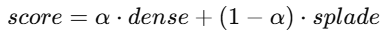

""" Lorsqu’une nouvelle question arrive, on l’encode, puis on interroge les deux index FAISS.
Ensuite on fusionne les résultats pour obtenir un retrieval hybride""""


In [ ]:
def build_hybrid_indexes(texts, dense_encoder, tokenizer_splade, model_splade, cache_name):
    """
    Construit des index HYBRIDES (dense + sparse) avec cache
    """
    cache_file = os.path.join(CACHE_DIR, f"{cache_name}.pkl")

    if os.path.exists(cache_file):
        print(f"📦 Chargement depuis le cache {cache_name}...")
        with open(cache_file, "rb") as f:
            cache = pickle.load(f)
            dense_embeddings = cache['dense']
            splade_embeddings = cache['splade']
    else:
        print(f"📊 Génération des embeddings DENSE pour {cache_name}...")
        dense_embeddings = dense_encoder.encode(texts, show_progress_bar=True, batch_size=BATCH_SIZE)
        dense_embeddings = np.array(dense_embeddings).astype("float32")

        print(f"📊 Génération des embeddings SPLADE pour {cache_name}...")
        splade_embeddings = splade_encode(texts, tokenizer_splade, model_splade, batch_size=BATCH_SIZE)

        with open(cache_file, "wb") as f:
            pickle.dump({'dense': dense_embeddings, 'splade': splade_embeddings}, f)
        print("💾 Cache sauvegardé")

    # Normalisation
    dense_norm = dense_embeddings / np.linalg.norm(dense_embeddings, axis=1, keepdims=True)
    splade_norm = splade_embeddings / np.linalg.norm(splade_embeddings, axis=1, keepdims=True)

    # Index FAISS
    dense_index = faiss.IndexFlatIP(dense_norm.shape[1])
    dense_index.add(dense_norm)

    splade_index = faiss.IndexFlatIP(splade_norm.shape[1])
    splade_index.add(splade_norm)

    return dense_norm, splade_norm, dense_index, splade_index


**5.RETRIEVAL**

**HYBRIDE = Dense + SPLADE** :

   • Combine sens global ET mots-clés précis

   • Score final = 0.5 × Dense + 0.5 × SPLADE
   
   • Meilleur équilibre sémantique/lexical

In [ ]:
def retrieve_hybrid(question, db_id, schema_data, questions, sqls, db_ids,
                   dense_encoder, tokenizer_splade, model_splade,
                   dense_index, splade_index,
                   k=5, alpha=0.5, use_schema=False, same_db_boost=0.1):
    """
    Retrieval HYBRIDE : Dense + Sparse

    Args:
        alpha: Poids pour dense (1-alpha pour sparse)
        use_schema: Si True, encode question+schéma
    """
    q_preprocessed = preprocess(question)

    # Préparer la query selon le mode
    if use_schema:
        schema_str = format_schema_compact(db_id, schema_data)
        q_to_encode = f"{q_preprocessed} [SCHEMA] {schema_str}"
    else:
        q_to_encode = q_preprocessed

    # Embedding DENSE
    q_dense = dense_encoder.encode([q_to_encode]).astype("float32")
    q_dense_norm = q_dense / np.linalg.norm(q_dense)

    # Embedding SPARSE (SPLADE)
    q_splade = splade_encode([q_to_encode], tokenizer_splade, model_splade)
    q_splade_norm = q_splade / np.linalg.norm(q_splade)

    # Recherche FAISS
    dense_scores, dense_idx = dense_index.search(q_dense_norm, k*2)
    splade_scores, splade_idx = splade_index.search(q_splade_norm, k*2)

    # Fusion des candidats
    candidates = {}
    for idx, score in zip(dense_idx[0], dense_scores[0]):
        candidates[idx] = {'dense': score, 'splade': 0.0}

    for idx, score in zip(splade_idx[0], splade_scores[0]):
        if idx in candidates:
            candidates[idx]['splade'] = score
        else:
            candidates[idx] = {'dense': 0.0, 'splade': score}

    # Score hybride
    results = []
    for idx, scores in candidates.items():
        # Normaliser [-1,1] -> [0,1]
        dense_sim = (scores['dense'] + 1) / 2
        splade_sim = (scores['splade'] + 1) / 2

        # Combinaison pondérée
        combined = alpha * dense_sim + (1 - alpha) * splade_sim

        # Boost pour même DB
        if db_ids[idx] == db_id:
            combined += same_db_boost

        results.append({
            'idx': int(idx),
            'question': questions[idx],
            'sql': sqls[idx],
            'db_id': db_ids[idx],
            'score': combined,
            'dense': scores['dense'],
            'splade': scores['splade']
        })

    # Tri par score
    results.sort(key=lambda x: x['score'], reverse=True)

    return results


**6.RERANKING**

Pourquoi un **Cross-Encoder** ?

Attention croisée : Compare directement question ↔ exemple
Plus précis ,mais trop lent pour indexer toute la base -->  le pipeline à 2 étapes
Score normalisé : Sigmoid(score) ∈ [0,1]

--->> Pipeline à 2 étapes :



1.   **Bi-encoder (Dense+SPLADE)** : Récupère 20 candidats (rapide)
2.   **Cross-encoder** : Réordonne le top-20 → top-5 (précis)





In [ ]:
def retrieve_hybrid_with_reranking(question, db_id, schema_data, questions, sqls, db_ids,
                                  dense_encoder, tokenizer_splade, model_splade, reranker,
                                  dense_index, splade_index,
                                  k=5, k_initial=20, alpha=0.5, use_schema=False):
    """
    Retrieval HYBRIDE avec RERANKING en 2 étapes

    ÉTAPE 1 : Récupération hybride (dense + sparse) → k_initial candidats
    ÉTAPE 2 : Réranking avec cross-encoder → k meilleurs
    """
    q_preprocessed = preprocess(question)

    # Préparer la query selon le mode
    if use_schema:
        schema_str = format_schema_compact(db_id, schema_data)
        q_to_encode = f"{q_preprocessed} [SCHEMA] {schema_str}"
    else:
        q_to_encode = q_preprocessed

    # ÉTAPE 1 : RÉCUPÉRATION HYBRIDE (bi-encoder)
    print(f"\n🔍 ÉTAPE 1 : Récupération hybride de {k_initial} candidats...")

    # Dense
    q_dense = dense_encoder.encode([q_to_encode]).astype("float32")
    q_dense_norm = q_dense / np.linalg.norm(q_dense)

    # Sparse
    q_splade = splade_encode([q_to_encode], tokenizer_splade, model_splade)
    q_splade_norm = q_splade / np.linalg.norm(q_splade)

    # Recherche
    dense_scores, dense_idx = dense_index.search(q_dense_norm, k_initial)
    splade_scores, splade_idx = splade_index.search(q_splade_norm, k_initial)

    # Fusion
    candidates = {}
    for idx, score in zip(dense_idx[0], dense_scores[0]):
        candidates[idx] = {'dense': score, 'splade': 0.0}

    for idx, score in zip(splade_idx[0], splade_scores[0]):
        if idx in candidates:
            candidates[idx]['splade'] = score
        else:
            candidates[idx] = {'dense': 0.0, 'splade': score}

    # Score hybride
    results = []
    for idx, scores in candidates.items():
        dense_sim = (scores['dense'] + 1) / 2
        splade_sim = (scores['splade'] + 1) / 2
        combined = alpha * dense_sim + (1 - alpha) * splade_sim

        results.append({
            'idx': int(idx),
            'question': questions[idx],
            'sql': sqls[idx],
            'db_id': db_ids[idx],
            'hybrid_score': combined,
            'dense': scores['dense'],
            'splade': scores['splade']
        })

    results.sort(key=lambda x: x['hybrid_score'], reverse=True)
    candidates_top = results[:k_initial]

    print(f"   ✅ {len(candidates_top)} candidats récupérés (Dense + SPLADE)")

    # ÉTAPE 2 : RERANKING (cross-encoder)
    print(f"\n🎯 ÉTAPE 2 : Réranking avec cross-encoder...")
    pairs = [[q_preprocessed, c['question']] for c in candidates_top]
    rerank_scores = reranker.predict(pairs)

    for i, score in enumerate(rerank_scores):
        candidates_top[i]['rerank_score'] = float(score)
        # Normalisation en [0,1] avec sigmoïde
        candidates_top[i]['rerank_score_norm'] = 1 / (1 + np.exp(-score))

    candidates_top.sort(key=lambda x: x['rerank_score'], reverse=True)

    print(f"   ✅ Réranking terminé, garde top {k}")

    return candidates_top

**7.COMPARAISON**

On va comparer les résultats obtenus par les 4 approches :
* Approche 1 (Q seule, Hybride)           
* Approche 2 (Q+Schéma, Hybride)
* Approche 3 (Q+Reranking)         
* Approche 4 (Q+Schéma+Reranking)  

In [ ]:
def compare_all_approaches(test_question, test_db_id, schema_data, questions, sqls, db_ids,
                          dense_encoder, tokenizer_splade, model_splade, reranker,
                          dense_index_only, splade_index_only,
                          dense_index_schema, splade_index_schema):
    """Compare les 4 approches avec HYBRIDE (Dense + SPLADE)"""

    print("\n" + "="*80)
    print("📊 COMPARAISON DES 4 APPROCHES (HYBRIDE: Dense + SPLADE)")
    print("="*80)
    print(f"\n❓ Question : {test_question}")
    print(f"🗄️  Database : {test_db_id}")

    # ============ APPROCHE 1 : Question seule (Hybride) ============
    print("\n" + "-"*80)
    print("🔵 APPROCHE 1 : Question SEULE (Dense + SPLADE)")
    print("-"*80)

    examples_1 = retrieve_hybrid(
        test_question, test_db_id, schema_data, questions, sqls, db_ids,
        dense_encoder, tokenizer_splade, model_splade,
        dense_index_only, splade_index_only,
        k=3, alpha=0.5, use_schema=False
    )

    for i, ex in enumerate(examples_1, 1):
        print(f"\n{i}. Hybrid: {ex['score']:.4f} | Dense: {ex['dense']:.4f} | SPLADE: {ex['splade']:.4f} | DB: {ex['db_id']}")
        print(f"   Q: {ex['question'][:70]}...")
        print(f"   SQL: {ex['sql'][:70]}...")

    # ============ APPROCHE 2 : Question + Schéma (Hybride) ============
    print("\n" + "-"*80)
    print("🟢 APPROCHE 2 : Question + Schéma (Dense + SPLADE)")
    print("-"*80)

    examples_2 = retrieve_hybrid(
        test_question, test_db_id, schema_data, questions, sqls, db_ids,
        dense_encoder, tokenizer_splade, model_splade,
        dense_index_schema, splade_index_schema,
        k=3, alpha=0.5, use_schema=True
    )

    for i, ex in enumerate(examples_2, 1):
        print(f"\n{i}. Hybrid: {ex['score']:.4f} | Dense: {ex['dense']:.4f} | SPLADE: {ex['splade']:.4f} | DB: {ex['db_id']}")
        print(f"   Q: {ex['question'][:70]}...")
        print(f"   SQL: {ex['sql'][:70]}...")

    # ============ APPROCHE 3 : Question + Reranking ============
    print("\n" + "-"*80)
    print("🟡 APPROCHE 3 : Question SEULE + Reranking")
    print("-"*80)

    examples_3 = retrieve_hybrid_with_reranking(
        test_question, test_db_id, schema_data, questions, sqls, db_ids,
        dense_encoder, tokenizer_splade, model_splade, reranker,
        dense_index_only, splade_index_only,
        k=3, k_initial=20, alpha=0.5, use_schema=False
    )

    for i, ex in enumerate(examples_3, 1):
        print(f"\n{i}. Rerank: {ex['rerank_score']:.4f} | Hybrid: {ex['hybrid_score']:.4f} | DB: {ex['db_id']}")
        print(f"   Dense: {ex['dense']:.4f} | SPLADE: {ex['splade']:.4f}")
        print(f"   Q: {ex['question'][:70]}...")
        print(f"   SQL: {ex['sql'][:70]}...")

    # ============ APPROCHE 4 : Question + Schéma + Reranking ============
    print("\n" + "-"*80)
    print("🟣 APPROCHE 4 : Question + Schéma + Reranking (MEILLEURE)")
    print("-"*80)

    examples_4 = retrieve_hybrid_with_reranking(
        test_question, test_db_id, schema_data, questions, sqls, db_ids,
        dense_encoder, tokenizer_splade, model_splade, reranker,
        dense_index_schema, splade_index_schema,
        k=3, k_initial=20, alpha=0.5, use_schema=True
    )

    for i, ex in enumerate(examples_4, 1):
        print(f"\n{i}. Rerank: {ex['rerank_score']:.4f} | Hybrid: {ex['hybrid_score']:.4f} | DB: {ex['db_id']}")
        print(f"   Dense: {ex['dense']:.4f} | SPLADE: {ex['splade']:.4f}")
        print(f"   Q: {ex['question'][:70]}...")
        print(f"   SQL: {ex['sql'][:70]}...")

    # ============ ANALYSE ============
    print("📈 ANALYSE COMPARATIVE")

    same_db_1 = sum(1 for ex in examples_1 if ex['db_id'] == test_db_id)
    same_db_2 = sum(1 for ex in examples_2 if ex['db_id'] == test_db_id)
    same_db_3 = sum(1 for ex in examples_3 if ex['db_id'] == test_db_id)
    same_db_4 = sum(1 for ex in examples_4 if ex['db_id'] == test_db_id)

    print(f"\n🎯 Exemples de la même DB (sur 3):")
    print(f"   Approche 1 (Q seule, Hybride)           : {same_db_1}/3")
    print(f"   Approche 2 (Q+Schéma, Hybride)          : {same_db_2}/3")
    print(f"   Approche 3 (Q+Reranking)                : {same_db_3}/3")
    print(f"   Approche 4 (Q+Schéma+Reranking)         : {same_db_4}/3 ")

    print(f"\n📊 Scores finaux moyens:")
    print(f"   Approche 1 : {np.mean([ex['score'] for ex in examples_1]):.4f}")
    print(f"   Approche 2 : {np.mean([ex['score'] for ex in examples_2]):.4f}")
    print(f"   Approche 3 : {np.mean([ex['rerank_score'] for ex in examples_3]):.4f}")
    print(f"   Approche 4 : {np.mean([ex['rerank_score'] for ex in examples_4]):.4f} ")

    print(f"\n🔥 Contribution Dense vs SPLADE (Approche 1):")
    print(f"   Dense moyen  : {np.mean([ex['dense'] for ex in examples_1]):.4f}")
    print(f"   SPLADE moyen : {np.mean([ex['splade'] for ex in examples_1]):.4f}")


In [ ]:
 # Chargement des données : schema
print("📂 Chargement des schémas...")
with open(SCHEMA_PATH, "r") as f:
        schema_data = json.load(f)
#  Chargement des données Spider ave la fonction load_data
questions, sqls, db_ids, questions_only, questions_with_schema = load_data(
        SPIDER_PATH, schema_data
    )


📂 Chargement des schémas...
📂 Chargement des données...
✅ 7000 exemples chargés


In [ ]:
dense_encoder = SentenceTransformer(DENSE_MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
print("📊 Chargement du modèle SPLADE...")
tokenizer_splade = AutoTokenizer.from_pretrained(SPLADE_MODEL)
model_splade = AutoModel.from_pretrained(SPLADE_MODEL)
model_splade.eval()
model_splade.to(DEVICE)
print(f"✅ SPLADE chargé sur {DEVICE}")

📊 Chargement du modèle SPLADE...


tokenizer_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at naver/splade-cocondenser-ensembledistil and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ SPLADE chargé sur cpu


In [ ]:
reranker = CrossEncoder(RERANKER_MODEL)

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
if __name__ == "__main__":
    print("\n📊 Chargement des modèles...")
    dense_encoder = SentenceTransformer(DENSE_MODEL)

    print("📊 Chargement du modèle SPLADE...")
    tokenizer_splade = AutoTokenizer.from_pretrained(SPLADE_MODEL)
    model_splade = AutoModel.from_pretrained(SPLADE_MODEL)
    model_splade.eval()
    model_splade.to(DEVICE)
    print(f"✅ SPLADE chargé sur {DEVICE}")

    print("📊 Chargement du reranker...")
    reranker = CrossEncoder(RERANKER_MODEL)



    # 3. Construction des index HYBRIDES

    print("📊 CONSTRUCTION DES INDEX HYBRIDES (Dense + SPLADE)")


    print("\n📊 Index 1 : Question seule")
    dense_emb_only, splade_emb_only, dense_idx_only, splade_idx_only = build_hybrid_indexes(
        questions_only, dense_encoder, tokenizer_splade, model_splade,
        "hybrid_question_only"
    )

    print("\n📊 Index 2 : Question + Schéma")
    dense_emb_schema, splade_emb_schema, dense_idx_schema, splade_idx_schema = build_hybrid_indexes(
        questions_with_schema, dense_encoder, tokenizer_splade, model_splade,
        "hybrid_question_schema"
    )



📊 Chargement des modèles...
📊 Chargement du modèle SPLADE...


Some weights of BertModel were not initialized from the model checkpoint at naver/splade-cocondenser-ensembledistil and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ SPLADE chargé sur cpu
📊 Chargement du reranker...
📊 CONSTRUCTION DES INDEX HYBRIDES (Dense + SPLADE)

📊 Index 1 : Question seule
📊 Génération des embeddings DENSE pour hybrid_question_only...


Batches:   0%|          | 0/219 [00:00<?, ?it/s]

📊 Génération des embeddings SPLADE pour hybrid_question_only...


💾 Cache sauvegardé

📊 Index 2 : Question + Schéma
📊 Génération des embeddings DENSE pour hybrid_question_schema...


Batches:   0%|          | 0/219 [00:00<?, ?it/s]

📊 Génération des embeddings SPLADE pour hybrid_question_schema...


💾 Cache sauvegardé


In [ ]:
# 5. Comparaison
if __name__ == "__main__":
    test_question = "What are the names of all students who have a GPA above 3.5?"
    test_db_id = "college_1"

    compare_all_approaches(
        test_question, test_db_id, schema_data,
        questions, sqls, db_ids,
        dense_encoder, tokenizer_splade, model_splade, reranker,
        dense_idx_only, splade_idx_only,
        dense_idx_schema, splade_idx_schema
    )

    print("\n✅ Comparaison complète terminée !")


📊 COMPARAISON DES 4 APPROCHES (HYBRIDE: Dense + SPLADE)

❓ Question : What are the names of all students who have a GPA above 3.5?
🗄️  Database : college_1

--------------------------------------------------------------------------------
🔵 APPROCHE 1 : Question SEULE (Dense + SPLADE)
--------------------------------------------------------------------------------



1. Hybrid: 1.0248 | Dense: 0.7447 | SPLADE: 0.9546 | DB: college_1
   Q: what is the first last name gpa of the youngest one among students who...
   SQL: SELECT stu_fname ,  stu_lname ,  stu_gpa FROM student WHERE stu_gpa  >...

2. Hybrid: 1.0128 | Dense: 0.6917 | SPLADE: 0.9594 | DB: college_1
   Q: what is the first name gpa and phone number of the students with the t...
   SQL: SELECT stu_gpa ,  stu_phone ,  stu_fname FROM student ORDER BY stu_gpa...

3. Hybrid: 0.8394 | Dense: 0.0000 | SPLADE: 0.9576 | DB: college_1
   Q: what is the department name of the students with lowest gpa belongs to...
   SQL: SELECT T2.dept_name FROM student AS T1 JOIN department AS T2 ON T1.dep...

4. Hybrid: 0.8387 | Dense: 0.0000 | SPLADE: 0.9548 | DB: college_1
   Q: what is the first name gpa and phone number of the top 5 students with...
   SQL: SELECT stu_gpa ,  stu_phone ,  stu_fname FROM student ORDER BY stu_gpa...

5. Hybrid: 0.7854 | Dense: 0.7414 | SPLADE: 0.0000 | DB: college_1
   Q: what i


1. Hybrid: 1.0788 | Dense: 0.9198 | SPLADE: 0.9954 | DB: college_1
   Q: what is the first and last name of the youngest student with a gpa abo...
   SQL: SELECT stu_fname ,  stu_lname ,  stu_gpa FROM student WHERE stu_gpa  >...

2. Hybrid: 1.0783 | Dense: 0.9188 | SPLADE: 0.9944 | DB: college_1
   Q: what is the first name and gpa of every student that has a gpa lower t...
   SQL: SELECT stu_fname ,  stu_gpa FROM student WHERE stu_gpa  <  (SELECT avg...

3. Hybrid: 1.0766 | Dense: 0.9114 | SPLADE: 0.9952 | DB: college_1
   Q: what is the first name gpa and phone number of the students with the t...
   SQL: SELECT stu_gpa ,  stu_phone ,  stu_fname FROM student ORDER BY stu_gpa...

4. Hybrid: 1.0732 | Dense: 0.8977 | SPLADE: 0.9951 | DB: college_1
   Q: what is the first last name gpa of the youngest one among students who...
   SQL: SELECT stu_fname ,  stu_lname ,  stu_gpa FROM student WHERE stu_gpa  >...

5. Hybrid: 1.0711 | Dense: 0.8891 | SPLADE: 0.9953 | DB: college_1
   Q: what i

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...


   ✅ Réranking terminé, garde top 3

1. Rerank: 2.0971 | Hybrid: 0.9248 | DB: college_1
   Dense: 0.7447 | SPLADE: 0.9546
   Q: what is the first last name gpa of the youngest one among students who...
   SQL: SELECT stu_fname ,  stu_lname ,  stu_gpa FROM student WHERE stu_gpa  >...

2. Rerank: 1.6820 | Hybrid: 0.9231 | DB: college_1
   Dense: 0.7414 | SPLADE: 0.9512
   Q: what is the first and last name of the youngest student with a gpa abo...
   SQL: SELECT stu_fname ,  stu_lname ,  stu_gpa FROM student WHERE stu_gpa  >...

3. Rerank: 0.5844 | Hybrid: 0.8855 | DB: college_3
   Dense: 0.6006 | SPLADE: 0.9412
   Q: find the distinct student first names of all students that have grade ...
   SQL: SELECT DISTINCT T3.Fname FROM ENROLLED_IN AS T1 JOIN GRADECONVERSION A...

4. Rerank: 0.3060 | Hybrid: 0.7394 | DB: epinions_1
   Dense: 0.0000 | SPLADE: 0.9575
   Q: find the names of items whose rank is higher than 3 and whose average ...
   SQL: SELECT T1.title FROM item AS T1 JOIN review A

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 3

1. Rerank: 2.0971 | Hybrid: 0.9732 | DB: college_1
   Dense: 0.8977 | SPLADE: 0.9951
   Q: what is the first last name gpa of the youngest one among students who...
   SQL: SELECT stu_fname ,  stu_lname ,  stu_gpa FROM student WHERE stu_gpa  >...

2. Rerank: 1.6820 | Hybrid: 0.9788 | DB: college_1
   Dense: 0.9198 | SPLADE: 0.9954
   Q: what is the first and last name of the youngest student with a gpa abo...
   SQL: SELECT stu_fname ,  stu_lname ,  stu_gpa FROM student WHERE stu_gpa  >...

3. Rerank: -0.3183 | Hybrid: 0.9766 | DB: college_1
   Dense: 0.9114 | SPLADE: 0.9952
   Q: what is the first name gpa and phone number of the students with the t...
   SQL: SELECT stu_gpa ,  stu_phone ,  stu_fname FROM student ORDER BY stu_gpa...

4. Rerank: -0.4359 | Hybrid: 0.9671 | DB: college_1
   Dense: 0.8760 | SPLADE: 0.9923
   Q: find the first name and gpa of the s

**8.Evaluation du Retrival**

**Similarité basée sur les SQL Fingerprints** :
Compare la structure SQL en normalisant les mots-clés et les identifiants. Retourne un score entre 0 et 1 indiquant la similarité globale.



In [ ]:
def sql_fingerprint(sql):
    # Normalisation
    sql = sqlparse.format(
        sql,
        keyword_case="upper",
        identifier_case="lower",
        strip_comments=True
    )
    parsed = sqlparse.parse(sql)[0]

    # Liste des tokens utiles
    tokens = [
        t.value for t in parsed.flatten()
        if t.ttype is not sqlparse.tokens.Whitespace
    ]

    # Retirer nombres, guillemets, virgules
    clean = []
    for t in tokens:
        if t.isdigit():
            continue
        if t in ['"', "'", ","]:
            continue
        clean.append(t)

    return clean


def sql_fingerprint_similarity(sql_a, sql_b):
    fp_a = set(sql_fingerprint(sql_a))
    fp_b = set(sql_fingerprint(sql_b))

    if len(fp_a | fp_b) == 0:
        return 0.0

    return len(fp_a & fp_b) / len(fp_a | fp_b)


On veux compare avec les deux fonctions suivantes : les tables et colonnes utilisées dans les deux SQL.

Score harmonic mean entre tables et colonnes (0 à 1).

In [ ]:
def extract_entities(sql):
    sql = sql.lower()

    # Extraction tables (FROM + JOIN)
    tables = re.findall(r"from\s+([a-zA-Z0-9_]+)", sql)
    tables += re.findall(r"join\s+([a-zA-Z0-9_]+)", sql)

    # Extraction colonnes (SELECT … FROM)
    cols_match = re.search(r"select\s+(.*?)\s+from", sql, re.S)
    columns = []
    if cols_match:
        columns = [c.strip() for c in cols_match.group(1).split(",")]

    return set(tables), set(columns)


def entity_overlap(sql_a, sql_b):
    t1, c1 = extract_entities(sql_a)
    t2, c2 = extract_entities(sql_b)

    # table score
    tu = t1 | t2
    table_score = len(t1 & t2) / len(tu) if tu else 0.0

    # column score
    cu = c1 | c2
    col_score = len(c1 & c2) / len(cu) if cu else 0.0

    # harmonic mean
    if table_score + col_score == 0:
        return 0.0

    return 2 * table_score * col_score / (table_score + col_score)



Pour le metrique **judge** :utilise un CrossEncoder(lit les deux phrases ou textes simultanément et décide : à quel point ils sont proches sémantiquement ) pour juger si deux SQL sont équivalents sémantiquement.

**Le modèle "cross-encoder/ms-marco-MiniLM-L-6-v2"**

c'est un modèle pré-entraîné sur le dataset MS MARCO, qui est un corpus de questions-réponses pour le retrieval .

MiniLM → version légère et rapide de BERT, donc efficace pour le calcul.

L’objectif de ce modèle est de prédire un score de relevance entre deux textes

In [ ]:
from sentence_transformers import CrossEncoder
import numpy as np

judge = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def judge_sql_equivalence(sql_a, sql_b):
    raw = judge.predict([[sql_a, sql_b]])[0]
    # sigmoïde pour normaliser en [0,1]
    return float(1 / (1 + np.exp(-raw)))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

**Fonction de l'evaluation** :

Pour chaque question test, on récupère les 20 meilleures requêtes du retrieval.

Chaque requête générée est comparée à la requête “gold” via fingerprint, entity overlap et CrossEncoder judge.

On calcule le MRR et les metrics Precision@K, Recall@K, SameDB@K en utilisant ces scores finaux pour décider si une requête est “correcte”.

In [ ]:
def evaluate_retrieval(
    approach_name, retrieve_function,
    questions_test, sqls_test, db_ids_test,
    questions_train, sqls_train, db_ids_train,
    schema_data, dense_encoder, tokenizer_splade, model_splade, reranker,
    dense_index, splade_index,
    k_values=[1, 3, 5], batch_size=64,
    **kwargs
):

    results = {k: {'precision': [], 'recall': [], 'same_db': []} for k in k_values}
    mrr_scores = []

    print(f"\n Évaluation de : {approach_name}")
    print(f"   Nombre d'exemples test : {len(questions_test)}")
    print(f"   Batch size = {batch_size}")

    N = len(questions_test)

    for start in tqdm(range(0, N, batch_size), desc=f"Eval {approach_name}"):

        end = min(start + batch_size, N)

        batch_questions = questions_test[start:end]
        batch_sqls = sqls_test[start:end]
        batch_dbs = db_ids_test[start:end]

        batch_retrieved = []
        for q, db in zip(batch_questions, batch_dbs):

            retrieved = retrieve_function(
                q, db, schema_data,
                questions_train, sqls_train, db_ids_train,
                dense_encoder, tokenizer_splade, model_splade,
                dense_index, splade_index,
                **kwargs
            )

            batch_retrieved.append(retrieved[:20])


        # Évaluation

        for q_sql, q_db, retrieved in zip(batch_sqls, batch_dbs, batch_retrieved):

            # judge (batch)
            pairs = [[ex["sql"], q_sql] for ex in retrieved]
            judge_raw = judge.predict(pairs, batch_size=32)
            judge_scores = 1 / (1 + np.exp(-judge_raw))

            fp_scores = [
                sql_fingerprint_similarity(ex["sql"], q_sql)
                for ex in retrieved
            ]

            ent_scores = [
                entity_overlap(ex["sql"], q_sql)
                for ex in retrieved
            ]

            final_scores = [
                (fp + ent + js) / 3
                for fp, ent, js in zip(fp_scores, ent_scores, judge_scores)
            ]

            # MRR
            first_pos = None
            for rank, score in enumerate(final_scores, 1):
                if score > 0.6:
                    first_pos = rank
                    break

            mrr_scores.append(1.0 / first_pos if first_pos else 0.0)

            # metrics@k
            for k in k_values:
                top_k = final_scores[:k]
                relevant = sum(s > 0.6 for s in top_k)
                same_db = sum(1 for ex in retrieved[:k] if ex["db_id"] == q_db)

                results[k]['precision'].append(relevant / k)
                results[k]['recall'].append(1.0 if relevant > 0 else 0.0)
                results[k]['same_db'].append(same_db / k)


    # Moyennes finales
    metrics = {}
    for k in k_values:
        metrics[f"P@{k}"] = np.mean(results[k]['precision'])
        metrics[f"R@{k}"] = np.mean(results[k]['recall'])
        metrics[f"SameDB@{k}"] = np.mean(results[k]['same_db'])

    metrics["MRR"] = np.mean(mrr_scores)

    return metrics


Pour evaluer la pertinence des 4 approches , on va utiliser la methode cross validation .

Dans **cross_validate_retrieval** :

* On crée 3 folds (train/test).

* On reconstruit les index (Dense + SPLADE) pour chaque fold.

* On teste les 4 approches (Q only, Q+Schema, Q+Rerank, Q+Schema+Rerank).

Pour chaque approche et fold, on appelle evaluate_retrieval, qui utilise les 3 fonctions de comparaison SQL pour calculer les scores.

À la fin, on calcule la moyenne et l’écart type des metrics pour toutes les folds.

In [ ]:
from sklearn.model_selection import KFold
from tqdm import tqdm
from collections import defaultdict

def cross_validate_retrieval(
    questions, sqls, db_ids, schema_data,
    dense_encoder, tokenizer_splade, model_splade, reranker,
    n_splits=5, k_values=[1,3,5]
):
    print("📊 ÉVALUATION AVEC CROSS-VALIDATION")
    print(f"   Nombre de folds : {n_splits}")
    print(f"   Valeurs de k : {k_values}")
    print(f"   Total exemples : {len(questions)}")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_results = {
        'Approach_1_Q_only': [],
        'Approach_2_Q_Schema': [],
        'Approach_3_Q_Rerank': [],
        'Approach_4_Q_Schema_Rerank': []
    }

    for fold_idx, (train_idx, test_idx) in enumerate(
        tqdm(kf.split(questions), total=n_splits, desc="Folds"), 1
    ):
        print(f"\n{'='*70}")
        print(f"📁 FOLD {fold_idx}/{n_splits}")
        print(f"{'='*70}")

        # Split
        questions_train = [questions[i] for i in train_idx]
        sqls_train = [sqls[i] for i in train_idx]
        db_ids_train = [db_ids[i] for i in train_idx]

        questions_test = [questions[i] for i in test_idx]
        sqls_test = [sqls[i] for i in test_idx]
        db_ids_test = [db_ids[i] for i in test_idx]

        # Préparer version schéma
        questions_with_schema_train = [
            f"{questions_train[i]} [SCHEMA] {format_schema_compact(db_ids_train[i], schema_data)}"
            for i in range(len(questions_train))
        ]

        # Indexes
        dense_emb_only, splade_emb_only, dense_idx_only, splade_idx_only = build_hybrid_indexes(
            questions_train, dense_encoder, tokenizer_splade, model_splade,
            f"fold{fold_idx}_qonly"
        )

        dense_emb_schema, splade_emb_schema, dense_idx_schema, splade_idx_schema = build_hybrid_indexes(
            questions_with_schema_train, dense_encoder, tokenizer_splade, model_splade,
            f"fold{fold_idx}_qschema"
        )

        # Approche 1
        m1 = evaluate_retrieval(
            "Approche 1: Question seule",
            retrieve_hybrid,
            questions_test, sqls_test, db_ids_test,
            questions_train, sqls_train, db_ids_train,
            schema_data, dense_encoder, tokenizer_splade, model_splade, None,
            dense_idx_only, splade_idx_only,
            k_values=k_values
        )
        all_results["Approach_1_Q_only"].append(m1)

        # Approche 2
        m2 = evaluate_retrieval(
            "Approche 2: Question + Schéma",
            retrieve_hybrid,
            questions_test, sqls_test, db_ids_test,
            questions_with_schema_train, sqls_train, db_ids_train,
            schema_data, dense_encoder, tokenizer_splade, model_splade, None,
            dense_idx_schema, splade_idx_schema,
            k_values=k_values,
            use_schema=True
        )
        all_results["Approach_2_Q_Schema"].append(m2)

        # Approche 3
        def wrap_rerank(q, db, *args, **kw):
            return retrieve_hybrid_with_reranking(
                q, db, schema_data, questions_train, sqls_train, db_ids_train,
                dense_encoder, tokenizer_splade, model_splade, reranker,
                dense_idx_only, splade_idx_only, k=max(k_values)
            )

        m3 = evaluate_retrieval(
            "Approche 3: Question + Reranking",
            wrap_rerank,
            questions_test, sqls_test, db_ids_test,
            questions_train, sqls_train, db_ids_train,
            schema_data, dense_encoder, tokenizer_splade, model_splade, reranker,
            dense_idx_only, splade_idx_only,
            k_values=k_values
        )
        all_results["Approach_3_Q_Rerank"].append(m3)

        # Approche 4
        def wrap_rerank_schema(q, db, *args, **kw):
            return retrieve_hybrid_with_reranking(
                q, db, schema_data, questions_with_schema_train, sqls_train, db_ids_train,
                dense_encoder, tokenizer_splade, model_splade, reranker,
                dense_idx_schema, splade_idx_schema, k=max(k_values)
            )

        m4 = evaluate_retrieval(
            "Approche 4: Question + Schéma + Reranking",
            wrap_rerank_schema,
            questions_test, sqls_test, db_ids_test,
            questions_with_schema_train, sqls_train, db_ids_train,
            schema_data, dense_encoder, tokenizer_splade, model_splade, reranker,
            dense_idx_schema, splade_idx_schema,
            k_values=k_values
        )
        all_results["Approach_4_Q_Schema_Rerank"].append(m4)


    # Résultats finaux (moyenne + std)
    rows = []
    for approach, folds in all_results.items():
        row = {"Approach": approach}
        for metric in folds[0].keys():
            values = [f[metric] for f in folds]
            row[f"{metric}_mean"] = np.mean(values)
            row[f"{metric}_std"] = np.std(values)
        rows.append(row)

    df = pd.DataFrame(rows)


In [ ]:
if __name__ == "__main__":
    print("\n🚀 Démarrage de l'évaluation...")

    k_values = [1, 3, 5]

    results_df = cross_validate_retrieval(
        questions, sqls, db_ids, schema_data,
        dense_encoder, tokenizer_splade, model_splade, reranker,
        n_splits=3,
        k_values=k_values
    )

    results_df.to_csv("retrieval_evaluation_results.csv", index=False)

    print("\n📊 Résultats finaux :\n")
    print(results_df)



🚀 Démarrage de l'évaluation...
📊 ÉVALUATION AVEC CROSS-VALIDATION
   Nombre de folds : 3
   Valeurs de k : [1, 3, 5]
   Total exemples : 7000


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


📁 FOLD 1/3
📊 Génération des embeddings DENSE pour fold1_qonly...


Batches:   0%|          | 0/146 [00:00<?, ?it/s]

📊 Génération des embeddings SPLADE pour fold1_qonly...



SPLADE encoding: 100%|██████████| 146/146 [00:08<00:00, 17.64it/s]
                                                                  

💾 Cache sauvegardé
📊 Génération des embeddings DENSE pour fold1_qschema...


Batches:   0%|          | 0/146 [00:00<?, ?it/s]

📊 Génération des embeddings SPLADE pour fold1_qschema...



SPLADE encoding: 100%|██████████| 146/146 [00:56<00:00,  3.90it/s]
                                                                  

💾 Cache sauvegardé

 Évaluation de : Approche 1: Question seule
   Nombre d'exemples test : 2334
   Batch size = 64


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]

                                                      

SPLADE encoding:   0%|    

KeyboardInterrupt: 

**9.Analyse de l'évaluation**

**MRR** = Mean Reciprocal Rank: C’est la moyenne des réciproques des rangs de la première réponse correcte pour chaque question.


* Plus le score est proche de 1 → le résultat correct apparaît très haut dans la liste.

* Utile pour mesurer la qualité globale du ranking.

**P@k** = Precision at k :Pour chaque question, c’est la proportion de réponses correctes dans les k premières prédictions.

Exemple :

P@1 = 1 si la première réponse est correcte, 0 sinon.

P@3 = fraction des 3 premières réponses correctes (0, 1/3, 2/3, 1).

Interprétation :

* Mesure la précision immédiate des premières réponses.

* Plus le score est élevé → l’utilisateur a plus de chances de voir la bonne réponse rapidement.

**R@k**= Recall at k : Proportion de toutes les réponses correctes qui sont récupérées parmi les k premières.

* Dans notre cas, comme il n’y a qu’une bonne SQL par question, R@k est souvent 0 ou 1 selon que la bonne SQL est dans le top-k.



* Utile si une question peut avoir plusieurs réponses correctes, mais dans ton dataset SQL, ça correspond à “la bonne réponse est dans le top-k ou pas”.

**SameDB@k** : Proportion des k premières prédictions qui proviennent de la même base de données que la question.

* on veux éviter de récupérer des SQL valides mais sur la mauvaise base.

* Un score de 1 → toutes les top-k réponses sont sur la bonne base.

In [ ]:
df_eva = pd.read_csv("/content/retrieval_evaluation_results (1).csv")

In [ ]:
df_eva

,Approach,P@1_mean,P@1_std,R@1_mean,R@1_std,SameDB@1_mean,SameDB@1_std,P@3_mean,P@3_std,R@3_mean,...,SameDB@5_mean,SameDB@5_std,P@10_mean,P@10_std,R@10_mean,R@10_std,SameDB@10_mean,SameDB@10_std,MRR_mean,MRR_std
0,Approach_1_Q_only,0.670143,0.004412,0.670143,0.004412,0.940858,7.588047e-03,0.427620,0.008588,0.768287,...,0.755371,0.009213,0.229429,0.001948,0.837715,0.010188,0.674185,0.007534,0.726537,0.005985
1,Approach_2_Q_Schema,0.637715,0.006433,0.637715,0.006433,0.999571,8.657214e-08,0.413762,0.002645,0.766001,...,0.994515,0.001145,0.217257,0.001993,0.832286,0.003483,0.980614,0.003354,0.707482,0.005800
2,Approach_3_Q_Rerank,0.646143,0.003859,0.646143,0.003859,0.850429,1.373528e-03,0.421762,0.004279,0.762143,...,0.679800,0.008740,0.220814,0.001906,0.824143,0.005854,0.551229,0.006871,0.710270,0.005237
3,Approach_4_Q_Schema_Rerank,0.634571,0.004572,0.634571,0.004572,0.916571,5.660061e-03,0.422524,0.003809,0.769714,...,0.881400,0.004860,0.241957,0.000354,0.844429,0.003762,0.870014,0.003055,0.708327,0.002953


In [ ]:
df_eva.columns

Index(['Approach', 'P@1_mean', 'P@1_std', 'R@1_mean', 'R@1_std',
       'SameDB@1_mean', 'SameDB@1_std', 'P@3_mean', 'P@3_std', 'R@3_mean',
       'R@3_std', 'SameDB@3_mean', 'SameDB@3_std', 'P@5_mean', 'P@5_std',
       'R@5_mean', 'R@5_std', 'SameDB@5_mean', 'SameDB@5_std', 'P@10_mean',
       'P@10_std', 'R@10_mean', 'R@10_std', 'SameDB@10_mean', 'SameDB@10_std',
       'MRR_mean', 'MRR_std'],
      dtype='object')

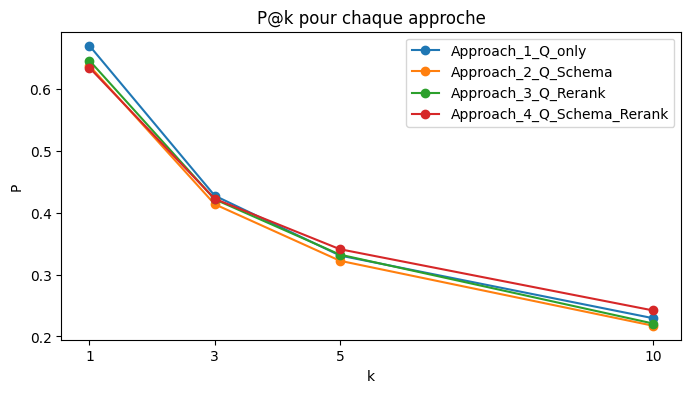

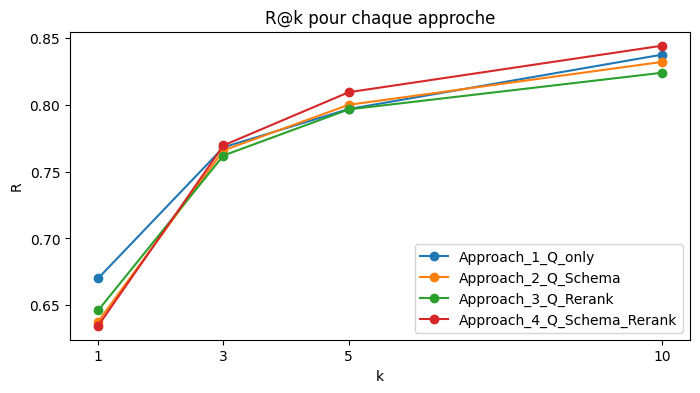

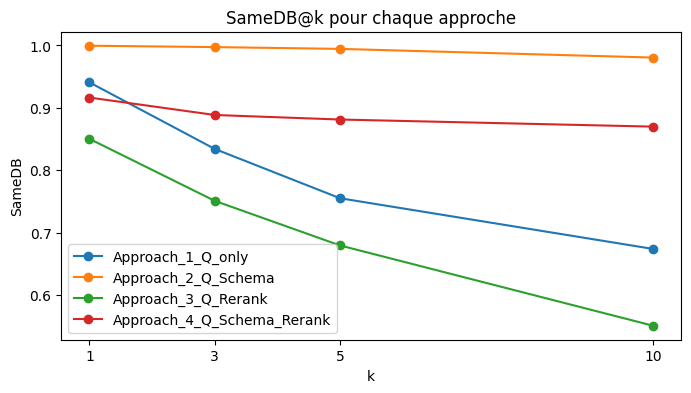

In [ ]:
import matplotlib.pyplot as plt

k_values = [1,3,5,10]
for metric in ['P','R','SameDB']:
    plt.figure(figsize=(8,4))
    for idx, row in df_eva.iterrows():
        y = [row[f"{metric}@{k}_mean"] for k in k_values]
        plt.plot(k_values, y, marker='o', label=row['Approach'])
    plt.title(f"{metric}@k pour chaque approche")
    plt.xlabel("k")
    plt.ylabel(metric)
    plt.xticks(k_values)
    plt.legend()
    plt.show()


In [ ]:
df_eva.sort_values('MRR_mean', ascending=False)[['Approach','MRR_mean','P@1_mean','SameDB@1_mean']]


,Approach,MRR_mean,P@1_mean,SameDB@1_mean
0,Approach_1_Q_only,0.726537,0.670143,0.940858
2,Approach_3_Q_Rerank,0.710270,0.646143,0.850429
3,Approach_4_Q_Schema_Rerank,0.708327,0.634571,0.916571
1,Approach_2_Q_Schema,0.707482,0.637715,0.999571


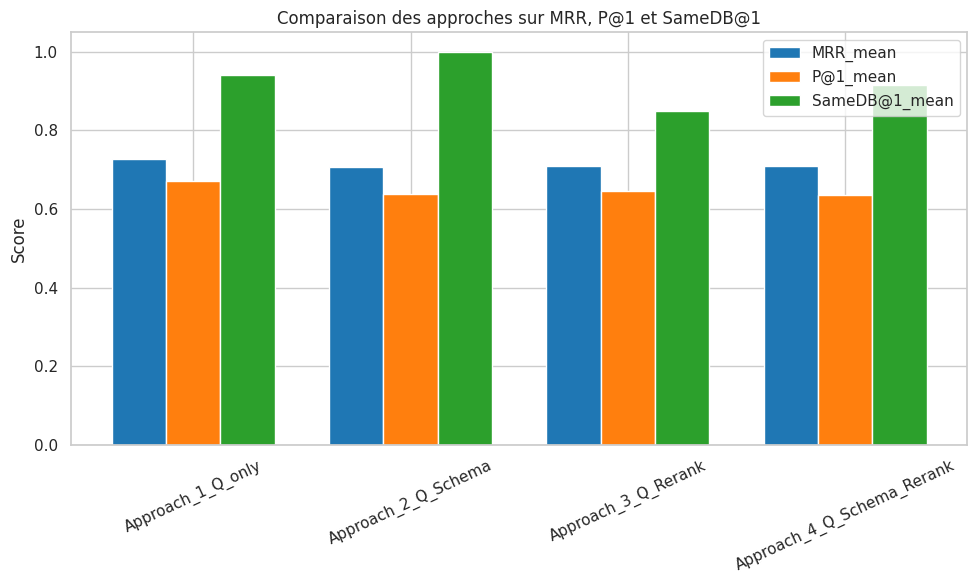

In [ ]:
import seaborn as sns
# Configuration graphique
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

# Largeur des barres
bar_width = 0.25
x = range(len(df_eva))

# Barres pour chaque métrique
plt.bar([i - bar_width for i in x], df_eva["MRR_mean"], width=bar_width, label="MRR_mean", color="#1f77b4")
plt.bar(x, df_eva["P@1_mean"], width=bar_width, label="P@1_mean", color="#ff7f0e")
plt.bar([i + bar_width for i in x], df_eva["SameDB@1_mean"], width=bar_width, label="SameDB@1_mean", color="#2ca02c")

# Labels et titres
plt.xticks(x, df_eva["Approach"], rotation=25)
plt.ylabel("Score")
plt.title("Comparaison des approches sur MRR, P@1 et SameDB@1")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

#Partie IA Générative

In [ ]:
print("\n Récapitulatif des données disponibles:")
print(f"   ✅ Schémas: {len(schema_data)} bases de données")
print(f"   ✅ Questions d'entraînement: {len(questions)}")
print(f"   ✅ Dense encoder: {DENSE_MODEL}")
print(f"   ✅ SPLADE model: {SPLADE_MODEL}")
print(f"   ✅ Reranker: {RERANKER_MODEL}")
print(f"   ✅ Index construits: Question seule + Question+Schema")


 Récapitulatif des données disponibles:
   ✅ Schémas: 166 bases de données
   ✅ Questions d'entraînement: 7000
   ✅ Dense encoder: sentence-transformers/all-mpnet-base-v2
   ✅ SPLADE model: naver/splade-cocondenser-ensembledistil
   ✅ Reranker: cross-encoder/ms-marco-MiniLM-L-6-v2
   ✅ Index construits: Question seule + Question+Schema


dans les étapes suivantes , on va utiliser la librairie **SQLParse** :très pratique pour travailler avec du SQL.

Elle est légère et permet principalement de parser, formater et analyser du code SQ

In [ ]:
!pip install groq sqlparse -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 6.1 MB/s eta 0:00:00


**1.Choix du retrival**

In [ ]:
def get_best_examples(question: str, db_id: str, schema_data,
                      questions_train, sqls_train, db_ids_train,
                      dense_encoder, tokenizer_splade, model_splade, reranker,
                      dense_index, splade_index, k=5, approach=4):
    """
    Récupère les meilleurs exemples selon l'approche choisie.
    approach=2 : retrieve_hybrid (Q+Schema)
    approach=4 : retrieve_hybrid_with_reranking (Q+Schema+Reranking)
    """
    if approach == 2:
        examples = retrieve_hybrid(
            question, db_id, schema_data,
            questions_train, sqls_train, db_ids_train,
            dense_encoder, tokenizer_splade, model_splade,
            dense_index, splade_index,
            k=k, alpha=0.5, use_schema=True
        )
    elif approach == 4:
        examples = retrieve_hybrid_with_reranking(
            question, db_id, schema_data,
            questions_train, sqls_train, db_ids_train,
            dense_encoder, tokenizer_splade, model_splade, reranker,
            dense_index, splade_index,
            k=k, k_initial=20, alpha=0.5, use_schema=True
        )
    else:
        raise ValueError(f"Approach {approach} not supported. Choose 2 or 4.")

    return examples

**2.Propmt**

On va construire le prompt **few-shot** pour le LLM

In [ ]:
def format_schema_for_prompt(db_id: str, schema_data) -> str:
    """Format le schéma de manière claire pour le LLM"""
    schema = None
    for db in schema_data:
        if db['db_id'] == db_id:
            schema = db
            break

    if not schema:
        return "Schema not found"

    schema_text = f"Database: {db_id}\n\nTables:\n"

    table_names = schema['table_names_original']
    column_names = schema['column_names_original']

    for table_idx, table_name in enumerate(table_names):
        cols = [col_name for tbl_idx, col_name in column_names
                if tbl_idx == table_idx and col_name != '*']

        if cols:
            schema_text += f"\n{table_name}:\n"
            for col in cols:
                schema_text += f"  - {col}\n"

    return schema_text

Exemple d'output de cette fonction :
Database: college_1

Tables:

Student:
  - id
  - name
  - age
  - gpa

Department:
  - id
  - name
  - building

Enrollment:
  - student_id
  - dept_id

In [ ]:
def build_rag_prompt(question: str, db_id: str, schema_data, examples: List[Dict]) -> str:
    # Schéma de la base cible
    schema_text = format_schema_for_prompt(db_id, schema_data)

    # Exemples few-shot
    examples_text = ""
    for i, ex in enumerate(examples[:5], 1):  # Top 5 exemples
        examples_text += f"\nExample {i}:\n"
        examples_text += f"Question: {ex['question']}\n"
        examples_text += f"SQL: {ex['sql']}\n"

    # Template du prompt
    prompt = f"""You are an expert SQL generator. Given a natural language question and database schema, generate the corresponding SQL query.

{schema_text}

Here are similar examples to help you:
{examples_text}

Now generate SQL for this question:
Question: {question}

Instructions:
- Use ONLY tables and columns from the schema above
- Follow the style of the examples
- Return ONLY the SQL query, no explanations
- Use proper SQL syntax (SELECT, FROM, WHERE, JOIN, etc.)

SQL:"""

    return prompt


**3.Géneration du SQL avec Grok**

In [ ]:
def setup_groq():
    try:
        from groq import Groq
        GROQ_AVAILABLE = True
    except ImportError:
        GROQ_AVAILABLE = False
        print("⚠️  Installation requise : pip install groq")

    return GROQ_AVAILABLE


In [ ]:
GROQ_AVAILABLE= setup_groq()

In [ ]:
#CLE= ''
# Supprimer toute ancienne clé
if "GROQ_API_KEY" in os.environ:
    del os.environ["GROQ_API_KEY"]

# Activer la nouvelle
os.environ['GROQ_API_KEY'] = CLE


print("✅ CLÉ API GROQ ACTIVÉE")
print(f"\n📋 Clé : {CLE[:8]}...{CLE[-4:]}")
print(f"📏 Longueur : {len(CLE)} caractères")

if not CLE.startswith("gsk_"):
    print("\n⚠️  ATTENTION : Votre clé devrait commencer par 'gsk_'")
    print(f"   Elle commence par : {CLE[:10]}")
else:
    print("✅ Format correct (commence par gsk_)")


# 🧪 TEST DE CONNEXION


print("🧪 TEST DE CONNEXION À L'API GROQ")

try:
    from groq import Groq

    client = Groq(api_key=CLE)
    print("✅ Client Groq créé")

    # Test simple
    print("\n📡 Envoi d'une requête test...")
    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[
            {"role": "user", "content": "Reply with just: API WORKS"}
        ],
        max_tokens=10,
        temperature=0
    )

    result = response.choices[0].message.content


    print("🎉 SUCCÈS ! L'API FONCTIONNE PARFAITEMENT")

    print(f"\n📤 Réponse du modèle : '{result}'")

except Exception as e:

    print("❌ ERREUR LORS DU TEST")

    print(f"\n📛 Erreur : {e}")

    error_str = str(e)

    if "401" in error_str or "Invalid API Key" in error_str:
        print("\n🔴 Votre clé est invalide")

    elif "429" in error_str:
        print("\n🟡 Limite de taux atteinte")
        print("   Attendez 1 minute et réessayez")

    else:
        print(f"\n❓ Erreur inattendue : {error_str}")

print("\n" + "="*80)

✅ CLÉ API GROQ ACTIVÉE

📋 Clé : gsk_fu0Y...5Lhr
📏 Longueur : 56 caractères
✅ Format correct (commence par gsk_)
🧪 TEST DE CONNEXION À L'API GROQ
✅ Client Groq créé

📡 Envoi d'une requête test...
🎉 SUCCÈS ! L'API FONCTIONNE PARFAITEMENT

📤 Réponse du modèle : 'API WORKS'



In [ ]:
def generate_sql_with_groq(prompt: str, api_key: str,
                          model: str = "llama-3.1-8b-instant ") -> str:

    if not GROQ_AVAILABLE:
        raise ImportError("Groq non installé. Faites: !pip install groq")

    try:
        client = Groq(api_key=api_key)

        response = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": "You are an expert SQL generator. Return ONLY SQL queries, no explanations."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0.1,
            max_tokens=300,
            top_p=0.9
        )

        sql_output = response.choices[0].message.content.strip()
        return sql_output

    except Exception as e:
        print(f"❌ Erreur Groq: {e}")
        raise


In [ ]:
class RAGSQLPipeline:
    """
    Pipeline RAG flexible pour Text-to-SQL avec Groq
    Permet de choisir entre l'approche 2 (Q+Schema) et approche 4 (Q+Schema+Reranking)
    """
    def __init__(self, schema_data, questions_train, sqls_train, db_ids_train,
                 dense_encoder, tokenizer_splade, model_splade, reranker,
                 dense_index, splade_index,
                 groq_api_key: str,
                 llm_model: str = "llama-3.1-70b-versatile"):

        self.schema_data = schema_data
        self.questions_train = questions_train
        self.sqls_train = sqls_train
        self.db_ids_train = db_ids_train

        self.dense_encoder = dense_encoder
        self.tokenizer_splade = tokenizer_splade
        self.model_splade = model_splade
        self.reranker = reranker
        self.dense_index = dense_index
        self.splade_index = splade_index

        self.groq_api_key = groq_api_key
        self.llm_model = llm_model

        print(f"✅ Pipeline RAG initialisé avec Groq ({llm_model})")

    def generate_sql(self, question: str, db_id: str, k_examples: int = 5,
                     approach: int = 4, verbose: bool = True) -> Dict:
        """
        Génère SQL pour une question.
        approach=2 : Q+Schema
        approach=4 : Q+Schema+Reranking
        """
        if verbose:
            print(f"\n{'='*80}")
            print(f"🔍 GÉNÉRATION SQL AVEC RAG + GROQ (Approche {approach})")
            print(f"{'='*80}")
            print(f"Question: {question}")
            print(f"Database: {db_id}")

        try:
            # Récupération des meilleurs exemples
            examples = get_best_examples(
                question, db_id, self.schema_data,
                self.questions_train, self.sqls_train, self.db_ids_train,
                self.dense_encoder, self.tokenizer_splade, self.model_splade,
                self.reranker, self.dense_index, self.splade_index,
                k=k_examples, approach=approach
            )

            if verbose:
                print(f"📊 Étape 1/4 : Retrieval des {len(examples)} meilleurs exemples...")
                for i, ex in enumerate(examples[:5], 1):
                    if approach == 4:
                        print(f"   {i}. Score: {ex['rerank_score']:.3f} | {ex['question']}...")
                    else:
                        print(f"   {i}. Score: {ex['score']:.3f} | {ex['question']}...")

            # Construction du prompt RAG
            prompt = build_rag_prompt(question, db_id, self.schema_data, examples)
            if verbose:
                print(f"\n🔧 Étape 2/4 : Prompt construit ({len(prompt)} caractères)")

            # Génération LLM avec Groq
            raw_sql = generate_sql_with_groq(prompt, api_key=self.groq_api_key, model=self.llm_model)
            if verbose:
                print(f"\n🤖 Étape 3/4 : SQL brut généré: {raw_sql}...")

            # Post-processing
            cleaned_sql = clean_sql_output(raw_sql)
            is_valid, result = validate_sql(cleaned_sql)
            formatted_sql = result if is_valid else cleaned_sql

            # Préparer les exemples pour le retour
            retrieved_examples = []
            for ex in examples:
                entry = {'question': ex['question'], 'sql': ex['sql']}
                if approach == 4:
                    entry['score'] = ex['rerank_score']
                else:
                    entry['score'] = ex['score']
                retrieved_examples.append(entry)

            return {
                'question': question,
                'db_id': db_id,
                'predicted_sql': cleaned_sql,
                'formatted_sql': formatted_sql,
                'is_valid': is_valid,
                'retrieved_examples': retrieved_examples,
                'raw_output': raw_sql,
                'validation_message': result if not is_valid else "Valid SQL",
                'error': None
            }

        except Exception as e:
            return {
                'question': question,
                'db_id': db_id,
                'predicted_sql': None,
                'formatted_sql': None,
                'is_valid': False,
                'retrieved_examples': [],
                'raw_output': None,
                'validation_message': None,
                'error': str(e)
            }

**4.Post-Traitement**

On va nettoyer la sortie du LLM pour extraire uniquement le SQL

--> gèrer plusieurs formats :

    - ```sql\nSELECT...\n```

    - SELECT ... (direct)
    
    - Here is the query:\nSELECT...

In [ ]:
def clean_sql_output(raw_sql: str) -> str:

    if not raw_sql or not raw_sql.strip():
        return ""

    sql = raw_sql.strip()

    # 1. Enlever les markdown code blocks
    sql = re.sub(r'```sql\n?', '', sql)
    sql = re.sub(r'```\n?', '', sql)

    # 2. Chercher la première ligne SQL valide (commence par SELECT, INSERT, UPDATE, DELETE, WITH)
    lines = sql.split('\n')
    sql_start_idx = None

    for i, line in enumerate(lines):
        line_stripped = line.strip().upper()
        if line_stripped.startswith(('SELECT', 'INSERT', 'UPDATE', 'DELETE', 'WITH', 'CREATE')):
            sql_start_idx = i
            break

    if sql_start_idx is not None:
        # Prendre tout depuis la première ligne SQL
        sql = '\n'.join(lines[sql_start_idx:])

    # 3. Couper au premier double newline APRÈS le SQL (pour supprimer explications)
    # Mais garder le SQL multi-lignes
    parts = sql.split('\n\n')
    if len(parts) > 1:
        # Vérifier si le premier part contient un SQL complet (avec FROM)
        if 'FROM' in parts[0].upper() or 'SELECT' in parts[0].upper():
            sql = parts[0]

    # 4. Nettoyer espaces
    sql = sql.strip()

    # 5. Supprimer points-virgules finaux multiples
    sql = sql.rstrip(';').strip()

    return sql

On valide , par la suite ,la syntaxe SQL avec sqlparse

In [ ]:
def validate_sql(sql: str) -> tuple[bool, str]:
    try:
        # Parser le SQL
        parsed = sqlparse.parse(sql)

        if not parsed:
            return False, "SQL vide ou invalide"

        # Vérifier qu'il y a au moins une instruction
        if len(parsed) == 0:
            return False, "Aucune instruction SQL détectée"

        # Formater proprement
        formatted = sqlparse.format(
            sql,
            reindent=True,
            keyword_case='upper'
        )

        return True, formatted

    except Exception as e:
        return False, f"Erreur de parsing: {str(e)}"

---> On va tester tout le pipeline sur deux exemples diféérents :

In [ ]:
if __name__ == "__main__":

    # Vérifier Groq
    if not GROQ_AVAILABLE:
        print(" Groq non installé")
        setup_groq()
        exit(1)

    # Obtenir la clé API
    print("\n🔑 Configuration de la clé API Groq...")
    groq_api_key = CLE
    print("✅ Clé API récupérée depuis Colab Secrets")

    # Vérifier que les données sont chargées
    print("\n📦 Vérification des données...")
    print(f"   Schémas: {len(schema_data)} bases de données")
    print(f"   Questions d'entraînement: {len(questions)}")
    print(f"   Dense encoder: {DENSE_MODEL}")
    print(f"   SPLADE model: {SPLADE_MODEL}")
    print(f"   Reranker: {RERANKER_MODEL}")
    print(f"   Index construits: Question + Schéma")

    # Initialiser le pipeline RAG
    print("\nInitialisation du pipeline RAG avec Groq...")
    pipeline = RAGSQLPipeline(
        schema_data=schema_data,
        questions_train=questions,
        sqls_train=sqls,
        db_ids_train=db_ids,
        dense_encoder=dense_encoder,
        tokenizer_splade=tokenizer_splade,
        model_splade=model_splade,
        reranker=reranker,
        dense_index=dense_idx_schema,
        splade_index=splade_idx_schema,
        groq_api_key=groq_api_key,
        llm_model="llama-3.1-8b-instant"
    )

    # Test sur 2 exemples
    print("\n TEST DU PIPELINE (Approche 2 vs Approche 4)")

    test_cases = [
        ("What are the names of all students with GPA above 3.5?", "college_1"),
        ("How many students are enrolled in each department?", "college_1")
    ]

    for i, (question, db_id) in enumerate(test_cases, 1):
        print(f"TEST {i}/{len(test_cases)}")

        print(f"Question: {question}")
        print(f"Database: {db_id}\n")

        # Approche 2 : Q + Schema
        print("🟢 Approche 2 : Question + Schéma (Hybride)")
        result_2 = pipeline.generate_sql(question, db_id, k_examples=5, approach=2, verbose=True)
        if result_2['is_valid']:
            print(f"\n✅ SQL valide généré (Approche 2):\n{result_2['formatted_sql']}\n")
        else:
            print(f"\n❌ Erreur (Approche 2): {result_2.get('error', 'Invalid SQL')}\n")

        # Approche 4 : Q + Schema + Reranking
        print("🟣 Approche 4 : Question + Schéma + Reranking (MEILLEURE)")
        result_4 = pipeline.generate_sql(question, db_id, k_examples=5, approach=4, verbose=True)
        if result_4['is_valid']:
            print(f"\n✅ SQL valide généré (Approche 4):\n{result_4['formatted_sql']}\n")
        else:
            print(f"\n❌ Erreur (Approche 4): {result_4.get('error', 'Invalid SQL')}\n")

    print(" PIPELINE RAG AVEC GROQ OPÉRATIONNEL ET COMPARABLE SUR DEUX APPROCHES !")



🔑 Configuration de la clé API Groq...
✅ Clé API récupérée depuis Colab Secrets

📦 Vérification des données...
   Schémas: 166 bases de données
   Questions d'entraînement: 7000
   Dense encoder: sentence-transformers/all-mpnet-base-v2
   SPLADE model: naver/splade-cocondenser-ensembledistil
   Reranker: cross-encoder/ms-marco-MiniLM-L-6-v2
   Index construits: Question + Schéma

Initialisation du pipeline RAG avec Groq...
✅ Pipeline RAG initialisé avec Groq (llama-3.1-8b-instant)

 TEST DU PIPELINE (Approche 2 vs Approche 4)
TEST 1/2
Question: What are the names of all students with GPA above 3.5?
Database: college_1

🟢 Approche 2 : Question + Schéma (Hybride)

🔍 GÉNÉRATION SQL AVEC RAG + GROQ (Approche 2)
Question: What are the names of all students with GPA above 3.5?
Database: college_1


📊 Étape 1/4 : Retrieval des 13 meilleurs exemples...
   1. Score: 1.081 | what is the first name and gpa of every student that has a gpa lower than average...
   2. Score: 1.079 | what is the first name gpa and phone number of the students with the top 5 gpas...
   3. Score: 1.078 | what is the first and last name of the youngest student with a gpa above 3 and what is their gpa...
   4. Score: 1.074 | what is the first name gpa and phone number of the top 5 students with highest gpa...
   5. Score: 1.072 | what is the first last name gpa of the youngest one among students whose gpa is above 3...

🔧 Étape 2/4 : Prompt construit (2248 caractères)

🤖 Étape 3/4 : SQL brut généré: SELECT stu_fname ,  stu_lname FROM student WHERE stu_gpa  >  3.5...

✅ SQL valide généré (Approche 2):
SELECT stu_fname,
       stu_lname
FROM student
WHERE stu_gpa > 3.5

🟣 Approche 4 : Question + Schéma + Reranking (MEILLEURE)

🔍 GÉNÉRATION SQL AVEC RAG + GROQ (Approche 4)
Question: What are the names of all stu

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5
📊 Étape 1/4 : Retrieval des 20 meilleurs exemples...
   1. Score: 2.259 | what is the first and last name of the youngest student with a gpa above 3 and what is their gpa...
   2. Score: 1.893 | what is the first last name gpa of the youngest one among students whose gpa is above 3...
   3. Score: 0.353 | what is the first name gpa and phone number of the students with the top 5 gpas...
   4. Score: -0.008 | what is the first name gpa and phone number of the top 5 students with highest gpa...
   5. Score: -0.763 | what is the department name of the students with lowest gpa belongs to...

🔧 Étape 2/4 : Prompt construit (2262 caractères)

🤖 Étape 3/4 : SQL brut généré: SELECT stu_fname ,  stu_lname FROM student WHERE stu_gpa  >  3.5...

✅ SQL valide généré (Approche 4):
SELECT stu_fname,
       stu_lname
FROM student
WHERE stu_gpa > 3.5

TEST 2/2
Question: How man

📊 Étape 1/4 : Retrieval des 14 meilleurs exemples...
   1. Score: 1.098 | how many students are in each department...
   2. Score: 1.089 | how many classes are held in each department...
   3. Score: 1.088 | how many departments are in each school...
   4. Score: 1.086 | how many schools are there in the department...
   5. Score: 1.085 | find the number of students for each department...

🔧 Étape 2/4 : Prompt construit (1935 caractères)

🤖 Étape 3/4 : SQL brut généré: SELECT count(*) ,  dept_code FROM student GROUP BY dept_code...

✅ SQL valide généré (Approche 2):
SELECT count(*),
       dept_code
FROM student
GROUP BY dept_code

🟣 Approche 4 : Question + Schéma + Reranking (MEILLEURE)

🔍 GÉNÉRATION SQL AVEC RAG + GROQ (Approche 4)
Question: How many students are enrolled in each department?
Database: college_1

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5
📊 Étape 1/4 : Retrieval des 20 meilleurs exemples...
   1. Score: 4.610 | how many students are in each department...
   2. Score: 1.990 | find the number of students for each department...
   3. Score: 1.697 | how many departments are in each school...
   4. Score: 1.691 | what is the name of the department that has the largest number of students enrolled...
   5. Score: 1.686 | how many students are enrolled in the class taught by some professor from the accounting department...

🔧 Étape 2/4 : Prompt construit (2337 caractères)

🤖 Étape 3/4 : SQL brut généré: SELECT count(*) ,  T3.dept_code FROM CLASS AS T1 JOIN enroll AS T2 ON T1.class_code  =  T2.class_code JOIN course AS T3 ON T1.crs_code  =  T3.crs_code JOIN department AS T4 ON T3.dept_code  =  T4.dept_code GROUP BY T3.dept_code...

✅ SQL valide généré (Approche 4):
SELECT count(*),
       T3.dept_code
FRO

In [ ]:
groq_api_key = CLE
pipeline = RAGSQLPipeline(
        schema_data=schema_data,
        questions_train=questions,
        sqls_train=sqls,
        db_ids_train=db_ids,
        dense_encoder=dense_encoder,
        tokenizer_splade=tokenizer_splade,
        model_splade=model_splade,
        reranker=reranker,
        dense_index=dense_idx_schema,   # Index avec schéma
        splade_index=splade_idx_schema,
        groq_api_key=groq_api_key,
        llm_model="llama-3.1-8b-instant"  # Modèle le plus puissant
    )

NameError: name 'dense_encoder' is not defined

#Evaluation sur DEV.json

Premierement , on normalise une requête SQL pour la comparaison Exact Match
* Transformations appliquées:
    - Minuscules
    - Suppression espaces multiples
    - Suppression points-virgules
    - Suppression commentaires
    - Normalisation des alias

In [ ]:
def normalize_sql(sql: str) -> str:
    if sql is None:
        return ""

    # Parser avec sqlparse
    try:
        parsed = sqlparse.parse(sql)
        if not parsed:
            return sql.lower().strip()

        # Formater de manière standardisée
        formatted = sqlparse.format(
            sql,
            keyword_case='upper',
            identifier_case='lower',
            strip_comments=True,
            reindent=False,
            use_space_around_operators=True
        )

        # Nettoyer
        formatted = re.sub(r'\s+', ' ', formatted)  # Espaces multiples
        formatted = formatted.strip().rstrip(';')    # Espaces et ;
        formatted = formatted.lower()                # Tout en minuscules

        return formatted

    except Exception as e:
        # Fallback simple si sqlparse échoue
        sql = sql.lower().strip().rstrip(';')
        sql = re.sub(r'\s+', ' ', sql)
        return sql


Évaluation du pipeline RAG pour une approche choisie

In [ ]:
def evaluate_pipeline_on_dataset(
    pipeline,
    dev_path: str,
    approach: int ,
    num_samples: int = None,
    batch_size: int = 16,
    verbose: bool = False
):

    print(f"📂 Chargement de {dev_path}...")
    with open(dev_path, 'r', encoding='utf-8') as f:
        dev_data = json.load(f)

    if num_samples:
        dev_data = dev_data[:num_samples]

    print(f"✅ {len(dev_data)} exemples chargés\n")

    results = []
    errors = 0

    predicted_sqls = []
    gold_sqls = []
    questions_list = []
    dbids_list = []
    failed_indexes = []

    print(f"🚀 Génération SQL pour tous les exemples (Approche {approach})...")

    for idx in tqdm(range(len(dev_data)), desc="Génération SQL"):
        example = dev_data[idx]
        q = example["question"]
        g = example["query"]
        db = example["db_id"]

        try:
            out = pipeline.generate_sql(
                question=q,
                db_id=db,
                k_examples=5,
                approach=approach,   # <-- Choix flexible
                verbose=verbose
            )

            pred = out.get("predicted_sql")
            if pred is None:
                raise Exception("Prediction returned None")

        except Exception as e:
            errors += 1
            failed_indexes.append(idx)

            results.append({
                "idx": idx,
                "question": q,
                "db_id": db,
                "gold_sql": g,
                "predicted_sql": None,
                "fingerprint_score": 0,
                "entity_score": 0,
                "judge_score": 0,
                "final_score": 0,
                "error": str(e)
            })
            continue

        predicted_sqls.append(pred)
        gold_sqls.append(g)
        questions_list.append(q)
        dbids_list.append(db)


    # Calcul des métriques
    print("\n📊 Calcul des métriques SQL...")

    fp_scores = [sql_fingerprint_similarity(p, g) for p, g in zip(predicted_sqls, gold_sqls)]
    ent_scores = [entity_overlap(p, g) for p, g in zip(predicted_sqls, gold_sqls)]

    print("🤖 Batch CrossEncoder judge...")
    judge_inputs = [[p, g] for p, g in zip(predicted_sqls, gold_sqls)]
    judge_outputs = []

    for i in tqdm(range(0, len(judge_inputs), batch_size), desc="Judge batches"):
        batch = judge_inputs[i:i+batch_size]
        raw = judge.predict(batch).tolist()
        batch_scores = [1 / (1 + np.exp(-x)) for x in raw]  # sigmoid
        judge_outputs.extend(batch_scores)

    judge_scores = judge_outputs
    final_scores = [(fp + ent + js)/3.0 for fp, ent, js in zip(fp_scores, ent_scores, judge_scores)]


    # Assemblage des résultats

    out_idx = 0
    for idx in range(len(dev_data)):
        if idx in failed_indexes:
            continue

        results.append({
            "idx": idx,
            "question": questions_list[out_idx],
            "db_id": dbids_list[out_idx],
            "gold_sql": gold_sqls[out_idx],
            "predicted_sql": predicted_sqls[out_idx],
            "fingerprint_score": float(fp_scores[out_idx]),
            "entity_score": float(ent_scores[out_idx]),
            "judge_score": float(judge_scores[out_idx]),
            "final_score": float(final_scores[out_idx]),
            "error": None
        })
        out_idx += 1


    # Statistiques globales

    print(f"\n📊 RÉSULTATS GLOBAUX (Approche {approach})")
    print(f"🟦 Fingerprint similarity moy : {np.mean(fp_scores):.3f}")
    print(f"🟩 Entity overlap moy        : {np.mean(ent_scores):.3f}")
    print(f"🟧 Judge equivalence moy     : {np.mean(judge_scores):.3f}")
    print(f"🏆 Score final global        : {np.mean(final_scores):.3f}")
    print(f"❌ Erreurs génération        : {errors}")

    return {
        "avg_fingerprint": np.mean(fp_scores),
        "avg_entity": np.mean(ent_scores),
        "avg_judge": np.mean(judge_scores),
        "avg_final": np.mean(final_scores),
        "errors": errors
    }, results


On va calculer aussi comme metriques d'évaluation :
-  Exact Match Accuracy
  - Loss (1 - moyenne des final_score)

In [ ]:
def calculate_accuracy(results: List[Dict]):
    total = 0
    exact_matches = 0
    all_scores = []

    for r in results:
        if r["error"] is not None:
            continue

        total += 1
        score = r["final_score"]
        all_scores.append(score)

        pred_sql_normalized = normalize_sql(r["predicted_sql"])
        gold_sql_normalized = normalize_sql(r["gold_sql"])

        if pred_sql_normalized == gold_sql_normalized:
            exact_matches += 1

    exact_match_accuracy = exact_matches / total if total > 0 else 0.0
    avg_score = np.mean(all_scores) if all_scores else 0.0
    loss = 1.0 - avg_score
    std_score = np.std(all_scores) if all_scores else 0.0

    metrics = {
        "exact_match_accuracy": exact_match_accuracy,
        "loss": loss,
        "avg_score": avg_score,
        "std_score": std_score,
        "total": total,
        "exact_matches": exact_matches
    }

    return metrics


Compare deux SQL en détail (optionnel, pour debug)

In [ ]:
def compare_sql_detailed(predicted_sql: str, gold_sql: str) -> Dict:
    pred_norm = normalize_sql(predicted_sql)
    gold_norm = normalize_sql(gold_sql)

    exact_match = (pred_norm == gold_norm)

    # Trouver les différences caractère par caractère
    if not exact_match:
        import difflib
        diff = list(difflib.unified_diff(
            gold_norm.split(),
            pred_norm.split(),
            lineterm=''
        ))
    else:
        diff = []

    return {
        "exact_match": exact_match,
        "predicted_normalized": pred_norm,
        "gold_normalized": gold_norm,
        "diff": diff
    }

Analyse les types d'erreurs:

In [ ]:
def analyze_errors(results: List[Dict]):
    errors_by_type = {}
    low_scores = []

    for r in results:
        if r["error"]:
            err = r["error"]
            errors_by_type.setdefault(err, []).append(r)

        elif r["final_score"] < 0.4:
            low_scores.append(r)

    print("\n📊 ANALYSE DES ERREURS\n")
    print(f"Total d'erreurs techniques: {sum(len(v) for v in errors_by_type.values())}")
    print(f"Total de prédictions incorrectes : {len(low_scores)}\n")

    if errors_by_type:
        print("Types d'erreurs :")
        for err, exs in errors_by_type.items():
            print(f"  - {err}: {len(exs)} cas")

    if low_scores:
        print("\n🔍 Exemples de mauvaises prédictions :")
        for i, r in enumerate(low_scores[:5]):
            print(f"\n{i+1}. Question: {r['question']}")
            print(f"   Gold: {r['gold_sql']}")
            print(f"   Pred: {r['predicted_sql']}")
            print(f"   Score final: {r['final_score']:.3f}")


Evaluation de l'approche 2

In [ ]:
#Evaluation de l'approche 2 : Question + Schéma
metrics2, results2 = evaluate_pipeline_on_dataset(
    pipeline=pipeline,
    dev_path=DEV_PATH,
    approach=2,
    batch_size=16
)
with open('evaluation_results_full.json', 'w', encoding='utf-8') as f:
    json.dump(results2, f, indent=2, ensure_ascii=False)

📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples chargés

🚀 Génération SQL pour tous les exemples (Approche 2)...


Génération SQL:  66%|██████▌   | 679/1034 [1:03:49<18:47,  3.18s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499949, Requested 422. Please try again in 1m4.1088s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  66%|██████▌   | 681/1034 [1:04:43<1:16:45, 13.05s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 379. Please try again in 1m5.3184s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  66%|██████▌   | 682/1034 [1:04:44<54:13,  9.24s/it]  

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 397. Please try again in 1m8.083199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  66%|██████▌   | 683/1034 [1:04:44<38:19,  6.55s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 431. Please try again in 1m13.6128s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  66%|██████▌   | 684/1034 [1:04:45<27:43,  4.75s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 404. Please try again in 1m8.428799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  66%|██████▌   | 685/1034 [1:04:45<20:24,  3.51s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499989, Requested 433. Please try again in 1m12.9216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  66%|██████▋   | 686/1034 [1:04:46<14:58,  2.58s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499986, Requested 369. Please try again in 1m1.344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 689/1034 [1:06:41<2:03:03, 21.40s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 416. Please try again in 1m11.712s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 690/1034 [1:06:41<1:26:13, 15.04s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 385. Please try again in 1m6.1824s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 692/1034 [1:07:41<1:53:22, 19.89s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 392. Please try again in 1m7.5648s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 693/1034 [1:07:41<1:19:26, 13.98s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 484. Please try again in 1m23.2896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 694/1034 [1:07:41<55:45,  9.84s/it]  

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 355. Please try again in 1m0.8256s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 695/1034 [1:07:41<39:13,  6.94s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 397. Please try again in 1m7.910399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 696/1034 [1:07:41<27:42,  4.92s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 466. Please try again in 1m19.6608s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  67%|██████▋   | 697/1034 [1:07:42<19:38,  3.50s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 479. Please try again in 1m21.7344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 698/1034 [1:07:42<14:01,  2.50s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 369. Please try again in 1m2.5536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 699/1034 [1:07:42<10:04,  1.81s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 445. Please try again in 1m15.5136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 700/1034 [1:07:42<07:21,  1.32s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 585. Please try again in 1m39.5328s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499990, Requested 501. Please try again in 1m24.8448s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


Génération SQL:  68%|██████▊   | 702/1034 [1:07:43<04:08,  1.34it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499989, Requested 507. Please try again in 1m25.7088s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 703/1034 [1:07:43<03:15,  1.69it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499987, Requested 441. Please try again in 1m13.9584s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 704/1034 [1:07:43<02:37,  2.09it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499986, Requested 487. Please try again in 1m21.7344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 705/1034 [1:07:43<02:10,  2.53it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499985, Requested 534. Please try again in 1m29.6832s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 706/1034 [1:07:43<01:51,  2.94it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499983, Requested 464. Please try again in 1m17.2416s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 707/1034 [1:07:44<01:41,  3.21it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499982, Requested 509. Please try again in 1m24.8448s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  68%|██████▊   | 708/1034 [1:07:44<01:33,  3.47it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499981, Requested 538. Please try again in 1m29.6832s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▊   | 709/1034 [1:07:44<01:28,  3.68it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499979, Requested 509. Please try again in 1m24.3264s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▊   | 710/1034 [1:07:44<01:24,  3.84it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499978, Requested 546. Please try again in 1m30.5472s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 711/1034 [1:07:45<01:21,  3.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499977, Requested 599. Please try again in 1m39.5328s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 712/1034 [1:07:45<01:20,  4.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499975, Requested 592. Please try again in 1m37.9776s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 713/1034 [1:07:45<01:22,  3.91it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499974, Requested 456. Please try again in 1m14.304s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 714/1034 [1:07:46<01:47,  2.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499971, Requested 508. Please try again in 1m22.7712s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 715/1034 [1:07:46<01:38,  3.24it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499969, Requested 749. Please try again in 2m4.0704s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 716/1034 [1:07:46<01:26,  3.66it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499968, Requested 678. Please try again in 1m51.6288s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 717/1034 [1:07:46<01:17,  4.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499967, Requested 516. Please try again in 1m23.4624s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  69%|██████▉   | 718/1034 [1:07:46<01:11,  4.39it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499966, Requested 549. Please try again in 1m28.992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|██████▉   | 719/1034 [1:07:47<01:10,  4.47it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499965, Requested 478. Please try again in 1m16.5504s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|██████▉   | 720/1034 [1:07:47<01:06,  4.70it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499964, Requested 473. Please try again in 1m15.5136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|██████▉   | 721/1034 [1:07:47<01:04,  4.87it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499963, Requested 532. Please try again in 1m25.536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|██████▉   | 722/1034 [1:07:47<01:03,  4.93it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499962, Requested 523. Please try again in 1m23.808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|██████▉   | 723/1034 [1:07:47<01:01,  5.03it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499960, Requested 492. Please try again in 1m18.1056s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|███████   | 724/1034 [1:07:48<01:01,  5.05it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499959, Requested 590. Please try again in 1m34.8672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|███████   | 725/1034 [1:07:48<01:02,  4.98it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499958, Requested 477. Please try again in 1m15.168s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|███████   | 726/1034 [1:07:48<01:00,  5.13it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499957, Requested 598. Please try again in 1m35.904s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|███████   | 727/1034 [1:07:48<01:00,  5.11it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499956, Requested 466. Please try again in 1m12.9216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  70%|███████   | 728/1034 [1:07:48<00:58,  5.27it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499955, Requested 750. Please try again in 2m1.824s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 729/1034 [1:07:48<00:56,  5.43it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499954, Requested 500. Please try again in 1m18.4512s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 730/1034 [1:07:49<00:56,  5.37it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499953, Requested 501. Please try again in 1m18.4512s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 731/1034 [1:07:49<00:59,  5.06it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499952, Requested 565. Please try again in 1m29.3376s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 732/1034 [1:07:49<00:57,  5.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499950, Requested 527. Please try again in 1m22.4256s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 733/1034 [1:07:49<00:55,  5.38it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499949, Requested 450. Please try again in 1m8.9472s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 734/1034 [1:07:49<00:55,  5.43it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499948, Requested 506. Please try again in 1m18.4512s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 735/1034 [1:07:50<00:56,  5.30it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499947, Requested 439. Please try again in 1m6.7008s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████   | 736/1034 [1:07:50<00:56,  5.26it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499946, Requested 608. Please try again in 1m35.7312s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████▏  | 737/1034 [1:07:50<00:56,  5.28it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499945, Requested 502. Please try again in 1m17.2416s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████▏  | 738/1034 [1:07:50<00:54,  5.41it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499944, Requested 497. Please try again in 1m16.204799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  71%|███████▏  | 739/1034 [1:07:50<00:55,  5.34it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499943, Requested 434. Please try again in 1m5.1456s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 740/1034 [1:07:51<00:55,  5.31it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499942, Requested 450. Please try again in 1m7.7376s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 741/1034 [1:07:51<00:56,  5.16it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499941, Requested 573. Please try again in 1m28.8192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 742/1034 [1:07:51<00:57,  5.05it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499939, Requested 716. Please try again in 1m53.184s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 743/1034 [1:07:51<00:58,  4.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499938, Requested 435. Please try again in 1m4.4544s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 744/1034 [1:07:51<00:57,  5.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499937, Requested 475. Please try again in 1m11.1936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 745/1034 [1:07:52<00:55,  5.17it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499936, Requested 462. Please try again in 1m8.7744s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 746/1034 [1:07:52<00:55,  5.17it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499935, Requested 533. Please try again in 1m20.8704s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 747/1034 [1:07:52<00:57,  5.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499934, Requested 720. Please try again in 1m53.011199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 748/1034 [1:07:52<00:56,  5.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499933, Requested 718. Please try again in 1m52.4928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  72%|███████▏  | 749/1034 [1:07:52<00:56,  5.03it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499931, Requested 624. Please try again in 1m35.904s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 750/1034 [1:07:53<00:55,  5.07it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499930, Requested 654. Please try again in 1m40.9152s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 751/1034 [1:07:53<00:53,  5.24it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499929, Requested 505. Please try again in 1m14.9952s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 752/1034 [1:07:53<00:52,  5.33it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499928, Requested 456. Please try again in 1m6.3552s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 753/1034 [1:07:53<00:53,  5.28it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499927, Requested 605. Please try again in 1m31.9296s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 754/1034 [1:07:53<00:53,  5.28it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499926, Requested 463. Please try again in 1m7.2192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 755/1034 [1:07:53<00:53,  5.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499925, Requested 469. Please try again in 1m8.083199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 756/1034 [1:07:54<00:53,  5.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499924, Requested 491. Please try again in 1m11.712s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 757/1034 [1:07:54<00:52,  5.24it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499923, Requested 465. Please try again in 1m7.0464s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 758/1034 [1:07:54<00:52,  5.23it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499922, Requested 525. Please try again in 1m17.2416s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  73%|███████▎  | 759/1034 [1:07:54<00:51,  5.33it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499920, Requested 602. Please try again in 1m30.2016s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▎  | 760/1034 [1:07:54<00:52,  5.27it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499919, Requested 711. Please try again in 1m48.864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▎  | 761/1034 [1:07:55<00:53,  5.15it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499918, Requested 675. Please try again in 1m42.4704s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▎  | 762/1034 [1:07:55<00:52,  5.20it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499917, Requested 568. Please try again in 1m23.808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 763/1034 [1:07:55<00:54,  4.98it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499916, Requested 627. Please try again in 1m33.8304s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 764/1034 [1:07:55<00:52,  5.13it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499915, Requested 491. Please try again in 1m10.1568s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 765/1034 [1:07:55<00:50,  5.29it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499914, Requested 498. Please try again in 1m11.1936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 766/1034 [1:07:56<00:53,  5.00it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499912, Requested 780. Please try again in 1m59.5776s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 767/1034 [1:07:56<00:55,  4.85it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499911, Requested 555. Please try again in 1m20.5248s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 768/1034 [1:07:56<00:57,  4.62it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499910, Requested 451. Please try again in 1m2.3808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 769/1034 [1:07:56<00:59,  4.49it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499908, Requested 780. Please try again in 1m58.8864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  74%|███████▍  | 770/1034 [1:07:57<01:00,  4.37it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499907, Requested 725. Please try again in 1m49.2096s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▍  | 771/1034 [1:07:57<00:59,  4.42it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499906, Requested 705. Please try again in 1m45.5808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▍  | 772/1034 [1:07:57<00:59,  4.44it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499904, Requested 677. Please try again in 1m40.3968s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▍  | 773/1034 [1:07:57<00:59,  4.39it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499903, Requested 496. Please try again in 1m8.9472s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▍  | 774/1034 [1:07:58<01:00,  4.28it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499902, Requested 647. Please try again in 1m34.8672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▍  | 775/1034 [1:07:58<01:00,  4.26it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499900, Requested 503. Please try again in 1m9.638399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▌  | 776/1034 [1:07:58<01:00,  4.26it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499899, Requested 525. Please try again in 1m13.2672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▌  | 777/1034 [1:07:58<01:02,  4.14it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499897, Requested 474. Please try again in 1m4.1088s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▌  | 778/1034 [1:07:58<01:01,  4.16it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499896, Requested 471. Please try again in 1m3.417599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▌  | 779/1034 [1:07:59<00:59,  4.26it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499895, Requested 703. Please try again in 1m43.3344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  75%|███████▌  | 780/1034 [1:07:59<00:57,  4.41it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499894, Requested 639. Please try again in 1m32.1024s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 781/1034 [1:07:59<00:54,  4.67it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499892, Requested 652. Please try again in 1m34.0032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 782/1034 [1:07:59<00:54,  4.66it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499891, Requested 735. Please try again in 1m48.1728s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 783/1034 [1:07:59<00:52,  4.80it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499890, Requested 563. Please try again in 1m18.2784s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 784/1034 [1:08:00<00:50,  4.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499889, Requested 699. Please try again in 1m41.6064s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 785/1034 [1:08:00<00:50,  4.94it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499888, Requested 482. Please try again in 1m3.936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 786/1034 [1:08:00<00:50,  4.89it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499887, Requested 682. Please try again in 1m38.323199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 787/1034 [1:08:00<00:50,  4.93it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499885, Requested 560. Please try again in 1m16.896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▌  | 788/1034 [1:08:00<00:49,  5.01it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499884, Requested 635. Please try again in 1m29.6832s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▋  | 789/1034 [1:08:01<00:48,  5.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499883, Requested 654. Please try again in 1m32.7936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▋  | 790/1034 [1:08:01<00:48,  5.01it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499882, Requested 541. Please try again in 1m13.0944s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  76%|███████▋  | 791/1034 [1:08:01<00:48,  5.06it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499881, Requested 657. Please try again in 1m32.9664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 792/1034 [1:08:01<00:48,  5.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499880, Requested 604. Please try again in 1m23.6352s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 793/1034 [1:08:01<00:48,  5.01it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499879, Requested 731. Please try again in 1m45.408s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 794/1034 [1:08:02<00:47,  5.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499878, Requested 509. Please try again in 1m6.873599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 795/1034 [1:08:02<00:46,  5.16it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499876, Requested 705. Please try again in 1m40.3968s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 796/1034 [1:08:02<00:46,  5.09it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499875, Requested 549. Please try again in 1m13.2672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 797/1034 [1:08:02<00:46,  5.14it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499874, Requested 622. Please try again in 1m25.7088s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 798/1034 [1:08:02<00:47,  4.99it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499873, Requested 572. Please try again in 1m16.896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 799/1034 [1:08:03<00:45,  5.15it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499872, Requested 630. Please try again in 1m26.7456s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 800/1034 [1:08:03<00:46,  5.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499871, Requested 510. Please try again in 1m5.8368s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  77%|███████▋  | 801/1034 [1:08:03<00:46,  5.03it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499870, Requested 597. Please try again in 1m20.6976s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 802/1034 [1:08:03<00:44,  5.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499869, Requested 609. Please try again in 1m22.5984s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 803/1034 [1:08:03<00:44,  5.21it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499867, Requested 654. Please try again in 1m30.028799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 804/1034 [1:08:04<00:44,  5.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499866, Requested 720. Please try again in 1m41.2608s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 805/1034 [1:08:04<00:43,  5.24it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499865, Requested 501. Please try again in 1m3.2448s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 806/1034 [1:08:04<00:42,  5.40it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499864, Requested 589. Please try again in 1m18.2784s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 808/1034 [1:08:57<42:01, 11.16s/it]  

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 541. Please try again in 1m33.312s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 809/1034 [1:08:57<29:34,  7.89s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 556. Please try again in 1m35.7312s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 810/1034 [1:08:57<20:49,  5.58s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 721. Please try again in 2m4.0704s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  78%|███████▊  | 811/1034 [1:08:57<14:42,  3.96s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 543. Please try again in 1m33.1392s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▊  | 812/1034 [1:08:57<10:28,  2.83s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 683. Please try again in 1m57.1584s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▊  | 813/1034 [1:08:58<07:33,  2.05s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 528. Please try again in 1m30.028799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▊  | 814/1034 [1:08:58<05:29,  1.50s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 556. Please try again in 1m34.6944s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 815/1034 [1:08:58<04:06,  1.13s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 524. Please try again in 1m28.992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 816/1034 [1:08:58<03:06,  1.17it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499989, Requested 669. Please try again in 1m53.7024s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 817/1034 [1:08:59<02:25,  1.49it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499988, Requested 609. Please try again in 1m43.1616s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 818/1034 [1:08:59<01:58,  1.83it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499986, Requested 539. Please try again in 1m30.72s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 819/1034 [1:08:59<01:38,  2.19it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499985, Requested 601. Please try again in 1m41.2608s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 820/1034 [1:08:59<01:23,  2.56it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499984, Requested 634. Please try again in 1m46.790399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 821/1034 [1:09:00<01:13,  2.91it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499982, Requested 573. Please try again in 1m35.904s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  79%|███████▉  | 822/1034 [1:09:00<01:06,  3.19it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499981, Requested 647. Please try again in 1m48.5184s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|███████▉  | 823/1034 [1:09:00<01:01,  3.45it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499980, Requested 511. Please try again in 1m24.8448s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|███████▉  | 824/1034 [1:09:00<00:59,  3.53it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499978, Requested 386. Please try again in 1m2.8992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|███████▉  | 825/1034 [1:09:00<00:53,  3.94it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499977, Requested 436. Please try again in 1m11.3664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|███████▉  | 826/1034 [1:09:01<00:49,  4.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499976, Requested 444. Please try again in 1m12.576s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|███████▉  | 827/1034 [1:09:01<00:47,  4.36it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499974, Requested 474. Please try again in 1m17.4144s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|████████  | 828/1034 [1:09:01<00:45,  4.51it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499973, Requested 500. Please try again in 1m21.7344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|████████  | 829/1034 [1:09:01<00:43,  4.75it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499972, Requested 488. Please try again in 1m19.488s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|████████  | 830/1034 [1:09:01<00:42,  4.85it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499971, Requested 535. Please try again in 1m27.4368s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|████████  | 831/1034 [1:09:02<00:41,  4.93it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499970, Requested 549. Please try again in 1m29.6832s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  80%|████████  | 832/1034 [1:09:02<00:40,  5.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499969, Requested 545. Please try again in 1m28.8192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 833/1034 [1:09:02<00:40,  4.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499968, Requested 595. Please try again in 1m37.2864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 834/1034 [1:09:02<00:41,  4.87it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499966, Requested 524. Please try again in 1m24.672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 835/1034 [1:09:02<00:39,  5.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499965, Requested 467. Please try again in 1m14.6496s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 836/1034 [1:09:03<00:38,  5.18it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499964, Requested 426. Please try again in 1m7.391999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 837/1034 [1:09:03<00:38,  5.18it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499963, Requested 478. Please try again in 1m16.204799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 838/1034 [1:09:03<00:38,  5.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499962, Requested 516. Please try again in 1m22.5984s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 839/1034 [1:09:03<00:38,  5.06it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499961, Requested 511. Please try again in 1m21.5616s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████  | 840/1034 [1:09:03<00:38,  4.99it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499960, Requested 547. Please try again in 1m27.6096s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████▏ | 841/1034 [1:09:04<00:37,  5.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499959, Requested 510. Please try again in 1m21.0432s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  81%|████████▏ | 842/1034 [1:09:04<00:37,  5.14it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499958, Requested 587. Please try again in 1m34.176s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 843/1034 [1:09:04<00:36,  5.27it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499956, Requested 519. Please try again in 1m22.08s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 844/1034 [1:09:04<00:36,  5.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499955, Requested 555. Please try again in 1m28.128s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 845/1034 [1:09:04<00:37,  5.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499954, Requested 533. Please try again in 1m24.1536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 846/1034 [1:09:05<00:37,  5.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499953, Requested 569. Please try again in 1m30.2016s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 847/1034 [1:09:05<00:37,  5.00it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499952, Requested 545. Please try again in 1m25.8816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 848/1034 [1:09:05<00:36,  5.06it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499951, Requested 548. Please try again in 1m26.2272s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 849/1034 [1:09:05<00:35,  5.17it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499950, Requested 487. Please try again in 1m15.5136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 850/1034 [1:09:05<00:34,  5.31it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499949, Requested 514. Please try again in 1m20.0064s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  82%|████████▏ | 851/1034 [1:09:06<00:35,  5.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499947, Requested 433. Please try again in 1m5.664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499946, Requested 509. Please try again in 1m18.624s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


Génération SQL:  82%|████████▏ | 853/1034 [1:09:06<00:35,  5.11it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499945, Requested 504. Please try again in 1m17.5872s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 854/1034 [1:09:06<00:35,  5.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499944, Requested 511. Please try again in 1m18.624s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 855/1034 [1:09:06<00:35,  5.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499943, Requested 500. Please try again in 1m16.5504s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 856/1034 [1:09:07<00:34,  5.11it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499942, Requested 480. Please try again in 1m12.9216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 857/1034 [1:09:07<00:36,  4.83it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499940, Requested 586. Please try again in 1m30.8928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 858/1034 [1:09:07<00:35,  4.91it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499939, Requested 631. Please try again in 1m38.496s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 859/1034 [1:09:07<00:35,  4.99it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499938, Requested 549. Please try again in 1m24.1536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 860/1034 [1:09:07<00:34,  5.11it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499937, Requested 443. Please try again in 1m5.664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 861/1034 [1:09:08<00:33,  5.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499936, Requested 504. Please try again in 1m16.032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  83%|████████▎ | 862/1034 [1:09:08<00:33,  5.13it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499935, Requested 487. Please try again in 1m12.9216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▎ | 865/1034 [1:10:49<52:15, 18.56s/it]  

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 382. Please try again in 1m5.8368s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 866/1034 [1:10:49<36:35, 13.07s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 396. Please try again in 1m7.910399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 867/1034 [1:10:50<25:41,  9.23s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 413. Please try again in 1m10.6752s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 868/1034 [1:10:50<18:06,  6.54s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 362. Please try again in 1m1.5168s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 869/1034 [1:10:50<12:48,  4.66s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 538. Please try again in 1m31.7568s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 870/1034 [1:10:50<09:05,  3.32s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 452. Please try again in 1m16.5504s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 871/1034 [1:10:51<06:40,  2.46s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499989, Requested 403. Please try again in 1m7.7376s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 872/1034 [1:10:51<04:49,  1.79s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499988, Requested 434. Please try again in 1m12.9216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  84%|████████▍ | 873/1034 [1:10:51<03:37,  1.35s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499986, Requested 497. Please try again in 1m23.4624s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▍ | 874/1034 [1:10:52<02:49,  1.06s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499984, Requested 492. Please try again in 1m22.2528s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▍ | 875/1034 [1:10:52<02:12,  1.20it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499982, Requested 366. Please try again in 1m0.1344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▍ | 877/1034 [1:11:51<33:22, 12.75s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 421. Please try again in 1m12.576s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▌ | 879/1034 [1:12:48<47:25, 18.36s/it]  

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 392. Please try again in 1m7.5648s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▌ | 880/1034 [1:12:48<33:06, 12.90s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 391. Please try again in 1m7.2192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▌ | 881/1034 [1:12:49<23:10,  9.09s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 398. Please try again in 1m8.256s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▌ | 882/1034 [1:12:49<16:15,  6.42s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 352. Please try again in 1m0.1344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  85%|████████▌ | 883/1034 [1:12:49<11:26,  4.55s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 411. Please try again in 1m10.1568s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▌ | 885/1034 [1:13:46<35:03, 14.12s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 410. Please try again in 1m10.6752s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▌ | 887/1034 [1:14:44<47:12, 19.27s/it]  

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 492. Please try again in 1m24.8448s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▌ | 888/1034 [1:14:44<32:56, 13.54s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 410. Please try again in 1m10.5024s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▌ | 889/1034 [1:14:45<23:03,  9.54s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 456. Please try again in 1m18.2784s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▌ | 890/1034 [1:14:45<16:13,  6.76s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 415. Please try again in 1m10.848s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▌ | 891/1034 [1:14:45<11:26,  4.80s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 500. Please try again in 1m25.363199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▋ | 892/1034 [1:14:45<08:08,  3.44s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 483. Please try again in 1m22.08s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▋ | 893/1034 [1:14:46<05:51,  2.50s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 444. Please try again in 1m15.168s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  86%|████████▋ | 894/1034 [1:14:46<04:22,  1.87s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499988, Requested 464. Please try again in 1m18.1056s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 895/1034 [1:14:47<03:20,  1.44s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499986, Requested 427. Please try again in 1m11.3664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 896/1034 [1:14:47<02:35,  1.13s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499983, Requested 405. Please try again in 1m7.0464s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 897/1034 [1:14:47<02:02,  1.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499981, Requested 438. Please try again in 1m12.4032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 898/1034 [1:14:48<01:34,  1.44it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499980, Requested 419. Please try again in 1m8.9472s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 899/1034 [1:14:48<01:15,  1.80it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499979, Requested 409. Please try again in 1m7.0464s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 900/1034 [1:14:48<01:03,  2.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499977, Requested 425. Please try again in 1m9.4656s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 901/1034 [1:14:48<00:57,  2.29it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499975, Requested 416. Please try again in 1m7.5648s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  87%|████████▋ | 902/1034 [1:14:49<00:53,  2.45it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499973, Requested 520. Please try again in 1m25.1904s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 905/1034 [1:16:43<44:19, 20.62s/it]  

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 386. Please try again in 1m6.527999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 906/1034 [1:16:43<30:54, 14.49s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 419. Please try again in 1m12.0576s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 907/1034 [1:16:43<21:34, 10.20s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 441. Please try again in 1m15.6864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 908/1034 [1:16:43<15:05,  7.19s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 438. Please try again in 1m14.9952s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 909/1034 [1:16:44<10:36,  5.09s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 418. Please try again in 1m11.3664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 910/1034 [1:16:44<07:29,  3.62s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 363. Please try again in 1m1.6896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 911/1034 [1:16:44<05:18,  2.59s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 504. Please try again in 1m25.8816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 418. Please try again in 1m10.848s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


Génération SQL:  88%|████████▊ | 913/1034 [1:16:44<02:45,  1.37s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 441. Please try again in 1m14.6496s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 914/1034 [1:16:44<02:01,  1.01s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499990, Requested 459. Please try again in 1m17.5872s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  88%|████████▊ | 915/1034 [1:16:45<01:30,  1.31it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499989, Requested 391. Please try again in 1m5.664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▊ | 916/1034 [1:16:45<01:09,  1.69it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499987, Requested 363. Please try again in 1m0.48s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▊ | 917/1034 [1:16:45<00:55,  2.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499986, Requested 389. Please try again in 1m4.8s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 918/1034 [1:16:45<00:44,  2.60it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499985, Requested 454. Please try again in 1m15.8592s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 919/1034 [1:16:45<00:38,  3.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499984, Requested 685. Please try again in 1m55.6032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 920/1034 [1:16:46<00:33,  3.43it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499983, Requested 710. Please try again in 1m59.7504s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 921/1034 [1:16:46<00:30,  3.66it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499982, Requested 639. Please try again in 1m47.3088s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 922/1034 [1:16:46<00:28,  3.87it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499980, Requested 670. Please try again in 1m52.32s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 923/1034 [1:16:46<00:27,  4.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499979, Requested 627. Please try again in 1m44.716799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 924/1034 [1:16:47<00:26,  4.18it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499978, Requested 684. Please try again in 1m54.3936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 925/1034 [1:16:47<00:25,  4.32it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499977, Requested 688. Please try again in 1m54.912s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 926/1034 [1:16:47<00:23,  4.53it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499975, Requested 732. Please try again in 2m2.169599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 927/1034 [1:16:47<00:23,  4.47it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499974, Requested 706. Please try again in 1m57.504s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 928/1034 [1:16:47<00:23,  4.51it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499973, Requested 696. Please try again in 1m55.6032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 929/1034 [1:16:48<00:23,  4.39it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499971, Requested 747. Please try again in 2m4.0704s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 930/1034 [1:16:48<00:23,  4.47it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499970, Requested 646. Please try again in 1m46.4448s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 931/1034 [1:16:48<00:24,  4.14it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499969, Requested 655. Please try again in 1m47.8272s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 932/1034 [1:16:48<00:24,  4.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499967, Requested 694. Please try again in 1m54.2208s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 933/1034 [1:16:49<00:24,  4.15it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499966, Requested 684. Please try again in 1m52.32s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 934/1034 [1:16:49<00:24,  4.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499964, Requested 726. Please try again in 1m59.232s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 935/1034 [1:16:49<00:24,  3.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499963, Requested 744. Please try again in 2m2.169599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 936/1034 [1:16:49<00:24,  4.07it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499961, Requested 668. Please try again in 1m48.6912s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 937/1034 [1:16:50<00:23,  4.05it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499960, Requested 747. Please try again in 2m2.169599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 938/1034 [1:16:50<00:23,  4.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499959, Requested 742. Please try again in 2m1.1328s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 939/1034 [1:16:50<00:23,  4.13it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499957, Requested 724. Please try again in 1m57.6768s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 940/1034 [1:16:50<00:22,  4.17it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499956, Requested 692. Please try again in 1m51.9744s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 941/1034 [1:16:51<00:22,  4.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499954, Requested 653. Please try again in 1m44.8896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 942/1034 [1:16:51<00:23,  3.93it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499953, Requested 700. Please try again in 1m52.8384s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 943/1034 [1:16:51<00:23,  3.80it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499951, Requested 776. Please try again in 2m5.6256s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████▏| 944/1034 [1:16:51<00:22,  4.01it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499950, Requested 741. Please try again in 1m59.4048s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████▏| 945/1034 [1:16:52<00:20,  4.28it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499949, Requested 660. Please try again in 1m45.235199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████▏| 946/1034 [1:16:52<00:20,  4.36it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499947, Requested 689. Please try again in 1m49.900799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 947/1034 [1:16:52<00:19,  4.37it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499946, Requested 684. Please try again in 1m48.864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 948/1034 [1:16:52<00:19,  4.46it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499945, Requested 678. Please try again in 1m47.6544s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 949/1034 [1:16:52<00:19,  4.44it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499944, Requested 680. Please try again in 1m47.8272s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 950/1034 [1:16:53<00:18,  4.62it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499942, Requested 726. Please try again in 1m55.430399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 951/1034 [1:16:53<00:17,  4.65it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499941, Requested 642. Please try again in 1m40.742399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 952/1034 [1:16:53<00:17,  4.74it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499940, Requested 726. Please try again in 1m55.0848s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 953/1034 [1:16:53<00:17,  4.61it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499939, Requested 681. Please try again in 1m47.136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 954/1034 [1:16:54<00:17,  4.55it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499937, Requested 639. Please try again in 1m39.5328s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 955/1034 [1:16:54<00:18,  4.36it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499936, Requested 685. Please try again in 1m47.3088s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 956/1034 [1:16:54<00:17,  4.44it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499935, Requested 704. Please try again in 1m50.4192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 957/1034 [1:16:54<00:17,  4.46it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499933, Requested 640. Please try again in 1m39.0144s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 958/1034 [1:16:54<00:16,  4.50it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499932, Requested 697. Please try again in 1m48.6912s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 959/1034 [1:16:55<00:16,  4.48it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499931, Requested 599. Please try again in 1m31.584s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 960/1034 [1:16:55<00:16,  4.57it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499930, Requested 628. Please try again in 1m36.4224s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 961/1034 [1:16:55<00:15,  4.63it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499928, Requested 670. Please try again in 1m43.3344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 962/1034 [1:16:55<00:15,  4.66it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499927, Requested 702. Please try again in 1m48.6912s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 963/1034 [1:16:56<00:15,  4.65it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499926, Requested 694. Please try again in 1m47.136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 964/1034 [1:16:56<00:15,  4.50it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499925, Requested 714. Please try again in 1m50.4192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 965/1034 [1:16:56<00:15,  4.57it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499923, Requested 644. Please try again in 1m37.9776s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 966/1034 [1:16:56<00:14,  4.54it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499922, Requested 658. Please try again in 1m40.224s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▎| 967/1034 [1:16:56<00:14,  4.57it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499921, Requested 623. Please try again in 1m34.0032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▎| 968/1034 [1:16:57<00:14,  4.51it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499919, Requested 647. Please try again in 1m37.8048s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▎| 969/1034 [1:16:57<00:14,  4.52it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499918, Requested 630. Please try again in 1m34.6944s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 970/1034 [1:16:57<00:14,  4.47it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499917, Requested 684. Please try again in 1m43.8528s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 971/1034 [1:16:57<00:14,  4.46it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499916, Requested 689. Please try again in 1m44.544s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 972/1034 [1:16:58<00:13,  4.55it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499914, Requested 687. Please try again in 1m43.8528s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 973/1034 [1:16:58<00:13,  4.62it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499913, Requested 747. Please try again in 1m54.048s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 974/1034 [1:16:58<00:13,  4.62it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499912, Requested 693. Please try again in 1m44.544s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 975/1034 [1:16:58<00:12,  4.75it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499911, Requested 643. Please try again in 1m35.7312s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 976/1034 [1:16:58<00:12,  4.70it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499910, Requested 610. Please try again in 1m29.856s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 977/1034 [1:16:59<00:12,  4.60it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499908, Requested 623. Please try again in 1m31.7568s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 978/1034 [1:16:59<00:12,  4.60it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499907, Requested 628. Please try again in 1m32.448s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 979/1034 [1:16:59<00:11,  4.70it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499906, Requested 620. Please try again in 1m30.8928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 980/1034 [1:16:59<00:11,  4.65it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499904, Requested 707. Please try again in 1m45.5808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 981/1034 [1:16:59<00:11,  4.68it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499903, Requested 644. Please try again in 1m34.521599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 982/1034 [1:17:00<00:11,  4.66it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499902, Requested 690. Please try again in 1m42.297599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 983/1034 [1:17:00<00:11,  4.58it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499901, Requested 652. Please try again in 1m35.5584s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 984/1034 [1:17:00<00:10,  4.60it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499899, Requested 639. Please try again in 1m32.9664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 985/1034 [1:17:00<00:10,  4.55it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499898, Requested 696. Please try again in 1m42.6432s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 986/1034 [1:17:01<00:10,  4.55it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499897, Requested 690. Please try again in 1m41.4336s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 987/1034 [1:17:01<00:10,  4.62it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499896, Requested 624. Please try again in 1m29.856s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 988/1034 [1:17:01<00:09,  4.60it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499894, Requested 673. Please try again in 1m37.9776s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 989/1034 [1:17:01<00:09,  4.54it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499893, Requested 705. Please try again in 1m43.3344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 990/1034 [1:17:01<00:09,  4.46it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499892, Requested 714. Please try again in 1m44.716799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 991/1034 [1:17:02<00:09,  4.35it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499890, Requested 696. Please try again in 1m41.2608s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 992/1034 [1:17:02<00:09,  4.26it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499889, Requested 722. Please try again in 1m45.5808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 993/1034 [1:17:02<00:09,  4.15it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499887, Requested 666. Please try again in 1m35.5584s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 994/1034 [1:17:02<00:09,  4.07it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499886, Requested 707. Please try again in 1m42.4704s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 995/1034 [1:17:03<00:09,  4.03it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499884, Requested 686. Please try again in 1m38.496s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▋| 996/1034 [1:17:03<00:09,  4.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499883, Requested 655. Please try again in 1m32.9664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▋| 997/1034 [1:17:03<00:09,  4.09it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499882, Requested 733. Please try again in 1m46.271999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 998/1034 [1:17:03<00:09,  3.99it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499880, Requested 683. Please try again in 1m37.2864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 999/1034 [1:17:04<00:08,  3.93it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499879, Requested 685. Please try again in 1m37.4592s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1000/1034 [1:17:04<00:08,  3.86it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499877, Requested 623. Please try again in 1m26.4s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1003/1034 [1:18:38<08:58, 17.36s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 359. Please try again in 1m1.862399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1004/1034 [1:18:38<06:06, 12.20s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 367. Please try again in 1m3.071999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1007/1034 [1:20:35<11:17, 25.11s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 460. Please try again in 1m19.3152s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1008/1034 [1:20:35<07:38, 17.65s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 398. Please try again in 1m8.428799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1009/1034 [1:20:36<05:11, 12.44s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 368. Please try again in 1m2.8992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1010/1034 [1:20:36<03:30,  8.79s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 388. Please try again in 1m6.0096s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1011/1034 [1:20:36<02:22,  6.21s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 468. Please try again in 1m19.6608s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1012/1034 [1:20:36<01:37,  4.42s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 430. Please try again in 1m12.9216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1013/1034 [1:20:37<01:06,  3.19s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499990, Requested 413. Please try again in 1m9.638399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1014/1034 [1:20:37<00:46,  2.32s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499988, Requested 394. Please try again in 1m6.0096s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1015/1034 [1:20:37<00:32,  1.69s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499987, Requested 418. Please try again in 1m9.984s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1016/1034 [1:20:38<00:22,  1.28s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499985, Requested 544. Please try again in 1m31.4112s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1017/1034 [1:20:38<00:16,  1.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499984, Requested 398. Please try again in 1m6.0096s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1018/1034 [1:20:38<00:12,  1.31it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499982, Requested 469. Please try again in 1m17.9328s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▊| 1019/1034 [1:20:38<00:09,  1.56it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499980, Requested 405. Please try again in 1m6.527999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▊| 1021/1034 [1:21:32<02:31, 11.64s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 380. Please try again in 1m5.3184s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1022/1034 [1:21:33<01:39,  8.25s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 468. Please try again in 1m20.1792s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1023/1034 [1:21:33<01:04,  5.88s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 444. Please try again in 1m15.6864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1024/1034 [1:21:33<00:42,  4.24s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 457. Please try again in 1m17.5872s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1027/1034 [1:23:27<02:32, 21.75s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 430. Please try again in 1m14.1312s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1028/1034 [1:23:27<01:31, 15.28s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 443. Please try again in 1m16.204799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1029/1034 [1:23:27<00:53, 10.76s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 479. Please try again in 1m22.2528s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1030/1034 [1:23:27<00:30,  7.59s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 474. Please try again in 1m21.216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1031/1034 [1:23:27<00:16,  5.39s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 542. Please try again in 1m32.7936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1032/1034 [1:23:28<00:07,  3.83s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 602. Please try again in 1m42.816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1033/1034 [1:23:28<00:02,  2.75s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 622. Please try again in 1m46.0992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|██████████| 1034/1034 [1:23:28<00:00,  4.84s/it]


❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kbw1yzg6fdj9kc4yybnwdej2` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 696. Please try again in 1m58.7136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

📊 Calcul des métriques SQL...
🤖 Batch CrossEncoder judge...


Judge batches: 100%|██████████| 44/44 [00:01<00:00, 41.21it/s]


📊 RÉSULTATS GLOBAUX (Approche 2)
🟦 Fingerprint similarity moy : 0.752
🟩 Entity overlap moy        : 0.583
🟧 Judge equivalence moy     : 0.986
🏆 Score final global        : 0.774
❌ Erreurs génération        : 336


In [ ]:
accuracy_stats = calculate_accuracy(results2)

In [ ]:
# Accéder aux métriques
print(f"\n🎯 RÉSUMÉ:")
print(f"Exact Match        : {accuracy_stats['exact_match_accuracy']:.2%}")
print(f"Loss               : {accuracy_stats['loss']:.4f}")
print(f"Average Score      : {accuracy_stats['avg_score']:.4f}")


🎯 RÉSUMÉ:
Exact Match        : 28.94%
Loss               : 0.2262
Average Score      : 0.7738


In [ ]:
analyze_errors(results2)


📊 ANALYSE DES ERREURS

Total d'erreurs techniques: 336
Total de prédictions incorrectes : 13

Types d'erreurs :
  - Prediction returned None: 336 cas

🔍 Exemples de mauvaises prédictions :

1. Question: Find the weight of the youngest dog.
   Gold: SELECT weight FROM pets ORDER BY pet_age LIMIT 1
   Pred: SELECT p.weight 
FROM Pets p 
JOIN Has_Pet hp ON p.PetID = hp.PetID 
JOIN Student s ON hp.StuID = s.StuID 
WHERE p.pet_age = (SELECT min(pet_age) FROM Pets WHERE PetType = 'dog')
   Score final: 0.268

2. Question: Which model of the car has the minimum horsepower?
   Gold: SELECT T1.Model FROM CAR_NAMES AS T1 JOIN CARS_DATA AS T2 ON T1.MakeId  =  T2.Id ORDER BY T2.horsepower ASC LIMIT 1;
   Pred: SELECT MIN(Horsepower) FROM cars_data
   Score final: 0.363

3. Question: What is the smallest weight of the car produced with 8 cylinders on 1974?
   Gold: SELECT Weight FROM CARS_DATA WHERE Cylinders  =  4 AND YEAR  =  1974 ORDER BY Weight ASC LIMIT 1;
   Pred: SELECT MIN(T1.Weight) FROM 

In [ ]:
#Evaluation de l'approche 4 : Question + Schéma + reranking
metrics4, results4 = evaluate_pipeline_on_dataset(
    pipeline=pipeline,
    dev_path=DEV_PATH,
    approach=4,
    batch_size=16
)
with open('evaluation_results_full4.json', 'w', encoding='utf-8') as f:
    json.dump(results4, f, indent=2, ensure_ascii=False)

📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples chargés

🚀 Génération SQL pour tous les exemples (Approche 4)...


Génération SQL:   0%|          | 0/1034 [00:00<?, ?it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 1/1034 [00:00<12:46,  1.35it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 2/1034 [00:01<10:17,  1.67it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 3/1034 [00:01<10:49,  1.59it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 4/1034 [00:02<11:08,  1.54it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 5/1034 [00:03<12:20,  1.39it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|          | 6/1034 [00:04<13:04,  1.31it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|          | 7/1034 [00:04<12:31,  1.37it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|          | 8/1034 [00:05<10:43,  1.59it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|          | 9/1034 [00:05<10:22,  1.65it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|          | 10/1034 [00:06<09:12,  1.85it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|          | 11/1034 [00:06<08:40,  1.96it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|          | 12/1034 [00:07<08:04,  2.11it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|▏         | 13/1034 [00:07<08:05,  2.10it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|▏         | 14/1034 [00:12<28:53,  1.70s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   1%|▏         | 15/1034 [00:17<48:31,  2.86s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 16/1034 [00:23<1:01:50,  3.64s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 17/1034 [00:27<1:05:38,  3.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 18/1034 [00:31<1:08:28,  4.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 19/1034 [00:37<1:15:24,  4.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 20/1034 [00:43<1:25:11,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 21/1034 [00:48<1:22:17,  4.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 22/1034 [00:53<1:25:05,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 23/1034 [00:59<1:27:15,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 24/1034 [01:03<1:23:54,  4.99s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   2%|▏         | 25/1034 [01:09<1:26:39,  5.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 26/1034 [01:15<1:33:17,  5.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 27/1034 [01:21<1:32:26,  5.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 28/1034 [01:26<1:31:59,  5.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 29/1034 [01:31<1:26:17,  5.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 30/1034 [01:36<1:27:27,  5.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 31/1034 [01:42<1:29:45,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 32/1034 [01:47<1:30:19,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 33/1034 [01:53<1:31:55,  5.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 34/1034 [01:58<1:32:20,  5.54s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 35/1034 [02:03<1:28:14,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   3%|▎         | 36/1034 [02:09<1:30:36,  5.45s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▎         | 37/1034 [02:14<1:27:52,  5.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▎         | 38/1034 [02:20<1:29:49,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 39/1034 [02:26<1:36:11,  5.80s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 40/1034 [02:33<1:40:20,  6.06s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 41/1034 [02:40<1:43:38,  6.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 42/1034 [02:46<1:44:31,  6.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 43/1034 [02:53<1:45:27,  6.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 44/1034 [02:59<1:45:51,  6.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 45/1034 [03:05<1:40:50,  6.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   4%|▍         | 46/1034 [03:09<1:31:52,  5.58s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▍         | 47/1034 [03:12<1:20:48,  4.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▍         | 48/1034 [03:17<1:18:06,  4.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▍         | 49/1034 [03:22<1:21:23,  4.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▍         | 50/1034 [03:28<1:23:50,  5.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▍         | 51/1034 [03:34<1:30:24,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▌         | 52/1034 [03:40<1:30:27,  5.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▌         | 53/1034 [03:46<1:35:03,  5.81s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▌         | 54/1034 [03:52<1:33:14,  5.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▌         | 55/1034 [03:58<1:36:42,  5.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   5%|▌         | 56/1034 [04:02<1:29:01,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 57/1034 [04:06<1:18:38,  4.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 58/1034 [04:11<1:21:55,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 59/1034 [04:18<1:28:52,  5.47s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 60/1034 [04:25<1:39:17,  6.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 61/1034 [04:33<1:46:53,  6.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 62/1034 [04:41<1:51:06,  6.86s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 63/1034 [04:47<1:49:17,  6.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▌         | 64/1034 [04:53<1:47:41,  6.66s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▋         | 65/1034 [04:58<1:37:19,  6.03s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▋         | 66/1034 [05:06<1:45:05,  6.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   6%|▋         | 67/1034 [05:13<1:50:45,  6.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 68/1034 [05:19<1:43:42,  6.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 69/1034 [05:24<1:38:47,  6.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 70/1034 [05:29<1:31:12,  5.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 71/1034 [05:34<1:30:01,  5.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 72/1034 [05:41<1:33:45,  5.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 73/1034 [05:46<1:32:13,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 74/1034 [05:53<1:36:12,  6.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 75/1034 [05:59<1:37:54,  6.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 76/1034 [06:05<1:34:37,  5.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   7%|▋         | 77/1034 [06:10<1:32:21,  5.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 78/1034 [06:19<1:44:56,  6.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 79/1034 [06:26<1:49:23,  6.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 80/1034 [06:31<1:37:25,  6.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 81/1034 [06:36<1:34:12,  5.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 82/1034 [06:40<1:26:52,  5.48s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 83/1034 [06:47<1:31:25,  5.77s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 84/1034 [06:52<1:30:04,  5.69s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 85/1034 [07:00<1:38:44,  6.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 86/1034 [07:06<1:39:42,  6.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   8%|▊         | 87/1034 [07:14<1:45:12,  6.67s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▊         | 88/1034 [07:17<1:29:25,  5.67s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▊         | 89/1034 [07:22<1:23:09,  5.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▊         | 90/1034 [07:26<1:19:00,  5.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 91/1034 [07:32<1:21:27,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 92/1034 [07:37<1:22:32,  5.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 93/1034 [07:40<1:13:45,  4.70s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 94/1034 [07:46<1:17:25,  4.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 95/1034 [07:51<1:19:56,  5.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 96/1034 [07:57<1:22:14,  5.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 97/1034 [08:02<1:18:38,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   9%|▉         | 98/1034 [08:08<1:25:14,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|▉         | 99/1034 [08:14<1:25:18,  5.47s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|▉         | 100/1034 [08:19<1:25:01,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|▉         | 101/1034 [08:25<1:25:17,  5.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|▉         | 102/1034 [08:30<1:25:11,  5.48s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|▉         | 103/1034 [08:36<1:25:36,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|█         | 104/1034 [08:41<1:25:07,  5.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|█         | 105/1034 [08:45<1:20:04,  5.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|█         | 106/1034 [08:51<1:21:10,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|█         | 107/1034 [08:56<1:18:39,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  10%|█         | 108/1034 [09:00<1:16:13,  4.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 109/1034 [09:06<1:18:35,  5.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 110/1034 [09:10<1:15:33,  4.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 111/1034 [09:16<1:18:12,  5.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 112/1034 [09:22<1:25:01,  5.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 113/1034 [09:31<1:38:43,  6.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 114/1034 [09:35<1:29:25,  5.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 115/1034 [09:41<1:27:28,  5.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█         | 116/1034 [09:45<1:21:21,  5.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█▏        | 117/1034 [09:51<1:22:21,  5.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  11%|█▏        | 118/1034 [09:56<1:22:31,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 119/1034 [09:59<1:13:37,  4.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 120/1034 [10:04<1:11:49,  4.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 121/1034 [10:10<1:19:41,  5.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 122/1034 [10:15<1:15:37,  4.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 123/1034 [10:19<1:12:43,  4.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 124/1034 [10:25<1:15:56,  5.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 125/1034 [10:31<1:22:40,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 126/1034 [10:36<1:17:57,  5.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 127/1034 [10:41<1:18:55,  5.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 128/1034 [10:45<1:15:04,  4.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  12%|█▏        | 129/1034 [10:50<1:12:16,  4.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 130/1034 [10:54<1:10:52,  4.70s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 131/1034 [11:01<1:18:46,  5.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 132/1034 [11:05<1:15:17,  5.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 133/1034 [11:12<1:21:42,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 134/1034 [11:17<1:21:57,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 135/1034 [11:22<1:17:54,  5.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 136/1034 [11:28<1:23:19,  5.57s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 137/1034 [11:34<1:22:42,  5.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 138/1034 [11:39<1:22:12,  5.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  13%|█▎        | 139/1034 [11:45<1:22:11,  5.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▎        | 140/1034 [11:49<1:17:28,  5.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▎        | 141/1034 [11:55<1:18:51,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▎        | 142/1034 [11:59<1:14:51,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▍        | 143/1034 [12:04<1:16:40,  5.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▍        | 144/1034 [12:09<1:13:50,  4.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▍        | 145/1034 [12:12<1:07:04,  4.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▍        | 146/1034 [12:18<1:10:49,  4.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▍        | 147/1034 [12:24<1:18:35,  5.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▍        | 148/1034 [12:29<1:14:43,  5.06s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  14%|█▍        | 149/1034 [12:34<1:16:33,  5.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▍        | 150/1034 [12:40<1:18:11,  5.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▍        | 151/1034 [12:46<1:21:17,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▍        | 152/1034 [12:50<1:16:33,  5.21s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▍        | 153/1034 [12:55<1:12:53,  4.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▍        | 154/1034 [13:00<1:14:57,  5.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▍        | 155/1034 [13:06<1:16:18,  5.21s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▌        | 156/1034 [13:10<1:12:49,  4.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▌        | 157/1034 [13:16<1:15:04,  5.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▌        | 158/1034 [13:21<1:17:24,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▌        | 159/1034 [13:26<1:13:45,  5.06s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  15%|█▌        | 160/1034 [13:31<1:15:34,  5.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 161/1034 [13:37<1:16:51,  5.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 162/1034 [13:41<1:13:12,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 163/1034 [13:47<1:15:07,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 164/1034 [13:51<1:12:00,  4.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 165/1034 [13:56<1:10:10,  4.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 166/1034 [14:00<1:09:21,  4.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 167/1034 [14:06<1:11:44,  4.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▌        | 168/1034 [14:11<1:14:07,  5.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▋        | 169/1034 [14:16<1:11:16,  4.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  16%|█▋        | 170/1034 [14:21<1:13:20,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 171/1034 [14:27<1:14:59,  5.21s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 172/1034 [14:31<1:11:38,  4.99s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 173/1034 [14:36<1:09:17,  4.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 174/1034 [14:41<1:12:16,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 175/1034 [14:47<1:13:47,  5.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 176/1034 [14:51<1:11:13,  4.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 177/1034 [14:59<1:21:07,  5.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 178/1034 [15:03<1:16:30,  5.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 179/1034 [15:10<1:21:23,  5.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  17%|█▋        | 180/1034 [15:16<1:24:24,  5.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 181/1034 [15:22<1:22:15,  5.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 182/1034 [15:28<1:24:45,  5.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 183/1034 [15:33<1:22:34,  5.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 184/1034 [15:38<1:16:16,  5.38s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 185/1034 [15:43<1:16:55,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 186/1034 [15:49<1:17:13,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 187/1034 [15:55<1:21:14,  5.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 188/1034 [16:00<1:15:40,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 189/1034 [16:04<1:11:22,  5.07s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 190/1034 [16:09<1:08:17,  4.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  18%|█▊        | 191/1034 [16:14<1:10:51,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▊        | 192/1034 [16:18<1:07:55,  4.84s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▊        | 193/1034 [16:24<1:10:13,  5.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 194/1034 [16:29<1:11:50,  5.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 195/1034 [16:34<1:08:35,  4.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 196/1034 [16:38<1:06:13,  4.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 197/1034 [16:44<1:13:04,  5.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 198/1034 [16:49<1:09:59,  5.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 199/1034 [16:55<1:15:44,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 200/1034 [17:01<1:15:32,  5.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  19%|█▉        | 201/1034 [17:06<1:15:35,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|█▉        | 202/1034 [17:11<1:11:37,  5.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|█▉        | 203/1034 [17:16<1:12:39,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|█▉        | 204/1034 [17:22<1:13:42,  5.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|█▉        | 205/1034 [17:26<1:09:32,  5.03s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|█▉        | 206/1034 [17:31<1:10:55,  5.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|██        | 207/1034 [17:36<1:08:27,  4.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|██        | 208/1034 [17:40<1:06:14,  4.81s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|██        | 209/1034 [17:46<1:08:43,  5.00s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|██        | 210/1034 [17:51<1:11:16,  5.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  20%|██        | 211/1034 [17:58<1:16:58,  5.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 212/1034 [18:03<1:12:36,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 213/1034 [18:07<1:09:55,  5.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 214/1034 [18:13<1:12:35,  5.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 215/1034 [18:20<1:18:29,  5.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 216/1034 [18:25<1:17:49,  5.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 217/1034 [18:32<1:21:06,  5.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 218/1034 [18:39<1:23:15,  6.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██        | 219/1034 [18:45<1:24:36,  6.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██▏       | 220/1034 [18:50<1:21:24,  6.00s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██▏       | 221/1034 [18:55<1:15:43,  5.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  21%|██▏       | 222/1034 [19:01<1:15:08,  5.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 223/1034 [19:06<1:15:42,  5.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 224/1034 [19:11<1:11:29,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 225/1034 [19:17<1:16:36,  5.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 226/1034 [19:23<1:16:05,  5.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 227/1034 [19:29<1:16:05,  5.66s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 228/1034 [19:35<1:17:41,  5.78s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 229/1034 [19:40<1:16:29,  5.70s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 230/1034 [19:45<1:11:16,  5.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 231/1034 [19:50<1:11:37,  5.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  22%|██▏       | 232/1034 [19:56<1:11:56,  5.38s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 233/1034 [20:01<1:11:56,  5.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 234/1034 [20:08<1:16:19,  5.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 235/1034 [20:14<1:19:08,  5.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 236/1034 [20:20<1:21:23,  6.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 237/1034 [20:27<1:22:54,  6.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 238/1034 [20:34<1:24:18,  6.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 239/1034 [20:39<1:21:05,  6.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 240/1034 [20:46<1:22:41,  6.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 241/1034 [20:52<1:24:30,  6.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  23%|██▎       | 242/1034 [20:58<1:21:01,  6.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▎       | 243/1034 [21:03<1:14:25,  5.64s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▎       | 244/1034 [21:08<1:13:42,  5.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▎       | 245/1034 [21:13<1:09:16,  5.27s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 246/1034 [21:19<1:13:52,  5.62s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 247/1034 [21:24<1:13:16,  5.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 248/1034 [21:31<1:16:46,  5.86s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 249/1034 [21:37<1:19:01,  6.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 250/1034 [21:43<1:16:35,  5.86s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 251/1034 [21:49<1:18:55,  6.05s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 252/1034 [21:56<1:20:51,  6.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  24%|██▍       | 253/1034 [22:02<1:21:48,  6.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▍       | 254/1034 [22:08<1:18:33,  6.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▍       | 255/1034 [22:14<1:20:04,  6.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▍       | 256/1034 [22:21<1:21:06,  6.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▍       | 257/1034 [22:25<1:13:45,  5.70s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▍       | 258/1034 [22:32<1:16:50,  5.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▌       | 259/1034 [22:38<1:18:53,  6.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▌       | 260/1034 [22:43<1:12:21,  5.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▌       | 261/1034 [22:46<1:03:33,  4.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▌       | 262/1034 [22:51<1:05:18,  5.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  25%|██▌       | 263/1034 [22:57<1:06:21,  5.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 264/1034 [23:02<1:07:12,  5.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 265/1034 [23:07<1:04:37,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 266/1034 [23:12<1:06:14,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 267/1034 [23:17<1:03:13,  4.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 268/1034 [23:22<1:05:21,  5.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 269/1034 [23:28<1:06:53,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 270/1034 [23:33<1:07:41,  5.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▌       | 271/1034 [23:40<1:12:21,  5.69s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▋       | 272/1034 [23:44<1:07:53,  5.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▋       | 273/1034 [23:50<1:08:31,  5.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  26%|██▋       | 274/1034 [23:53<1:01:07,  4.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 275/1034 [23:58<59:26,  4.70s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 276/1034 [24:03<1:02:18,  4.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 277/1034 [24:09<1:04:20,  5.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 278/1034 [24:15<1:09:13,  5.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 279/1034 [24:22<1:12:47,  5.78s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 280/1034 [24:27<1:11:25,  5.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 281/1034 [24:31<1:06:30,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 282/1034 [24:37<1:07:15,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 283/1034 [24:41<1:03:30,  5.07s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  27%|██▋       | 284/1034 [24:48<1:08:36,  5.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 285/1034 [24:54<1:12:07,  5.78s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 286/1034 [25:00<1:11:02,  5.70s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 287/1034 [25:05<1:10:11,  5.64s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 288/1034 [25:12<1:13:03,  5.88s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 289/1034 [25:17<1:11:34,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 290/1034 [25:22<1:06:19,  5.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 291/1034 [25:27<1:06:28,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 292/1034 [25:34<1:10:36,  5.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 293/1034 [25:40<1:13:12,  5.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  28%|██▊       | 294/1034 [25:46<1:11:50,  5.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▊       | 295/1034 [25:51<1:10:29,  5.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▊       | 296/1034 [25:57<1:13:01,  5.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▊       | 297/1034 [26:02<1:07:02,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 298/1034 [26:06<1:02:57,  5.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 299/1034 [26:11<1:00:08,  4.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 300/1034 [26:15<58:13,  4.76s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 301/1034 [26:19<56:50,  4.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 302/1034 [26:26<1:03:48,  5.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 303/1034 [26:32<1:04:58,  5.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 304/1034 [26:37<1:05:37,  5.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  29%|██▉       | 305/1034 [26:42<1:05:41,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|██▉       | 306/1034 [26:47<1:02:12,  5.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|██▉       | 307/1034 [26:51<59:39,  4.92s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|██▉       | 308/1034 [26:57<1:01:35,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|██▉       | 309/1034 [27:00<55:30,  4.59s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|██▉       | 310/1034 [27:06<58:35,  4.86s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|███       | 311/1034 [27:10<56:57,  4.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|███       | 312/1034 [27:16<59:34,  4.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|███       | 313/1034 [27:21<1:01:28,  5.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|███       | 314/1034 [27:27<1:02:46,  5.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  30%|███       | 315/1034 [27:33<1:07:14,  5.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 316/1034 [27:38<1:02:52,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 317/1034 [27:43<1:03:47,  5.34s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 318/1034 [27:48<1:00:39,  5.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 319/1034 [27:51<54:24,  4.57s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 320/1034 [27:56<57:25,  4.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 321/1034 [28:01<56:04,  4.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 322/1034 [28:06<58:43,  4.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███       | 323/1034 [28:11<56:45,  4.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███▏      | 324/1034 [28:15<56:04,  4.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  31%|███▏      | 325/1034 [28:21<58:46,  4.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 326/1034 [28:26<1:00:27,  5.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 327/1034 [28:31<57:48,  4.91s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 328/1034 [28:36<59:44,  5.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 329/1034 [28:42<1:01:10,  5.21s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 330/1034 [28:47<1:01:58,  5.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 331/1034 [28:52<59:14,  5.06s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 332/1034 [28:57<1:00:39,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 333/1034 [29:03<1:01:48,  5.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 334/1034 [29:07<58:40,  5.03s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 335/1034 [29:13<1:00:04,  5.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  32%|███▏      | 336/1034 [29:17<57:38,  4.96s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 337/1034 [29:24<1:02:50,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 338/1034 [29:29<1:02:54,  5.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 339/1034 [29:36<1:06:30,  5.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 340/1034 [29:40<1:02:02,  5.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 341/1034 [29:46<1:02:25,  5.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 342/1034 [29:51<1:02:49,  5.45s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 343/1034 [29:57<1:03:12,  5.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 344/1034 [30:01<59:31,  5.18s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 345/1034 [30:08<1:04:04,  5.58s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  33%|███▎      | 346/1034 [30:12<59:58,  5.23s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▎      | 347/1034 [30:17<1:00:34,  5.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▎      | 348/1034 [30:23<1:00:56,  5.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 349/1034 [30:27<57:42,  5.05s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 350/1034 [30:33<59:13,  5.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 351/1034 [30:38<1:00:18,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 352/1034 [30:44<1:00:50,  5.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 353/1034 [30:49<1:01:25,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 354/1034 [30:55<1:01:39,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 355/1034 [31:01<1:05:10,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  34%|███▍      | 356/1034 [31:07<1:03:55,  5.66s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▍      | 357/1034 [31:12<1:03:32,  5.63s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▍      | 358/1034 [31:17<59:20,  5.27s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▍      | 359/1034 [31:20<53:07,  4.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▍      | 360/1034 [31:25<52:02,  4.63s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▍      | 361/1034 [31:29<51:18,  4.57s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▌      | 362/1034 [31:35<54:40,  4.88s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▌      | 363/1034 [31:41<59:49,  5.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▌      | 364/1034 [31:47<1:00:11,  5.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▌      | 365/1034 [31:51<57:02,  5.12s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▌      | 366/1034 [31:57<58:11,  5.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  35%|███▌      | 367/1034 [32:02<58:58,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▌      | 368/1034 [32:07<56:03,  5.05s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▌      | 369/1034 [32:12<57:27,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▌      | 370/1034 [32:17<54:56,  4.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▌      | 371/1034 [32:22<56:45,  5.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▌      | 372/1034 [32:28<57:57,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▌      | 373/1034 [32:33<58:38,  5.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▌      | 374/1034 [32:39<59:03,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▋      | 375/1034 [32:44<59:15,  5.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▋      | 376/1034 [32:50<59:33,  5.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  36%|███▋      | 377/1034 [32:55<59:29,  5.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 378/1034 [32:59<56:20,  5.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 379/1034 [33:06<1:00:31,  5.54s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 380/1034 [33:10<56:53,  5.22s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 381/1034 [33:16<57:50,  5.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 382/1034 [33:20<54:35,  5.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 383/1034 [33:23<45:47,  4.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 384/1034 [33:27<46:09,  4.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 385/1034 [33:30<43:10,  3.99s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 386/1034 [33:35<44:56,  4.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  37%|███▋      | 387/1034 [33:38<42:46,  3.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 388/1034 [33:45<50:46,  4.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 389/1034 [33:52<59:32,  5.54s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 390/1034 [33:57<55:58,  5.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 391/1034 [34:01<53:23,  4.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 392/1034 [34:06<51:32,  4.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 393/1034 [34:09<47:01,  4.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 394/1034 [34:12<43:34,  4.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 395/1034 [34:17<44:26,  4.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 396/1034 [34:20<41:49,  3.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 397/1034 [34:26<46:47,  4.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  38%|███▊      | 398/1034 [34:30<46:53,  4.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▊      | 399/1034 [34:35<46:40,  4.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▊      | 400/1034 [34:40<50:02,  4.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 401/1034 [34:45<49:08,  4.66s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 402/1034 [34:50<51:45,  4.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 403/1034 [34:56<53:53,  5.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 404/1034 [35:00<51:36,  4.92s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 405/1034 [35:06<53:24,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 406/1034 [35:11<54:23,  5.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 407/1034 [35:14<48:52,  4.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  39%|███▉      | 408/1034 [35:19<47:58,  4.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|███▉      | 409/1034 [35:23<47:22,  4.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|███▉      | 410/1034 [35:28<46:59,  4.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|███▉      | 411/1034 [35:32<46:38,  4.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|███▉      | 412/1034 [35:38<49:35,  4.78s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|███▉      | 413/1034 [35:42<48:21,  4.67s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|████      | 414/1034 [35:46<47:25,  4.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|████      | 415/1034 [35:52<50:48,  4.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|████      | 416/1034 [35:59<55:27,  5.38s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|████      | 417/1034 [36:03<52:44,  5.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  40%|████      | 418/1034 [36:08<50:30,  4.92s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 419/1034 [36:12<49:14,  4.80s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 420/1034 [36:18<51:21,  5.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 421/1034 [36:23<52:41,  5.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 422/1034 [36:29<53:40,  5.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 423/1034 [36:33<50:59,  5.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 424/1034 [36:40<55:20,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 425/1034 [36:44<52:04,  5.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████      | 426/1034 [36:50<53:23,  5.27s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████▏     | 427/1034 [36:55<54:09,  5.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████▏     | 428/1034 [37:01<54:40,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  41%|████▏     | 429/1034 [37:05<51:49,  5.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 430/1034 [37:11<52:43,  5.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 431/1034 [37:16<53:51,  5.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 432/1034 [37:22<54:04,  5.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 433/1034 [37:27<54:07,  5.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 434/1034 [37:33<54:09,  5.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 435/1034 [37:39<57:16,  5.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 436/1034 [37:45<56:25,  5.66s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 437/1034 [37:51<58:41,  5.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 438/1034 [37:56<57:13,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  42%|████▏     | 439/1034 [38:02<56:18,  5.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 440/1034 [38:08<58:22,  5.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 441/1034 [38:15<1:00:17,  6.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 442/1034 [38:20<58:20,  5.91s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 443/1034 [38:26<57:16,  5.81s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 444/1034 [38:30<53:04,  5.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 445/1034 [38:36<53:26,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 446/1034 [38:42<56:25,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 447/1034 [38:48<55:56,  5.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 448/1034 [38:56<1:01:16,  6.27s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  43%|████▎     | 449/1034 [39:03<1:05:00,  6.67s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▎     | 450/1034 [39:11<1:07:22,  6.92s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▎     | 451/1034 [39:17<1:06:05,  6.80s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▎     | 452/1034 [39:24<1:05:32,  6.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 453/1034 [39:31<1:07:49,  7.00s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 454/1034 [39:38<1:06:11,  6.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 455/1034 [39:45<1:05:13,  6.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 456/1034 [39:51<1:04:09,  6.66s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 457/1034 [39:56<1:00:30,  6.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 458/1034 [40:04<1:03:45,  6.64s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 459/1034 [40:09<1:00:28,  6.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  44%|████▍     | 460/1034 [40:16<1:00:56,  6.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▍     | 461/1034 [40:22<1:01:17,  6.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▍     | 462/1034 [40:29<1:01:15,  6.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▍     | 463/1034 [40:35<1:01:26,  6.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▍     | 464/1034 [40:41<59:09,  6.23s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▍     | 465/1034 [40:48<59:52,  6.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▌     | 466/1034 [40:54<1:00:24,  6.38s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▌     | 467/1034 [41:01<1:00:44,  6.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▌     | 468/1034 [41:08<1:04:05,  6.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▌     | 469/1034 [41:14<1:00:11,  6.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  45%|████▌     | 470/1034 [41:21<1:03:24,  6.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 471/1034 [41:27<1:00:01,  6.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 472/1034 [41:33<1:00:13,  6.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 473/1034 [41:40<1:00:16,  6.45s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 474/1034 [41:45<57:27,  6.16s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 475/1034 [41:51<55:22,  5.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 476/1034 [41:57<56:45,  6.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 477/1034 [42:03<54:55,  5.92s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▌     | 478/1034 [42:09<56:24,  6.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▋     | 479/1034 [42:14<51:44,  5.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  46%|████▋     | 480/1034 [42:19<51:31,  5.58s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 481/1034 [42:25<51:08,  5.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 482/1034 [42:31<53:38,  5.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 483/1034 [42:37<52:38,  5.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 484/1034 [42:43<54:59,  6.00s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 485/1034 [42:51<59:18,  6.48s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 486/1034 [42:56<56:35,  6.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 487/1034 [43:03<57:37,  6.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 488/1034 [43:09<55:32,  6.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 489/1034 [43:15<56:47,  6.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 490/1034 [43:22<57:31,  6.34s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  47%|████▋     | 491/1034 [43:27<55:06,  6.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 492/1034 [43:31<48:30,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 493/1034 [43:35<45:47,  5.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 494/1034 [43:39<41:23,  4.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 495/1034 [43:45<46:22,  5.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 496/1034 [43:50<44:13,  4.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 497/1034 [43:55<45:31,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 498/1034 [44:01<46:35,  5.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 499/1034 [44:06<47:13,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 500/1034 [44:14<53:12,  5.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  48%|████▊     | 501/1034 [44:18<49:09,  5.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▊     | 502/1034 [44:26<54:23,  6.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▊     | 503/1034 [44:30<49:39,  5.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▊     | 504/1034 [44:36<49:49,  5.64s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▉     | 505/1034 [44:41<49:27,  5.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▉     | 506/1034 [44:48<51:38,  5.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▉     | 507/1034 [44:53<50:20,  5.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▉     | 508/1034 [45:01<55:01,  6.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▉     | 509/1034 [45:08<58:00,  6.63s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▉     | 510/1034 [45:17<1:02:49,  7.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  49%|████▉     | 511/1034 [45:25<1:06:00,  7.57s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|████▉     | 512/1034 [45:33<1:05:47,  7.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|████▉     | 513/1034 [45:40<1:05:37,  7.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|████▉     | 514/1034 [45:48<1:05:25,  7.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|████▉     | 515/1034 [45:56<1:07:47,  7.84s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|████▉     | 516/1034 [46:04<1:06:56,  7.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|█████     | 517/1034 [46:13<1:09:01,  8.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|█████     | 518/1034 [46:21<1:10:16,  8.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|█████     | 519/1034 [46:29<1:08:39,  8.00s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|█████     | 520/1034 [46:37<1:09:44,  8.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|█████     | 521/1034 [46:45<1:07:56,  7.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  50%|█████     | 522/1034 [46:52<1:06:43,  7.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████     | 523/1034 [47:01<1:08:32,  8.05s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████     | 524/1034 [47:08<1:07:08,  7.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████     | 525/1034 [47:15<1:03:37,  7.50s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████     | 526/1034 [47:23<1:03:35,  7.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████     | 527/1034 [47:31<1:06:16,  7.84s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████     | 528/1034 [47:38<1:03:21,  7.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████     | 529/1034 [47:44<1:00:48,  7.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████▏    | 530/1034 [47:52<1:01:33,  7.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████▏    | 531/1034 [48:01<1:04:45,  7.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  51%|█████▏    | 532/1034 [48:08<1:04:18,  7.69s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 533/1034 [48:17<1:06:17,  7.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 534/1034 [48:24<1:05:34,  7.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 535/1034 [48:33<1:07:32,  8.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 536/1034 [48:42<1:08:33,  8.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 537/1034 [48:50<1:09:18,  8.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 538/1034 [48:59<1:09:41,  8.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 539/1034 [49:08<1:09:57,  8.48s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 540/1034 [49:16<1:10:27,  8.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 541/1034 [49:24<1:08:04,  8.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  52%|█████▏    | 542/1034 [49:33<1:09:12,  8.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 543/1034 [49:41<1:09:35,  8.50s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 544/1034 [49:50<1:09:38,  8.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 545/1034 [49:58<1:07:06,  8.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 546/1034 [50:06<1:07:48,  8.34s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 547/1034 [50:15<1:08:04,  8.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 548/1034 [50:23<1:08:38,  8.47s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 549/1034 [50:33<1:11:15,  8.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 550/1034 [50:41<1:08:13,  8.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 551/1034 [50:49<1:08:19,  8.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 552/1034 [50:57<1:05:53,  8.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  53%|█████▎    | 553/1034 [51:05<1:06:51,  8.34s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▎    | 554/1034 [51:14<1:07:14,  8.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▎    | 555/1034 [51:22<1:05:19,  8.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 556/1034 [51:30<1:06:11,  8.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 557/1034 [51:39<1:06:54,  8.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 558/1034 [51:46<1:04:47,  8.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 559/1034 [51:55<1:05:40,  8.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 560/1034 [52:02<1:03:44,  8.07s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 561/1034 [52:11<1:04:44,  8.21s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 562/1034 [52:19<1:03:28,  8.07s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  54%|█████▍    | 563/1034 [52:27<1:04:35,  8.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▍    | 564/1034 [52:35<1:02:57,  8.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▍    | 565/1034 [52:43<1:03:55,  8.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▍    | 566/1034 [52:51<1:02:35,  8.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▍    | 567/1034 [53:00<1:03:36,  8.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▍    | 568/1034 [53:08<1:04:15,  8.27s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▌    | 569/1034 [53:17<1:05:03,  8.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▌    | 570/1034 [53:24<1:02:55,  8.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▌    | 571/1034 [53:32<1:01:13,  7.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▌    | 572/1034 [53:40<1:02:37,  8.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  55%|█████▌    | 573/1034 [53:48<1:01:12,  7.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 574/1034 [53:57<1:02:28,  8.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 575/1034 [54:05<1:03:18,  8.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 576/1034 [54:13<1:01:41,  8.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 577/1034 [54:20<1:00:26,  7.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 578/1034 [54:29<1:01:44,  8.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 579/1034 [54:37<1:00:33,  7.99s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 580/1034 [54:45<1:01:53,  8.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▌    | 581/1034 [54:52<58:06,  7.70s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▋    | 582/1034 [55:00<1:00:03,  7.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▋    | 583/1034 [55:08<59:02,  7.85s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  56%|█████▋    | 584/1034 [55:17<1:00:49,  8.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 585/1034 [55:25<1:01:56,  8.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 586/1034 [55:30<53:15,  7.13s/it]  


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 587/1034 [55:34<47:05,  6.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 588/1034 [55:41<47:14,  6.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 589/1034 [55:46<45:06,  6.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 590/1034 [55:53<45:54,  6.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 591/1034 [55:59<46:29,  6.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 592/1034 [56:04<42:23,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 593/1034 [56:08<39:43,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  57%|█████▋    | 594/1034 [56:15<42:02,  5.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 595/1034 [56:20<41:27,  5.67s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 596/1034 [56:26<40:54,  5.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 597/1034 [56:30<38:33,  5.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 598/1034 [56:36<38:53,  5.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 599/1034 [56:40<36:47,  5.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 600/1034 [56:47<39:48,  5.50s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 601/1034 [56:52<39:48,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 602/1034 [56:57<37:19,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 603/1034 [57:03<39:58,  5.57s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  58%|█████▊    | 604/1034 [57:08<37:36,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▊    | 605/1034 [57:12<35:53,  5.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▊    | 606/1034 [57:18<36:44,  5.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▊    | 607/1034 [57:22<35:11,  4.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 608/1034 [57:26<33:59,  4.79s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 609/1034 [57:31<33:10,  4.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 610/1034 [57:37<35:05,  4.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 611/1034 [57:43<38:11,  5.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 612/1034 [57:48<38:19,  5.45s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 613/1034 [57:56<42:53,  6.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 614/1034 [58:00<37:13,  5.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  59%|█████▉    | 615/1034 [58:04<35:14,  5.05s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|█████▉    | 616/1034 [58:10<36:04,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|█████▉    | 617/1034 [58:16<38:50,  5.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|█████▉    | 618/1034 [58:22<38:29,  5.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|█████▉    | 619/1034 [58:26<36:02,  5.21s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|█████▉    | 620/1034 [58:33<40:33,  5.88s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|██████    | 621/1034 [58:39<40:37,  5.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|██████    | 622/1034 [58:46<41:42,  6.07s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|██████    | 623/1034 [58:52<42:34,  6.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|██████    | 624/1034 [58:59<43:03,  6.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  60%|██████    | 625/1034 [59:06<43:43,  6.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 626/1034 [59:12<43:47,  6.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 627/1034 [59:18<43:42,  6.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 628/1034 [59:23<39:29,  5.84s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 629/1034 [59:27<36:32,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 630/1034 [59:33<36:45,  5.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 631/1034 [59:39<38:43,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 632/1034 [59:46<40:04,  5.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████    | 633/1034 [59:51<39:04,  5.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████▏   | 634/1034 [59:58<40:13,  6.03s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  61%|██████▏   | 635/1034 [1:00:05<41:27,  6.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 636/1034 [1:00:11<42:24,  6.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 637/1034 [1:00:19<44:37,  6.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 638/1034 [1:00:26<46:06,  6.99s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 639/1034 [1:00:33<45:17,  6.88s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 640/1034 [1:00:40<44:27,  6.77s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 641/1034 [1:00:45<41:57,  6.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 642/1034 [1:00:50<38:05,  5.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 643/1034 [1:00:56<39:11,  6.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 644/1034 [1:01:02<38:07,  5.86s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 645/1034 [1:01:07<37:15,  5.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  62%|██████▏   | 646/1034 [1:01:13<36:47,  5.69s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 647/1034 [1:01:19<38:31,  5.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 648/1034 [1:01:23<33:25,  5.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 649/1034 [1:01:27<31:56,  4.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 650/1034 [1:01:32<30:52,  4.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 651/1034 [1:01:36<30:04,  4.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 652/1034 [1:01:40<29:21,  4.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 653/1034 [1:01:44<26:56,  4.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 654/1034 [1:01:48<27:26,  4.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 655/1034 [1:01:52<25:31,  4.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  63%|██████▎   | 656/1034 [1:01:57<28:23,  4.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▎   | 657/1034 [1:02:02<28:13,  4.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▎   | 658/1034 [1:02:05<26:08,  4.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▎   | 659/1034 [1:02:10<26:38,  4.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▍   | 660/1034 [1:02:14<26:58,  4.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▍   | 661/1034 [1:02:19<27:07,  4.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▍   | 662/1034 [1:02:23<27:19,  4.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▍   | 663/1034 [1:02:29<29:13,  4.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▍   | 664/1034 [1:02:32<26:47,  4.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▍   | 665/1034 [1:02:36<26:58,  4.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  64%|██████▍   | 666/1034 [1:02:41<27:00,  4.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▍   | 667/1034 [1:02:45<26:55,  4.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▍   | 668/1034 [1:02:50<27:00,  4.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▍   | 669/1034 [1:02:54<26:54,  4.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▍   | 670/1034 [1:03:00<28:42,  4.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▍   | 671/1034 [1:03:05<29:57,  4.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▍   | 672/1034 [1:03:10<29:02,  4.81s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▌   | 673/1034 [1:03:15<30:09,  5.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▌   | 674/1034 [1:03:20<29:00,  4.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▌   | 675/1034 [1:03:23<26:26,  4.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▌   | 676/1034 [1:03:27<26:30,  4.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  65%|██████▌   | 677/1034 [1:03:32<26:36,  4.47s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 678/1034 [1:03:36<24:49,  4.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 679/1034 [1:03:40<25:22,  4.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 680/1034 [1:03:45<25:52,  4.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 681/1034 [1:03:49<25:46,  4.38s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 682/1034 [1:03:52<24:02,  4.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 683/1034 [1:03:57<24:34,  4.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 684/1034 [1:04:01<24:57,  4.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▌   | 685/1034 [1:04:06<25:04,  4.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▋   | 686/1034 [1:04:09<23:32,  4.06s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  66%|██████▋   | 687/1034 [1:04:13<22:36,  3.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 688/1034 [1:04:16<21:40,  3.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 689/1034 [1:04:21<22:46,  3.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 690/1034 [1:04:25<23:33,  4.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 691/1034 [1:04:29<22:16,  3.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 692/1034 [1:04:32<21:26,  3.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 693/1034 [1:04:37<24:14,  4.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 694/1034 [1:04:42<24:29,  4.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 695/1034 [1:04:46<24:49,  4.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 696/1034 [1:04:52<26:50,  4.77s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  67%|██████▋   | 697/1034 [1:04:56<26:08,  4.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 698/1034 [1:05:00<24:03,  4.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 699/1034 [1:05:04<24:07,  4.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 700/1034 [1:05:10<26:05,  4.69s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 701/1034 [1:05:14<25:48,  4.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 702/1034 [1:05:20<27:07,  4.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 703/1034 [1:05:25<27:56,  5.06s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 704/1034 [1:05:30<26:47,  4.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 705/1034 [1:05:35<27:43,  5.06s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 706/1034 [1:05:40<26:37,  4.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 707/1034 [1:05:46<29:12,  5.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  68%|██████▊   | 708/1034 [1:05:51<27:40,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▊   | 709/1034 [1:05:56<28:15,  5.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▊   | 710/1034 [1:06:03<30:14,  5.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 711/1034 [1:06:09<31:44,  5.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 712/1034 [1:06:16<32:40,  6.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 713/1034 [1:06:21<31:35,  5.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 714/1034 [1:06:27<30:58,  5.81s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 715/1034 [1:06:34<32:19,  6.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 716/1034 [1:06:39<31:11,  5.89s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 717/1034 [1:06:47<33:48,  6.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  69%|██████▉   | 718/1034 [1:06:53<33:58,  6.45s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|██████▉   | 719/1034 [1:06:59<32:23,  6.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|██████▉   | 720/1034 [1:07:03<29:33,  5.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|██████▉   | 721/1034 [1:07:09<29:19,  5.62s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|██████▉   | 722/1034 [1:07:14<28:58,  5.57s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|██████▉   | 723/1034 [1:07:20<28:53,  5.57s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|███████   | 724/1034 [1:07:25<28:42,  5.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|███████   | 725/1034 [1:07:30<26:52,  5.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|███████   | 726/1034 [1:07:38<31:55,  6.22s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|███████   | 727/1034 [1:07:44<30:46,  6.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  70%|███████   | 728/1034 [1:07:51<32:56,  6.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 729/1034 [1:07:56<29:40,  5.84s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 730/1034 [1:08:01<28:59,  5.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 731/1034 [1:08:08<30:01,  5.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 732/1034 [1:08:14<30:49,  6.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 733/1034 [1:08:18<28:09,  5.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 734/1034 [1:08:23<26:12,  5.24s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 735/1034 [1:08:27<25:03,  5.03s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████   | 736/1034 [1:08:33<25:36,  5.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████▏  | 737/1034 [1:08:38<25:58,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████▏  | 738/1034 [1:08:44<26:32,  5.38s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  71%|███████▏  | 739/1034 [1:08:48<25:02,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 740/1034 [1:08:53<24:06,  4.92s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 741/1034 [1:08:58<24:50,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 742/1034 [1:09:05<26:46,  5.50s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 743/1034 [1:09:10<26:41,  5.50s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 744/1034 [1:09:16<26:31,  5.49s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 745/1034 [1:09:20<24:59,  5.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 746/1034 [1:09:26<25:21,  5.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 747/1034 [1:09:32<27:02,  5.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 748/1034 [1:09:39<28:19,  5.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  72%|███████▏  | 749/1034 [1:09:46<30:29,  6.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 750/1034 [1:09:52<29:09,  6.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 751/1034 [1:09:56<26:37,  5.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 752/1034 [1:10:01<24:51,  5.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 753/1034 [1:10:08<27:55,  5.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 754/1034 [1:10:13<25:45,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 755/1034 [1:10:18<25:41,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 756/1034 [1:10:24<25:34,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 757/1034 [1:10:30<25:37,  5.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 758/1034 [1:10:35<25:42,  5.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  73%|███████▎  | 759/1034 [1:10:41<25:28,  5.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▎  | 760/1034 [1:10:46<25:21,  5.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▎  | 761/1034 [1:10:51<23:47,  5.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▎  | 762/1034 [1:10:56<24:02,  5.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 763/1034 [1:11:02<24:14,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 764/1034 [1:11:07<24:28,  5.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 765/1034 [1:11:13<24:45,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 766/1034 [1:11:19<24:40,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 767/1034 [1:11:24<24:35,  5.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 768/1034 [1:11:29<23:10,  5.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 769/1034 [1:11:36<26:14,  5.94s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  74%|███████▍  | 770/1034 [1:11:43<26:51,  6.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▍  | 771/1034 [1:11:48<26:00,  5.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▍  | 772/1034 [1:11:54<25:31,  5.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▍  | 773/1034 [1:11:59<24:59,  5.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▍  | 774/1034 [1:12:06<25:50,  5.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▍  | 775/1034 [1:12:13<26:30,  6.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▌  | 776/1034 [1:12:19<26:52,  6.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▌  | 777/1034 [1:12:25<25:47,  6.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▌  | 778/1034 [1:12:30<24:55,  5.84s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▌  | 779/1034 [1:12:36<24:30,  5.77s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  75%|███████▌  | 780/1034 [1:12:40<22:43,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 781/1034 [1:12:45<22:43,  5.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 782/1034 [1:12:50<21:28,  5.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 783/1034 [1:12:55<22:00,  5.26s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 784/1034 [1:13:01<22:15,  5.34s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 785/1034 [1:13:07<22:27,  5.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 786/1034 [1:13:11<21:13,  5.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 787/1034 [1:13:18<22:52,  5.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▌  | 788/1034 [1:13:25<25:12,  6.15s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▋  | 789/1034 [1:13:31<24:21,  5.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▋  | 790/1034 [1:13:36<23:42,  5.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  76%|███████▋  | 791/1034 [1:13:42<23:13,  5.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 792/1034 [1:13:48<24:08,  5.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 793/1034 [1:13:55<24:39,  6.14s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 794/1034 [1:14:01<24:59,  6.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 795/1034 [1:14:07<24:01,  6.03s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 796/1034 [1:14:11<22:03,  5.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 797/1034 [1:14:18<23:07,  5.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 798/1034 [1:14:23<22:39,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 799/1034 [1:14:29<22:14,  5.68s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 800/1034 [1:14:34<21:59,  5.64s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  77%|███████▋  | 801/1034 [1:14:40<21:45,  5.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 802/1034 [1:14:45<21:31,  5.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 803/1034 [1:14:51<21:17,  5.53s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 804/1034 [1:14:55<19:58,  5.21s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 805/1034 [1:15:01<20:08,  5.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 806/1034 [1:15:06<20:24,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 807/1034 [1:15:11<19:18,  5.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 808/1034 [1:15:16<19:35,  5.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 809/1034 [1:15:23<20:58,  5.59s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 810/1034 [1:15:28<20:49,  5.58s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  78%|███████▊  | 811/1034 [1:15:34<20:38,  5.56s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▊  | 812/1034 [1:15:39<20:32,  5.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▊  | 813/1034 [1:15:46<21:31,  5.84s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▊  | 814/1034 [1:15:51<21:02,  5.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 815/1034 [1:15:57<20:42,  5.67s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 816/1034 [1:16:01<19:19,  5.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 817/1034 [1:16:07<19:25,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 818/1034 [1:16:12<19:24,  5.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 819/1034 [1:16:19<20:31,  5.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 820/1034 [1:16:25<21:14,  5.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 821/1034 [1:16:32<21:55,  6.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  79%|███████▉  | 822/1034 [1:16:39<22:15,  6.30s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|███████▉  | 823/1034 [1:16:43<20:13,  5.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|███████▉  | 824/1034 [1:16:46<17:38,  5.04s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|███████▉  | 825/1034 [1:16:52<18:01,  5.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|███████▉  | 826/1034 [1:16:55<16:08,  4.66s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|███████▉  | 827/1034 [1:17:01<16:53,  4.90s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|████████  | 828/1034 [1:17:06<17:22,  5.06s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|████████  | 829/1034 [1:17:11<16:45,  4.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|████████  | 830/1034 [1:17:16<17:14,  5.07s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|████████  | 831/1034 [1:17:22<17:34,  5.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  80%|████████  | 832/1034 [1:17:27<17:44,  5.27s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 833/1034 [1:17:32<16:50,  5.03s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 834/1034 [1:17:37<17:13,  5.17s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 835/1034 [1:17:42<16:27,  4.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 836/1034 [1:17:46<15:49,  4.80s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 837/1034 [1:17:51<16:21,  4.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 838/1034 [1:17:57<16:46,  5.13s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 839/1034 [1:18:01<16:02,  4.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████  | 840/1034 [1:18:06<15:28,  4.78s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████▏ | 841/1034 [1:18:12<17:00,  5.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  81%|████████▏ | 842/1034 [1:18:18<17:06,  5.34s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 843/1034 [1:18:24<18:11,  5.72s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 844/1034 [1:18:32<19:47,  6.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 845/1034 [1:18:38<19:56,  6.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 846/1034 [1:18:44<19:04,  6.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 847/1034 [1:18:50<19:19,  6.20s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 848/1034 [1:18:57<19:26,  6.27s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 849/1034 [1:19:02<18:35,  6.03s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 850/1034 [1:19:07<17:09,  5.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 851/1034 [1:19:11<16:01,  5.25s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 852/1034 [1:19:17<16:06,  5.31s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  82%|████████▏ | 853/1034 [1:19:21<15:18,  5.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 854/1034 [1:19:27<15:32,  5.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 855/1034 [1:19:31<14:46,  4.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 856/1034 [1:19:36<15:05,  5.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 857/1034 [1:19:43<16:17,  5.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 858/1034 [1:19:50<17:02,  5.81s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 859/1034 [1:19:57<18:25,  6.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 860/1034 [1:20:01<16:42,  5.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 861/1034 [1:20:07<16:24,  5.69s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 862/1034 [1:20:14<17:03,  5.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  83%|████████▎ | 863/1034 [1:20:17<14:47,  5.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▎ | 864/1034 [1:20:19<12:21,  4.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▎ | 865/1034 [1:20:24<12:18,  4.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 866/1034 [1:20:28<12:15,  4.38s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 867/1034 [1:20:33<12:19,  4.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 868/1034 [1:20:37<12:17,  4.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 869/1034 [1:20:42<12:11,  4.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 870/1034 [1:20:46<12:09,  4.45s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 871/1034 [1:20:51<12:03,  4.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 872/1034 [1:20:55<11:56,  4.42s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  84%|████████▍ | 873/1034 [1:21:00<12:44,  4.75s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▍ | 874/1034 [1:21:05<12:24,  4.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▍ | 875/1034 [1:21:08<11:20,  4.28s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▍ | 876/1034 [1:21:13<11:29,  4.36s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▍ | 877/1034 [1:21:16<10:42,  4.09s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▍ | 878/1034 [1:21:20<10:06,  3.89s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▌ | 879/1034 [1:21:24<10:32,  4.08s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▌ | 880/1034 [1:21:29<10:44,  4.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▌ | 881/1034 [1:21:32<10:06,  3.96s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▌ | 882/1034 [1:21:37<10:23,  4.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▌ | 883/1034 [1:21:41<10:32,  4.19s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  85%|████████▌ | 884/1034 [1:21:44<09:57,  3.98s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▌ | 885/1034 [1:21:49<10:13,  4.12s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▌ | 886/1034 [1:21:52<09:39,  3.91s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▌ | 887/1034 [1:21:58<10:42,  4.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▌ | 888/1034 [1:22:02<10:43,  4.41s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▌ | 889/1034 [1:22:07<10:43,  4.44s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▌ | 890/1034 [1:22:12<11:25,  4.76s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▌ | 891/1034 [1:22:18<11:53,  4.99s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▋ | 892/1034 [1:22:22<11:26,  4.83s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▋ | 893/1034 [1:22:28<11:48,  5.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  86%|████████▋ | 894/1034 [1:22:32<11:20,  4.86s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 895/1034 [1:22:37<10:57,  4.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 896/1034 [1:22:41<10:40,  4.64s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 897/1034 [1:22:45<10:27,  4.58s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 898/1034 [1:22:50<10:17,  4.54s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 899/1034 [1:22:54<10:12,  4.54s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 900/1034 [1:22:59<10:06,  4.52s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 901/1034 [1:23:03<09:59,  4.51s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 902/1034 [1:23:09<10:35,  4.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 903/1034 [1:23:12<09:36,  4.40s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  87%|████████▋ | 904/1034 [1:23:16<08:53,  4.10s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 905/1034 [1:23:20<09:05,  4.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 906/1034 [1:23:25<09:13,  4.32s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 907/1034 [1:23:30<09:53,  4.67s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 908/1034 [1:23:35<09:40,  4.60s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 909/1034 [1:23:39<09:28,  4.55s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 910/1034 [1:23:44<09:22,  4.54s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 911/1034 [1:23:49<09:56,  4.85s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 912/1034 [1:23:54<09:37,  4.74s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 913/1034 [1:23:59<09:59,  4.95s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 914/1034 [1:24:04<09:37,  4.81s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  88%|████████▊ | 915/1034 [1:24:08<09:20,  4.71s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▊ | 916/1034 [1:24:13<09:08,  4.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▊ | 917/1034 [1:24:17<08:59,  4.61s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 918/1034 [1:24:23<09:24,  4.87s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 919/1034 [1:24:29<10:17,  5.37s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 920/1034 [1:24:37<11:25,  6.02s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 921/1034 [1:24:44<12:09,  6.46s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 922/1034 [1:24:51<12:05,  6.48s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 923/1034 [1:24:58<12:36,  6.82s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 924/1034 [1:25:07<13:28,  7.35s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  89%|████████▉ | 925/1034 [1:25:14<13:26,  7.39s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|████████▉ | 926/1034 [1:25:22<13:22,  7.43s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|████████▉ | 927/1034 [1:25:28<12:45,  7.16s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|████████▉ | 928/1034 [1:25:36<12:56,  7.33s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|████████▉ | 929/1034 [1:25:43<12:26,  7.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|████████▉ | 930/1034 [1:25:50<12:32,  7.23s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|█████████ | 931/1034 [1:25:59<13:07,  7.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|█████████ | 932/1034 [1:26:06<12:56,  7.62s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|█████████ | 933/1034 [1:26:15<13:29,  8.01s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|█████████ | 934/1034 [1:26:23<13:12,  7.93s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  90%|█████████ | 935/1034 [1:26:32<13:23,  8.11s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 936/1034 [1:26:39<13:01,  7.97s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 937/1034 [1:26:48<13:13,  8.18s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 938/1034 [1:26:57<13:15,  8.29s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 939/1034 [1:26:57<09:20,  5.90s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499935, Requested 782. Please try again in 2m3.8976s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 940/1034 [1:26:57<06:35,  4.21s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499933, Requested 590. Please try again in 1m30.3744s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 941/1034 [1:26:57<04:42,  3.04s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499931, Requested 720. Please try again in 1m52.4928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 942/1034 [1:26:58<03:23,  2.21s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499930, Requested 768. Please try again in 2m0.6144s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████ | 943/1034 [1:26:58<02:29,  1.64s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499928, Requested 694. Please try again in 1m47.4816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████▏| 944/1034 [1:26:58<01:51,  1.24s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499926, Requested 789. Please try again in 2m3.552s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████▏| 945/1034 [1:26:59<01:25,  1.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499924, Requested 749. Please try again in 1m56.2944s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  91%|█████████▏| 946/1034 [1:26:59<01:05,  1.33it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499923, Requested 765. Please try again in 1m58.8864s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 947/1034 [1:26:59<00:52,  1.66it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499921, Requested 743. Please try again in 1m54.7392s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 948/1034 [1:26:59<00:42,  2.01it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499920, Requested 765. Please try again in 1m58.368s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 949/1034 [1:27:00<00:36,  2.34it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499918, Requested 634. Please try again in 1m35.3856s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 950/1034 [1:27:00<00:31,  2.63it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499917, Requested 591. Please try again in 1m27.7824s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 951/1034 [1:27:00<00:28,  2.90it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499915, Requested 745. Please try again in 1m54.048s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 952/1034 [1:27:00<00:26,  3.13it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499914, Requested 667. Please try again in 1m40.3968s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 953/1034 [1:27:01<00:24,  3.32it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499912, Requested 700. Please try again in 1m45.7536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 954/1034 [1:27:01<00:23,  3.42it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499911, Requested 690. Please try again in 1m43.8528s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 955/1034 [1:27:01<00:23,  3.41it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499909, Requested 701. Please try again in 1m45.408s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  92%|█████████▏| 956/1034 [1:27:02<00:22,  3.53it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499907, Requested 688. Please try again in 1m42.816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 957/1034 [1:27:02<00:21,  3.63it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499906, Requested 708. Please try again in 1m46.0992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 958/1034 [1:27:02<00:21,  3.52it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499904, Requested 691. Please try again in 1m42.816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 959/1034 [1:27:02<00:20,  3.70it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499903, Requested 595. Please try again in 1m26.054399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 960/1034 [1:27:03<00:19,  3.73it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499901, Requested 589. Please try again in 1m24.672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 961/1034 [1:27:03<00:19,  3.75it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499900, Requested 718. Please try again in 1m46.790399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 962/1034 [1:27:03<00:19,  3.72it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499898, Requested 740. Please try again in 1m50.2464s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 963/1034 [1:27:03<00:19,  3.72it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499897, Requested 730. Please try again in 1m48.345599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 964/1034 [1:27:04<00:18,  3.81it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499895, Requested 731. Please try again in 1m48.1728s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 965/1034 [1:27:04<00:17,  3.84it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499894, Requested 590. Please try again in 1m23.6352s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  93%|█████████▎| 966/1034 [1:27:04<00:17,  3.82it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499892, Requested 589. Please try again in 1m23.1168s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▎| 967/1034 [1:27:04<00:17,  3.83it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499891, Requested 612. Please try again in 1m26.918399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▎| 968/1034 [1:27:05<00:17,  3.82it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499889, Requested 591. Please try again in 1m22.944s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▎| 969/1034 [1:27:05<00:16,  3.85it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499888, Requested 656. Please try again in 1m34.0032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 970/1034 [1:27:05<00:16,  3.83it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499886, Requested 695. Please try again in 1m40.3968s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 971/1034 [1:27:05<00:16,  3.83it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499885, Requested 710. Please try again in 1m42.816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 972/1034 [1:27:06<00:16,  3.82it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499883, Requested 750. Please try again in 1m49.3824s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 973/1034 [1:27:06<00:16,  3.74it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499882, Requested 724. Please try again in 1m44.716799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 974/1034 [1:27:06<00:16,  3.74it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499880, Requested 746. Please try again in 1m48.1728s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 975/1034 [1:27:07<00:15,  3.76it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499878, Requested 628. Please try again in 1m27.4368s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 976/1034 [1:27:07<00:15,  3.83it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499877, Requested 592. Please try again in 1m21.0432s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  94%|█████████▍| 977/1034 [1:27:07<00:14,  3.91it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499876, Requested 676. Please try again in 1m35.3856s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▍| 978/1034 [1:27:07<00:14,  3.94it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499874, Requested 595. Please try again in 1m21.0432s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▍| 979/1034 [1:27:08<00:14,  3.79it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499872, Requested 614. Please try again in 1m23.9808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▍| 980/1034 [1:27:08<00:13,  3.89it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499871, Requested 672. Please try again in 1m33.8304s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▍| 981/1034 [1:27:08<00:13,  3.92it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499870, Requested 635. Please try again in 1m27.264s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▍| 982/1034 [1:27:08<00:13,  3.84it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499868, Requested 647. Please try again in 1m28.992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▌| 983/1034 [1:27:09<00:13,  3.82it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499867, Requested 628. Please try again in 1m25.536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▌| 984/1034 [1:27:09<00:13,  3.66it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499865, Requested 687. Please try again in 1m35.3856s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▌| 985/1034 [1:27:09<00:13,  3.54it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499863, Requested 585. Please try again in 1m17.4144s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▌| 986/1034 [1:27:10<00:13,  3.46it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499861, Requested 602. Please try again in 1m20.0064s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  95%|█████████▌| 987/1034 [1:27:10<00:13,  3.52it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499860, Requested 592. Please try again in 1m18.1056s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▌| 988/1034 [1:27:10<00:13,  3.51it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499858, Requested 587. Please try again in 1m16.896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▌| 989/1034 [1:27:10<00:12,  3.53it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499856, Requested 605. Please try again in 1m19.6608s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▌| 990/1034 [1:27:11<00:12,  3.46it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499855, Requested 605. Please try again in 1m19.488s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5
❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499853, Requested 625. Please try again in 1m22.5984s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


Génération SQL:  96%|█████████▌| 991/1034 [1:27:11<00:12,  3.50it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▌| 992/1034 [1:27:11<00:11,  3.50it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499851, Requested 627. Please try again in 1m22.5984s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▌| 993/1034 [1:27:12<00:11,  3.46it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499850, Requested 617. Please try again in 1m20.6976s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▌| 994/1034 [1:27:12<00:11,  3.57it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499848, Requested 630. Please try again in 1m22.5984s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▌| 995/1034 [1:27:12<00:10,  3.63it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499847, Requested 586. Please try again in 1m14.8224s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▋| 996/1034 [1:27:12<00:10,  3.60it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499845, Requested 607. Please try again in 1m18.1056s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  96%|█████████▋| 997/1034 [1:27:13<00:10,  3.55it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499843, Requested 633. Please try again in 1m22.2528s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 998/1034 [1:27:13<00:09,  3.67it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499842, Requested 630. Please try again in 1m21.5616s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 999/1034 [1:27:13<00:09,  3.64it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499840, Requested 735. Please try again in 1m39.36s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1000/1034 [1:27:13<00:09,  3.53it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499839, Requested 710. Please try again in 1m34.8672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1001/1034 [1:27:55<06:57, 12.65s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1002/1034 [1:27:55<04:45,  8.93s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 378. Please try again in 1m5.1456s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1003/1034 [1:27:55<03:15,  6.32s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 359. Please try again in 1m1.6896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1004/1034 [1:27:56<02:15,  4.50s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 386. Please try again in 1m6.0096s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1005/1034 [1:27:56<01:33,  3.22s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 357. Please try again in 1m0.8256s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1006/1034 [1:27:56<01:04,  2.32s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 376. Please try again in 1m3.936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1007/1034 [1:27:56<00:45,  1.70s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 496. Please try again in 1m24.3264s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  97%|█████████▋| 1008/1034 [1:27:57<00:32,  1.26s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 400. Please try again in 1m7.5648s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1009/1034 [1:27:57<00:23,  1.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499989, Requested 361. Please try again in 1m0.48s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1010/1034 [1:27:57<00:17,  1.35it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499988, Requested 449. Please try again in 1m15.5136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1011/1034 [1:27:57<00:13,  1.69it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499987, Requested 512. Please try again in 1m26.2272s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1012/1034 [1:27:58<00:10,  2.06it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499985, Requested 528. Please try again in 1m28.6464s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1013/1034 [1:27:58<00:08,  2.47it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499984, Requested 386. Please try again in 1m3.936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1014/1034 [1:27:58<00:07,  2.80it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499983, Requested 531. Please try again in 1m28.8192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1015/1034 [1:27:58<00:06,  3.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499981, Requested 524. Please try again in 1m27.264s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1016/1034 [1:27:59<00:05,  3.33it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499980, Requested 501. Please try again in 1m23.1168s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1017/1034 [1:27:59<00:04,  3.54it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499978, Requested 495. Please try again in 1m21.7344s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  98%|█████████▊| 1018/1034 [1:27:59<00:04,  3.69it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499977, Requested 424. Please try again in 1m9.2928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▊| 1019/1034 [1:27:59<00:03,  3.87it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499976, Requested 468. Please try again in 1m16.7232s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▊| 1020/1034 [1:28:00<00:03,  3.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499974, Requested 385. Please try again in 1m2.0352s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▊| 1021/1034 [1:28:00<00:03,  4.11it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499973, Requested 536. Please try again in 1m27.9552s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▉| 1022/1034 [1:28:00<00:02,  4.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499972, Requested 562. Please try again in 1m32.2752s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▉| 1023/1034 [1:28:00<00:02,  4.18it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499970, Requested 600. Please try again in 1m38.496s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▉| 1024/1034 [1:28:00<00:02,  4.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499969, Requested 586. Please try again in 1m35.904s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▉| 1025/1034 [1:28:01<00:02,  4.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499967, Requested 518. Please try again in 1m23.808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▉| 1026/1034 [1:28:59<02:21, 17.73s/it]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▉| 1027/1034 [1:28:59<01:27, 12.48s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 475. Please try again in 1m21.907199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:  99%|█████████▉| 1028/1034 [1:29:00<00:52,  8.81s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 504. Please try again in 1m26.7456s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL: 100%|█████████▉| 1029/1034 [1:29:00<00:31,  6.24s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 382. Please try again in 1m5.3184s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL: 100%|█████████▉| 1030/1034 [1:29:00<00:17,  4.44s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 419. Please try again in 1m11.5392s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL: 100%|█████████▉| 1031/1034 [1:29:00<00:09,  3.19s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 526. Please try again in 1m29.6832s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL: 100%|█████████▉| 1032/1034 [1:29:01<00:04,  2.31s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 600. Please try again in 1m42.297599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL: 100%|█████████▉| 1033/1034 [1:29:01<00:01,  1.70s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499990, Requested 654. Please try again in 1m51.2832s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL: 100%|██████████| 1034/1034 [1:29:01<00:00,  5.17s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca00ktje9xs6dxj4aqnqgct` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499989, Requested 681. Please try again in 1m55.776s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

📊 Calcul des métriques SQL...


🤖 Batch CrossEncoder judge...


Judge batches: 100%|██████████| 59/59 [00:01<00:00, 39.34it/s]


📊 RÉSULTATS GLOBAUX (Approche 4)
🟦 Fingerprint similarity moy : 0.763
🟩 Entity overlap moy        : 0.556
🟧 Judge equivalence moy     : 0.990
🏆 Score final global        : 0.770
❌ Erreurs génération        : 94


In [ ]:
accuracy_stats4 = calculate_accuracy(results4)

In [ ]:
# Accéder aux métriques
print(f"\n🎯 RÉSUMÉ:")
print(f"Exact Match        : {accuracy_stats4['exact_match_accuracy']:.2%}")
print(f"Loss               : {accuracy_stats4['loss']:.4f}")
print(f"Average Score      : {accuracy_stats4['avg_score']:.4f}")


🎯 RÉSUMÉ:
Exact Match        : 27.23%
Loss               : 0.2303
Average Score      : 0.7697


In [ ]:
analyze_errors(results4)


📊 ANALYSE DES ERREURS

Total d'erreurs techniques: 94
Total de prédictions incorrectes : 16

Types d'erreurs :
  - Prediction returned None: 94 cas

🔍 Exemples de mauvaises prédictions :

1. Question: What is the smallest weight of the car produced with 8 cylinders on 1974?
   Gold: SELECT Weight FROM CARS_DATA WHERE Cylinders  =  4 AND YEAR  =  1974 ORDER BY Weight ASC LIMIT 1;
   Pred: SELECT MIN(weight) FROM cars_data 
JOIN car_names ON cars_data.Id = car_names.MakeId 
JOIN model_list ON car_names.Model = model_list.Model 
JOIN car_makers ON model_list.Maker = car_makers.Id 
WHERE cars_data.Cylinders = 8 AND cars_data.Year = 1974
   Score final: 0.327

2. Question: What is the car wmodel with the highest mpg?
   Gold: SELECT T1.Model FROM CAR_NAMES AS T1 JOIN CARS_DATA AS T2 ON T1.MakeId  =  T2.Id ORDER BY T2.mpg DESC LIMIT 1;
   Pred: SELECT Model FROM model_list WHERE Maker = ( SELECT Maker FROM car_makers WHERE Country = ( SELECT CountryName FROM countries WHERE Continent = ( SE

Testons le pipeline sur n exemples aléatoires de dev.json

In [ ]:
def test_on_dev_samples(pipeline, dev_path, n_samples=10, approach=2, random_seed=42):
    """
    Args:
        pipeline: Instance de RAGSQLPipeline
        dev_path: Chemin vers dev.json
        n_samples: Nombre d'exemples à tester (défaut: 10)
        approach: 2 ou 4 (défaut: 4)
        random_seed: Pour reproductibilité

    Returns:
        dict: Résultats détaillés + statistiques
    """

    # 1. Charger dev.json
    print(f"📂 Chargement de {dev_path}...")
    with open(dev_path, 'r', encoding='utf-8') as f:
        dev_data = json.load(f)

    print(f"✅ {len(dev_data)} exemples disponibles dans dev.json")

    # 2. Sélectionner n exemples aléatoires
    random.seed(random_seed)
    if n_samples > len(dev_data):
        n_samples = len(dev_data)
        print(f"⚠️  Limitation à {n_samples} exemples (total disponible)")

    sampled_examples = random.sample(dev_data, n_samples)

    print(f"\n🎲 Sélection aléatoire de {n_samples} exemples (seed={random_seed})")
    print(f"{'='*80}\n")

    # 3. Tester chaque exemple
    results = []
    successes = 0
    failures = 0
    empty_predictions = 0

    for idx, example in enumerate(sampled_examples, 1):
        question = example['question']
        gold_sql = example['query']
        db_id = example['db_id']

        print(f"\n{'='*80}")
        print(f"📝 EXEMPLE {idx}/{n_samples}")
        print(f"{'='*80}")
        print(f"Question: {question}")
        print(f"Database: {db_id}")
        print(f"Gold SQL: {gold_sql}")

        try:
            # Génération
            result = pipeline.generate_sql(
                question=question,
                db_id=db_id,
                k_examples=5,
                approach=approach,
                verbose=False  # Mettre True pour plus de détails
            )

            predicted_sql = result.get('predicted_sql', '')
            is_valid = result.get('is_valid', False)
            error = result.get('error')

            # Affichage résultat
            if error:
                print(f"\n❌ ERREUR: {error}")
                failures += 1
                status = "ERROR"
            elif not predicted_sql or len(predicted_sql.strip()) == 0:
                print(f"\n⚠️  PRÉDICTION VIDE")
                empty_predictions += 1
                status = "EMPTY"
            else:
                print(f"\n✅ SQL GÉNÉRÉ:")
                print(f"{result['formatted_sql']}")

                # Calculer similarité
                fp_score = sql_fingerprint_similarity(predicted_sql, gold_sql)
                ent_score = entity_overlap(predicted_sql, gold_sql)
                judge_score = judge_sql_equivalence(predicted_sql, gold_sql)
                final_score = (fp_score + ent_score + judge_score) / 3

                print(f"\n📊 SCORES:")
                print(f"  Fingerprint: {fp_score:.3f}")
                print(f"  Entity:      {ent_score:.3f}")
                print(f"  Judge:       {judge_score:.3f}")
                print(f"  FINAL:       {final_score:.3f}")

                # Exact match
                pred_norm = normalize_sql(predicted_sql)
                gold_norm = normalize_sql(gold_sql)
                exact_match = (pred_norm == gold_norm)

                print(f"\n🎯 Exact Match: {'✅ OUI' if exact_match else '❌ NON'}")

                if exact_match:
                    successes += 1
                    status = "EXACT_MATCH"
                elif final_score > 0.6:
                    successes += 1
                    status = "SIMILAR"
                else:
                    status = "INCORRECT"

            # Sauvegarder résultat
            results.append({
                'idx': idx,
                'question': question,
                'db_id': db_id,
                'gold_sql': gold_sql,
                'predicted_sql': predicted_sql,
                'is_valid': is_valid,
                'status': status,
                'scores': {
                    'fingerprint': fp_score if predicted_sql else 0,
                    'entity': ent_score if predicted_sql else 0,
                    'judge': judge_score if predicted_sql else 0,
                    'final': final_score if predicted_sql else 0
                } if predicted_sql else None,
                'error': error
            })

        except Exception as e:
            print(f"\n💥 EXCEPTION: {e}")
            failures += 1
            results.append({
                'idx': idx,
                'question': question,
                'db_id': db_id,
                'gold_sql': gold_sql,
                'predicted_sql': None,
                'status': 'EXCEPTION',
                'error': str(e)
            })

    # 4. Statistiques finales
    print(f"\n\n{'='*80}")
    print(f"📊 RÉSULTATS FINAUX (sur {n_samples} exemples)")
    print(f"{'='*80}")
    print(f"✅ Succès (exact match ou similar): {successes}/{n_samples} ({successes/n_samples*100:.1f}%)")
    print(f"❌ Échecs: {failures}/{n_samples} ({failures/n_samples*100:.1f}%)")
    print(f"⚠️  Prédictions vides: {empty_predictions}/{n_samples} ({empty_predictions/n_samples*100:.1f}%)")

    # Scores moyens
    valid_scores = [r['scores'] for r in results if r.get('scores')]
    if valid_scores:
        avg_fingerprint = sum(s['fingerprint'] for s in valid_scores) / len(valid_scores)
        avg_entity = sum(s['entity'] for s in valid_scores) / len(valid_scores)
        avg_judge = sum(s['judge'] for s in valid_scores) / len(valid_scores)
        avg_final = sum(s['final'] for s in valid_scores) / len(valid_scores)

        print(f"\n📈 Scores moyens (sur {len(valid_scores)} prédictions valides):")
        print(f"  Fingerprint: {avg_fingerprint:.3f}")
        print(f"  Entity:      {avg_entity:.3f}")
        print(f"  Judge:       {avg_judge:.3f}")
        print(f"  FINAL:       {avg_final:.3f}")

    return {
        'results': results,
        'stats': {
            'n_samples': n_samples,
            'successes': successes,
            'failures': failures,
            'empty': empty_predictions,
            'success_rate': successes / n_samples if n_samples > 0 else 0
        }
    }

In [ ]:
# Tester notre pipeline
test_results = test_on_dev_samples(
    pipeline=pipeline,
    dev_path=DEV_PATH,
    n_samples=10,
    approach=2,
    random_seed=42
)

# Sauvegarder les résultats
import json
with open('test_results_10_samples.json', 'w', encoding='utf-8') as f:
    json.dump(test_results, f, indent=2, ensure_ascii=False)

print("\n✅ Résultats sauvegardés dans test_results_10_samples.json")

📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples disponibles dans dev.json

🎲 Sélection aléatoire de 10 exemples (seed=42)


📝 EXEMPLE 1/10
Question: Give the code of the airport with the least flights.
Database: flight_2
Gold SQL: SELECT T1.AirportCode FROM AIRPORTS AS T1 JOIN FLIGHTS AS T2 ON T1.AirportCode  =  T2.DestAirport OR T1.AirportCode  =  T2.SourceAirport GROUP BY T1.AirportCode ORDER BY count(*) LIMIT 1



✅ SQL GÉNÉRÉ:
SELECT AirportCode
FROM airports
GROUP BY AirportCode
ORDER BY count(*)
LIMIT 1

📊 SCORES:
  Fingerprint: 0.500
  Entity:      0.000
  Judge:       1.000
  FINAL:       0.500

🎯 Exact Match: ❌ NON

📝 EXEMPLE 2/10
Question: Find number of pets owned by students who are older than 20.
Database: pets_1
Gold SQL: SELECT count(*) FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid WHERE T1.age  >  20



✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM Student
JOIN Has_Pet ON Student.StuID = Has_Pet.StuID
WHERE Student.Age > 20

📊 SCORES:
  Fingerprint: 0.800
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.933

🎯 Exact Match: ❌ NON

📝 EXEMPLE 3/10
Question: On average, when were the transcripts printed?
Database: student_transcripts_tracking
Gold SQL: SELECT avg(transcript_date) FROM Transcripts



✅ SQL GÉNÉRÉ:
SELECT AVG(T1.transcript_date)
FROM Transcripts AS T1

📊 SCORES:
  Fingerprint: 0.700
  Entity:      0.000
  Judge:       0.996
  FINAL:       0.565

🎯 Exact Match: ❌ NON

📝 EXEMPLE 4/10
Question: What are the distinct battle names which are between bulgarian commander 'Kaloyan' and latin commander 'Baldwin I'?
Database: battle_death
Gold SQL: SELECT name FROM battle WHERE bulgarian_commander  =  'Kaloyan' AND latin_commander  =  'Baldwin I'



✅ SQL GÉNÉRÉ:
SELECT DISTINCT T1.name
FROM battle AS T1
JOIN battle AS T2 ON T1.id = T2.id
JOIN battle AS T3 ON T2.id = T3.id
WHERE T1.bulgarian_commander = "Kaloyan"
  AND T2.latin_commander = "Baldwin I"
  AND T3.result = "Latin victory"

📊 SCORES:
  Fingerprint: 0.360
  Entity:      0.000
  Judge:       0.754
  FINAL:       0.371

🎯 Exact Match: ❌ NON

📝 EXEMPLE 5/10
Question: List the first and last name of all players who are left / L hand in the order of birth date.
Database: wta_1
Gold SQL: SELECT first_name ,  last_name FROM players WHERE hand  =  'L' ORDER BY birth_date



✅ SQL GÉNÉRÉ:
SELECT first_name,
       last_name
FROM players
WHERE hand = 'L'
ORDER BY birth_date

📊 SCORES:
  Fingerprint: 1.000
  Entity:      1.000
  Judge:       1.000
  FINAL:       1.000

🎯 Exact Match: ✅ OUI

📝 EXEMPLE 6/10
Question: Find the name of the shops that do not hire any employee.
Database: employee_hire_evaluation
Gold SQL: SELECT name FROM shop WHERE shop_id NOT IN (SELECT shop_id FROM hiring)



✅ SQL GÉNÉRÉ:
SELECT T2.Name
FROM hiring AS T1
JOIN shop AS T2 ON T1.Shop_ID = T2.Shop_ID
WHERE T1.Employee_ID IS NULL

📊 SCORES:
  Fingerprint: 0.318
  Entity:      0.000
  Judge:       0.895
  FINAL:       0.404

🎯 Exact Match: ❌ NON

📝 EXEMPLE 7/10
Question: How many flights arriving in Aberdeen city?
Database: flight_2
Gold SQL: SELECT count(*) FROM FLIGHTS AS T1 JOIN AIRPORTS AS T2 ON T1.DestAirport  =  T2.AirportCode WHERE T2.City  =  "Aberdeen"



✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM flights AS T1
JOIN airports AS T2 ON T1.DestAirport = T2.AirportCode
WHERE T2.City = 'Aberdeen'

📊 SCORES:
  Fingerprint: 0.864
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.954

🎯 Exact Match: ❌ NON

📝 EXEMPLE 8/10
Question: What are the ids and names of all countries that either have more than 3 car makers or produce fiats?
Database: car_1
Gold SQL: SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country GROUP BY T1.countryId HAVING count(*)  >  3 UNION SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country JOIN MODEL_LIST AS T3 ON T2.Id  =  T3.Maker WHERE T3.Model  =  'fiat';



✅ SQL GÉNÉRÉ:
SELECT T1.CountryId,
       T1.CountryName
FROM countries AS T1
JOIN car_makers AS T2 ON T1.CountryId = T2.Country
WHERE T2.Maker = 'Fiat'
  OR T2.Maker IN
    (SELECT Maker
     FROM car_makers
     GROUP BY Maker
     HAVING COUNT(*) > 3)

📊 SCORES:
  Fingerprint: 0.676
  Entity:      0.800
  Judge:       1.000
  FINAL:       0.825

🎯 Exact Match: ❌ NON

📝 EXEMPLE 9/10
Question: Show the names and grades of each high schooler.
Database: network_1
Gold SQL: SELECT name ,  grade FROM Highschooler



✅ SQL GÉNÉRÉ:
SELECT T1.name,
       T1.grade
FROM Highschooler AS T1

📊 SCORES:
  Fingerprint: 0.625
  Entity:      0.000
  Judge:       0.945
  FINAL:       0.523

🎯 Exact Match: ❌ NON

📝 EXEMPLE 10/10
Question: Find the first name and age of students who have a dog but do not have a cat as a pet.
Database: pets_1
Gold SQL: SELECT T1.fname ,  T1.age FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'dog' AND T1.stuid NOT IN (SELECT T1.stuid FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'cat')



✅ SQL GÉNÉRÉ:
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
JOIN Pets AS T3 ON T2.PetID = T3.PetID
WHERE T3.PetType = "Dog"
EXCEPT
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
JOIN Pets AS T3 ON T2.PetID = T3.PetID
WHERE T3.PetType = "Cat"

📊 SCORES:
  Fingerprint: 0.633
  Entity:      1.000
  Judge:       0.999
  FINAL:       0.878

🎯 Exact Match: ❌ NON


📊 RÉSULTATS FINAUX (sur 10 exemples)
✅ Succès (exact match ou similar): 5/10 (50.0%)
❌ Échecs: 0/10 (0.0%)
⚠️  Prédictions vides: 0/10 (0.0%)

📈 Scores moyens (sur 10 prédictions valides):
  Fingerprint: 0.648
  Entity:      0.480
  Judge:       0.959
  FINAL:       0.696

✅ Résultats sauvegardés dans test_results_10_samples.json


In [ ]:
# Tester notre pipeline
test_results4 = test_on_dev_samples(
    pipeline=pipeline,
    dev_path=DEV_PATH,
    n_samples=10,
    approach=4,
    random_seed=42
)

# Sauvegarder les résultats
with open('test_results_10_samples4.json', 'w', encoding='utf-8') as f:
    json.dump(test_results4, f, indent=2, ensure_ascii=False)

print("\n✅ Résultats sauvegardés dans test_results_10_samples4.json")

📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples disponibles dans dev.json

🎲 Sélection aléatoire de 10 exemples (seed=42)


📝 EXEMPLE 1/10
Question: Give the code of the airport with the least flights.
Database: flight_2
Gold SQL: SELECT T1.AirportCode FROM AIRPORTS AS T1 JOIN FLIGHTS AS T2 ON T1.AirportCode  =  T2.DestAirport OR T1.AirportCode  =  T2.SourceAirport GROUP BY T1.AirportCode ORDER BY count(*) LIMIT 1

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5

✅ SQL GÉNÉRÉ:
SELECT AirportCode
FROM airports AS T1
JOIN flights AS T2 ON T1.AirportCode = T2.SourceAirport
GROUP BY T2.SourceAirport
ORDER BY count(*)
LIMIT 1

📊 SCORES:
  Fingerprint: 0.909
  Entity:      0.000
  Judge:       1.000
  FINAL:       0.636

🎯 Exact Match: ❌ NON

📝 EXEMPLE 2/10
Question: Find number of pets owned by students who are older than 20.
Database: pets_1
Gold SQL: SELECT count(*) FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid WHERE T1.age  >  20

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
WHERE T1.age > 20

📊 SCORES:
  Fingerprint: 0.950
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.983

🎯 Exact Match: ✅ OUI

📝 EXEMPLE 3/10
Question: On average, when were the transcripts printed?
Database: student_transcripts_tracking
Gold SQL: SELECT avg(transcript_date) FROM Transcripts

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT AVG(T1.transcript_date)
FROM Transcripts AS T1

📊 SCORES:
  Fingerprint: 0.700
  Entity:      0.000
  Judge:       0.996
  FINAL:       0.565

🎯 Exact Match: ❌ NON

📝 EXEMPLE 4/10
Question: What are the distinct battle names which are between bulgarian commander 'Kaloyan' and latin commander 'Baldwin I'?
Database: battle_death
Gold SQL: SELECT name FROM battle WHERE bulgarian_commander  =  'Kaloyan' AND latin_commander  =  'Baldwin I'

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT DISTINCT T1.name
FROM battle AS T1
JOIN battle AS T2 ON T1.id = T2.id
JOIN battle AS T3 ON T2.id = T3.id
WHERE T1.bulgarian_commander = 'Kaloyan'
  AND T2.latin_commander = 'Baldwin I'
  AND T3.result = 'loss'

📊 SCORES:
  Fingerprint: 0.478
  Entity:      0.000
  Judge:       0.717
  FINAL:       0.398

🎯 Exact Match: ❌ NON

📝 EXEMPLE 5/10
Question: List the first and last name of all players who are left / L hand in the order of birth date.
Database: wta_1
Gold SQL: SELECT first_name ,  last_name FROM players WHERE hand  =  'L' ORDER BY birth_date

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT first_name,
       last_name
FROM players
WHERE hand = 'L'
ORDER BY birth_date

📊 SCORES:
  Fingerprint: 1.000
  Entity:      1.000
  Judge:       1.000
  FINAL:       1.000

🎯 Exact Match: ❌ NON

📝 EXEMPLE 6/10
Question: Find the name of the shops that do not hire any employee.
Database: employee_hire_evaluation
Gold SQL: SELECT name FROM shop WHERE shop_id NOT IN (SELECT shop_id FROM hiring)

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5

✅ SQL GÉNÉRÉ:
SELECT T2.Name
FROM hiring AS T1
JOIN shop AS T2 ON T1.Shop_ID = T2.Shop_ID
WHERE T1.Shop_ID NOT IN
    (SELECT Shop_ID
     FROM employee)

📊 SCORES:
  Fingerprint: 0.579
  Entity:      0.000
  Judge:       0.937
  FINAL:       0.505

🎯 Exact Match: ❌ NON

📝 EXEMPLE 7/10
Question: How many flights arriving in Aberdeen city?
Database: flight_2
Gold SQL: SELECT count(*) FROM FLIGHTS AS T1 JOIN AIRPORTS AS T2 ON T1.DestAirport  =  T2.AirportCode WHERE T2.City  =  "Aberdeen"

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5

✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM flights AS T1
JOIN airports AS T2 ON T1.DestAirport = T2.AirportCode
WHERE T2.City = 'Aberdeen'

📊 SCORES:
  Fingerprint: 0.905
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.968

🎯 Exact Match: ❌ NON

📝 EXEMPLE 8/10
Question: What are the ids and names of all countries that either have more than 3 car makers or produce fiats?
Database: car_1
Gold SQL: SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country GROUP BY T1.countryId HAVING count(*)  >  3 UNION SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country JOIN MODEL_LIST AS T3 ON T2.Id  =  T3.Maker WHERE T3.Model  =  'fiat';

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT T1.CountryId,
       T1.CountryName
FROM countries AS T1
JOIN car_makers AS T2 ON T1.CountryId = T2.Country
WHERE T2.Id > 3
  OR T2.Maker = 'Fiat'

📊 SCORES:
  Fingerprint: 0.545
  Entity:      0.800
  Judge:       1.000
  FINAL:       0.782

🎯 Exact Match: ❌ NON

📝 EXEMPLE 9/10
Question: Show the names and grades of each high schooler.
Database: network_1
Gold SQL: SELECT name ,  grade FROM Highschooler

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT T1.name,
       T1.grade
FROM Highschooler AS T1

📊 SCORES:
  Fingerprint: 0.625
  Entity:      0.000
  Judge:       0.945
  FINAL:       0.523

🎯 Exact Match: ❌ NON

📝 EXEMPLE 10/10
Question: Find the first name and age of students who have a dog but do not have a cat as a pet.
Database: pets_1
Gold SQL: SELECT T1.fname ,  T1.age FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'dog' AND T1.stuid NOT IN (SELECT T1.stuid FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'cat')

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
WHERE T2.PetID IN
    (SELECT PetID
     FROM Pets
     WHERE PetType = "Dog")
EXCEPT
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
WHERE T2.PetID IN
    (SELECT PetID
     FROM Pets
     WHERE PetType = "Cat")

📊 SCORES:
  Fingerprint: 0.700
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.900

🎯 Exact Match: ❌ NON


📊 RÉSULTATS FINAUX (sur 10 exemples)
✅ Succès (exact match ou similar): 6/10 (60.0%)
❌ Échecs: 0/10 (0.0%)
⚠️  Prédictions vides: 0/10 (0.0%)

📈 Scores moyens (sur 10 prédictions valides):
  Fingerprint: 0.739
  Entity:      0.480
  Judge:       0.959
  FINAL:       0.726

✅ Résultats sauvegardés dans test_results_10_samples4.json


#Entraînement SentenceTransformer sur Spider avec MNRL

**1.Configuration**

In [ ]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EPOCHS = 6
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

logging.basicConfig(
    format='%(asctime)s - %(message)s',
    level=logging.INFO,
    handlers=[LoggingHandler()]
)

**2. Préparation des Données pour Fine-Tuning MNRL**

But : Apprendre au modèle que deux questions portant sur la même base de données sont sémantiquement similaires, même si elles utilisent des mots différents.

In [ ]:
print("📊 Chargement des données Spider...")
questions, sqls, db_ids, questions_only, questions_with_schema = load_data(
    spider_path=SPIDER_PATH,
    schema_data=schema_data
)

print("\n🔧 Construction des paires d'entraînement MNRL")

# Grouper les questions par database
from collections import defaultdict
db_to_questions = defaultdict(list)

for idx, (q, db_id) in enumerate(zip(questions_with_schema, db_ids)):
    db_to_questions[db_id].append((idx, q))

# Créer les exemples MNRL : chaque question avec d'autres questions de la MÊME DB
examples = []
import random

for db_id, question_pairs in db_to_questions.items():
    if len(question_pairs) < 2:
        continue

    # Pour chaque question de cette DB
    for idx, question in question_pairs:
        # L'ancre est la question actuelle
        anchor = question

        # Les positifs sont d'autres questions de la MÊME DB
        other_questions = [q for i, q in question_pairs if i != idx]

        if other_questions:
            # Prendre 1 positive aléatoire
            positive = random.choice(other_questions)

            # Créer l'exemple MNRL
            examples.append(InputExample(texts=[anchor, positive]))

print(f"✅ {len(examples)} paires d'entraînement créées")
print(f"   (Questions de même DB rapprochées)")

📊 Chargement des données Spider...
📂 Chargement des données...
✅ 7000 exemples chargés

🔧 Construction des paires d'entraînement MNRL
✅ 7000 paires d'entraînement créées
   (Questions de même DB rapprochées)


**3.Chargement du modele**

In [ ]:
# MODEL
print(f"Chargement du modèle : {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME, device=DEVICE)
print("Modèle chargé.")

Chargement du modèle : sentence-transformers/all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Modèle chargé.


In [ ]:
# DATASET & LOSS
train_dataloader = DataLoader(examples, shuffle=True, batch_size=BATCH_SIZE)
train_loss = losses.MultipleNegativesRankingLoss(model=model)

**4.Entrainement**

In [ ]:
# Désactiver wandb
os.environ["WANDB_DISABLED"] = "true"
# TRAIN

print("\n🔥 Début de l'entraînement...")
print(f"   Époques : {EPOCHS}")
print(f"   Batch size : {BATCH_SIZE}")
print(f"   Learning rate : {LEARNING_RATE}")
print(f"   Exemples : {len(examples)}")
print(f"   Steps par époque : {len(examples) // BATCH_SIZE}")

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=100,
    optimizer_params={'lr': LEARNING_RATE},
    output_path="./dense_encoder_spider_mnrl_fixed",
    use_amp=True,
    show_progress_bar=True
)

# Sauvegarder le modèle final
model.save("dense_encoder_spider_mnrl_fixed")
print("\n✅ Modèle entraîné et sauvegardé : dense_encoder_spider_mnrl_fixed")













Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



🔥 Début de l'entraînement...
   Époques : 6
   Batch size : 16
   Learning rate : 2e-05
   Exemples : 7000
   Steps par époque : 437


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.108000
1000,0.099700
1500,0.097400
2000,0.100000
2500,0.098900



✅ Modèle entraîné et sauvegardé : dense_encoder_spider_mnrl_fixed


InputExample(texts=[question1_db_college, question2_db_college])
   
   Cela apprend : question ↔ question_similaire (même DB)
   
   Résultat : Le modèle apprend à reconnaître que deux questions sur
              la même DB sont similaires, même si les mots diffèrent.

* OBJECTIF DU RETRIEVAL :
   Trouver des QUESTIONS similaires dans la base d'exemples,
   PAS trouver le SQL directement !
   
   Le SQL sera généré par le LLM à partir des exemples récupérés.




**Résumé du flux d'exécution :**

build_hybrid_indexes()
  Dense: dense_encoder.encode(texts)  [Fine-tuné MNRL]
  SPLADE: splade_encode(texts, tokenizer_splade, model_splade)
  
    │              ├─→ Tokenization
    │              ├─→ Forward pass model_splade
    │              ├─→ Log(1 + ReLU(hidden_states))
    │              └─→ Max pooling sur tokens


 Normalisation L2 (Dense + SPLADE)

Création index FAISS

 Sauvegarde cache (pickle)

**5.Indexation avec le modele entrainé**

In [ ]:
# CHARGEMENT DES MODÈLES NÉCESSAIRES

print("📊 Chargement du modèle SPLADE...")
from transformers import AutoTokenizer, AutoModel

tokenizer_splade = AutoTokenizer.from_pretrained(SPLADE_MODEL)
model_splade = AutoModel.from_pretrained(SPLADE_MODEL)
model_splade.eval()
model_splade.to(DEVICE)
print(f"✅ SPLADE chargé sur {DEVICE}")

print("📊 Chargement du reranker...")
from sentence_transformers import CrossEncoder
reranker = CrossEncoder(RERANKER_MODEL)
print("✅ Reranker chargé")

# RECONSTRUCTION DES INDEX AVEC LE NOUVEAU MODÈLE

print("\n🔨 Reconstruction des index avec le modèle fine-tuné...")

# Charger le modèle fine-tuné
dense_encoder = SentenceTransformer("dense_encoder_spider_mnrl_fixed")
print(f"✅ Modèle dense fine-tuné chargé")

print("\n🔧 Construction des index hybrides (Dense + SPLADE) avec cache...")
dense_embeddings, splade_embeddings, dense_idx_schema, splade_idx_schema = build_hybrid_indexes(
    texts=questions_with_schema,
    dense_encoder=dense_encoder,
    tokenizer_splade=tokenizer_splade,
    model_splade=model_splade,
    cache_name="mnrl_finetuned_hybrid_schema"
)


# Vérification de la normalisation
norms = np.linalg.norm(dense_embeddings, axis=1)
print(f"\n🔍 Vérification de la normalisation:")
print(f"   → Dense embeddings shape: {dense_embeddings.shape}")
print(f"   → SPLADE embeddings shape: {splade_embeddings.shape}")
print(f"   → Normes min/max: {norms.min():.3f} / {norms.max():.3f}")
print(f"   → (Doit être proche de 1.0 partout)")

print("\n🎉 Index hybrides construits avec succès !")

# VÉRIFICATION


print("\n📋 Récapitulatif des modèles et index:")
print(f"   ✅ Dense Encoder (MNRL fine-tuné): {type(dense_encoder).__name__}")
print(f"   ✅ SPLADE Tokenizer: {type(tokenizer_splade).__name__}")
print(f"   ✅ SPLADE Model: {type(model_splade).__name__}")
print(f"   ✅ Reranker: {type(reranker).__name__}")
print(f"   ✅ Dense Index: {dense_idx_schema.ntotal} vecteurs")
print(f"   ✅ SPLADE Index: {splade_idx_schema.ntotal} vecteurs")


📊 Chargement du modèle SPLADE...


tokenizer_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at naver/splade-cocondenser-ensembledistil and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ SPLADE chargé sur cuda
📊 Chargement du reranker...


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ Reranker chargé

🔨 Reconstruction des index avec le modèle fine-tuné...
✅ Modèle dense fine-tuné chargé

🔧 Construction des index hybrides (Dense + SPLADE) avec cache...
📊 Génération des embeddings DENSE pour mnrl_finetuned_hybrid_schema...


Batches:   0%|          | 0/438 [00:00<?, ?it/s]

📊 Génération des embeddings SPLADE pour mnrl_finetuned_hybrid_schema...


💾 Cache sauvegardé

🔍 Vérification de la normalisation:
   → Dense embeddings shape: (7000, 384)
   → SPLADE embeddings shape: (7000, 768)
   → Normes min/max: 1.000 / 1.000
   → (Doit être proche de 1.0 partout)

🎉 Index hybrides construits avec succès !

📋 Récapitulatif des modèles et index:
   ✅ Dense Encoder (MNRL fine-tuné): SentenceTransformer
   ✅ SPLADE Tokenizer: BertTokenizerFast
   ✅ SPLADE Model: BertModel
   ✅ Reranker: CrossEncoder
   ✅ Dense Index: 7000 vecteurs
   ✅ SPLADE Index: 7000 vecteurs


**6.Comparaison entre apprche 2 et 4 avec le modele entrainé**



In [ ]:
if __name__ == "__main__":

    # Vérifier Groq
    if not GROQ_AVAILABLE:
        print("❌ Groq non installé.")
        exit(1)

    # Clé API Groq
    print("\n🔑 Configuration Groq...")
    groq_api_key = CLE
    print("✅ Clé OK")

    # Vérification des données
    print("\n📦 Vérification des données...")
    print(f"   Schémas chargés: {len(schema_data)} DBs")
    print(f"   Questions Spider: {len(questions)}")
    print(f"   Modèle dense (MNRL): {dense_encoder}")
    print(f"   SPLADE model: {SPLADE_MODEL}")
    print(f"   Reranker: {RERANKER_MODEL}")
    print(f"   Index DENSE: OK")
    print(f"   Index SPLADE: OK")

    # Initialiser pipeline
    print("\n🚀 Initialisation du pipeline RAG + Groq...")
    pipelineMNRL = RAGSQLPipeline(
        schema_data=schema_data,
        questions_train=questions,
        sqls_train=sqls,
        db_ids_train=db_ids,
        dense_encoder=dense_encoder,
        tokenizer_splade=tokenizer_splade,
        model_splade=model_splade,
        reranker=reranker,
        dense_index=dense_idx_schema,
        splade_index=splade_idx_schema,
        groq_api_key=groq_api_key,
        llm_model="llama-3.1-8b-instant"
    )

    # Tests
    print("\n🧪 TEST DU PIPELINE : Approche 2 vs Approche 4")

    test_cases = [
        ("What are the names of all students with GPA above 3.5?", "college_1"),
        ("How many students are enrolled in each department?", "college_1")
    ]

    for i, (question, db_id) in enumerate(test_cases, 1):
        print(f"\n{'='*80}")
        print(f"TEST {i}/{len(test_cases)}")
        print(f"{'='*80}")
        print(f"Question: {question}")
        print(f"Database: {db_id}\n")

        # Approche 2 — Hybride simple
        print("🟢 Approche 2 : Dense + Sparse (top-K fusion)")
        result_2 = pipelineMNRL.generate_sql(question, db_id, k_examples=5, approach=2, verbose=True)

        if result_2['is_valid']:
            print("\n✅ SQL valide (Approche 2):\n", result_2['formatted_sql'])
        else:
            print("\n❌ Erreur (Approche 2):", result_2.get('error'))

        # Approche 4 — Hybride + reranking
        print("\n🟣 Approche 4 : Dense + SPLADE + Reranker (BEST)")
        result_4 = pipelineMNRL.generate_sql(question, db_id, k_examples=5, approach=4, verbose=True)

        if result_4['is_valid']:
            print("\n✅ SQL valide (Approche 4):\n", result_4['formatted_sql'])
        else:
            print("\n❌ Erreur (Approche 4):", result_4.get('error'))

    print("\n🎉 PIPELINE RAG + GROQ OPÉRATIONNEL !")



🔑 Configuration Groq...
✅ Clé OK

📦 Vérification des données...
   Schémas chargés: 166 DBs
   Questions Spider: 7000
   Modèle dense (MNRL): SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
   SPLADE model: naver/splade-cocondenser-ensembledistil
   Reranker: cross-encoder/ms-marco-MiniLM-L-6-v2
   Index DENSE: OK
   Index SPLADE: OK

🚀 Initialisation du pipeline RAG + Groq...
✅ Pipeline RAG initialisé avec Groq (llama-3.1-8b-instant)

🧪 TEST DU PIPELINE : Approche 2 vs Approche 4

TEST 1/2
Question: What are the names of all students with GPA above 3.5?
Database: college_1

🟢 Approche 2 : Dense + Sparse (

📊 Étape 1/4 : Retrieval des 18 meilleurs exemples...
   1. Score: 1.099 | what is the highest lowest and average student gpa for every department...
   2. Score: 1.098 | what is the department name of the students with lowest gpa belongs to...
   3. Score: 0.850 | what are the first names of all students in course acct 211...

🔧 Étape 2/4 : Prompt construit (2400 caractères)



🤖 Étape 3/4 : SQL brut généré: SELECT T1.stu_fname ,  T1.stu_lname FROM student AS T1 WHERE T1.stu_gpa  >  3.5...

✅ SQL valide (Approche 2):
 SELECT T1.stu_fname,
       T1.stu_lname
FROM student AS T1
WHERE T1.stu_gpa > 3.5

🟣 Approche 4 : Dense + SPLADE + Reranker (BEST)

🔍 GÉNÉRATION SQL AVEC RAG + GROQ (Approche 4)
Question: What are the names of all students with GPA above 3.5?
Database: college_1

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5
📊 Étape 1/4 : Retrieval des 20 meilleurs exemples...
   1. Score: -0.763 | what is the department name of the students with lowest gpa belongs to...
   2. Score: -2.186 | what is the name of the department with the student that has the lowest gpa...
   3. Score: -2.511 | what are the first names of all students in course acct 211...

🔧 Étape 2/4 : Prompt construit (2359 caractères)



🤖 Étape 3/4 : SQL brut généré: SELECT T1.stu_fname ,  T1.stu_lname FROM student AS T1 WHERE T1.stu_gpa  >  3.5...

✅ SQL valide (Approche 4):
 SELECT T1.stu_fname,
       T1.stu_lname
FROM student AS T1
WHERE T1.stu_gpa > 3.5

TEST 2/2
Question: How many students are enrolled in each department?
Database: college_1

🟢 Approche 2 : Dense + Sparse (top-K fusion)

🔍 GÉNÉRATION SQL AVEC RAG + GROQ (Approche 2)
Question: How many students are enrolled in each department?
Database: college_1


📊 Étape 1/4 : Retrieval des 14 meilleurs exemples...
   1. Score: 1.100 | how many students are in each department...
   2. Score: 1.099 | how many classes are held in each department...
   3. Score: 1.099 | how many schools are there in the department...

🔧 Étape 2/4 : Prompt construit (1965 caractères)



🤖 Étape 3/4 : SQL brut généré: SELECT count(*) ,  dept_code FROM student GROUP BY dept_code...

✅ SQL valide (Approche 2):
 SELECT count(*),
       dept_code
FROM student
GROUP BY dept_code

🟣 Approche 4 : Dense + SPLADE + Reranker (BEST)

🔍 GÉNÉRATION SQL AVEC RAG + GROQ (Approche 4)
Question: How many students are enrolled in each department?
Database: college_1

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5
📊 Étape 1/4 : Retrieval des 20 meilleurs exemples...
   1. Score: 4.610 | how many students are in each department...
   2. Score: 1.990 | find the number of students for each department...
   3. Score: 1.697 | how many departments are in each school...

🔧 Étape 2/4 : Prompt construit (2003 caractères)



🤖 Étape 3/4 : SQL brut généré: SELECT count(*) ,  dept_code FROM student AS T1 JOIN enroll AS T2 ON T1.stu_num  =  T2.stu_num GROUP BY dept_code...

✅ SQL valide (Approche 4):
 SELECT count(*),
       dept_code
FROM student AS T1
JOIN enroll AS T2 ON T1.stu_num = T2.stu_num
GROUP BY dept_code

🎉 PIPELINE RAG + GROQ OPÉRATIONNEL !


**7.Evaluation sur la partie DEV**

In [ ]:
metricsMNRL, resultsMNRL = evaluate_pipeline_on_dataset(
    pipeline=pipelineMNRL,
    dev_path=DEV_PATH,
    approach=4,
    batch_size=16
)
accuracy_statsMNRL = calculate_accuracy(resultsMNRL)
# Afficher les résultats
print(f"\n📊 MÉTRIQUES FINALES:")
print(f"   Fingerprint : {metricsMNRL['avg_fingerprint']:.3f}")
print(f"   Entity      : {metricsMNRL['avg_entity']:.3f}")
print(f"   Judge       : {metricsMNRL['avg_judge']:.3f}")
print(f"   Final Score : {metricsMNRL['avg_final']:.3f}")



📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples chargés

🚀 Génération SQL pour tous les exemples (Approche 4)...


Génération SQL:   0%|          | 0/1034 [00:00<?, ?it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 1/1034 [00:00<04:38,  3.71it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 2/1034 [00:00<04:41,  3.67it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 3/1034 [00:00<05:03,  3.39it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 4/1034 [00:01<05:02,  3.41it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


Génération SQL:   0%|          | 5/1034 [00:01<05:12,  3.30it/s]


🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...



Génération SQL:   0%|          | 5/1034 [00:01<05:45,  2.98it/s]

   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5


KeyboardInterrupt: 

In [ ]:
# Sauvegarder les résultats avec toutes les métriques
with open('evaluation_results_mnrl.json', 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': metricsMNRL,
        'results': resultsMNRL
    }, f, indent=2, ensure_ascii=False)

print("✅ Résultats sauvegardés dans evaluation_results_mnrl.json")

✅ Résultats sauvegardés dans evaluation_results_mnrl.json


In [ ]:
accuracy_statsMNRL = calculate_accuracy(resultsMNRL)
# Accéder aux métriques
print(f"\n🎯 RÉSUMÉ:")
print(f"Exact Match        : {accuracy_statsMNRL['exact_match_accuracy']:.2%}")
print(f"Loss               : {accuracy_statsMNRL['loss']:.4f}")
print(f"Average Score      : {accuracy_statsMNRL['avg_score']:.4f}")


🎯 RÉSUMÉ:
Exact Match        : 27.09%
Loss               : 0.2302
Average Score      : 0.7698


In [ ]:
analyze_errors(resultsMNRL)


📊 ANALYSE DES ERREURS

Total d'erreurs techniques: 111
Total de prédictions incorrectes : 12

Types d'erreurs :
  - Prediction returned None: 111 cas

🔍 Exemples de mauvaises prédictions :

1. Question: What is the smallest weight of the car produced with 8 cylinders on 1974?
   Gold: SELECT Weight FROM CARS_DATA WHERE Cylinders  =  4 AND YEAR  =  1974 ORDER BY Weight ASC LIMIT 1;
   Pred: SELECT MIN(cars_data.Weight) 
FROM cars_data 
JOIN car_names ON cars_data.Id = car_names.MakeId 
JOIN model_list ON car_names.Model = model_list.Model 
JOIN car_makers ON model_list.Maker = car_makers.Id 
WHERE cars_data.Cylinders = 8 AND cars_data.Year = 1974
   Score final: 0.351

2. Question: What is the car wmodel with the highest mpg?
   Gold: SELECT T1.Model FROM CAR_NAMES AS T1 JOIN CARS_DATA AS T2 ON T1.MakeId  =  T2.Id ORDER BY T2.mpg DESC LIMIT 1;
   Pred: SELECT Model FROM model_list WHERE Maker = ( SELECT Maker FROM car_makers WHERE Country = ( SELECT CountryName FROM countries WHERE Con

In [ ]:
# Récupérer 10 exemples avec pipelineMNRL avec Approche 4
test_results = test_on_dev_samples(
    pipeline=pipelineMNRL,
    dev_path=DEV_PATH,
    n_samples=10,
    approach=4,
    random_seed=42
)

# Sauvegarder les résultats
import json
with open('test_results_10_samplesMNRL.json', 'w', encoding='utf-8') as f:
    json.dump(test_results, f, indent=2, ensure_ascii=False)

print("\n✅ Résultats sauvegardés dans test_results_10_samplesMNRL.json")

📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples disponibles dans dev.json

🎲 Sélection aléatoire de 10 exemples (seed=42)


📝 EXEMPLE 1/10
Question: Give the code of the airport with the least flights.
Database: flight_2
Gold SQL: SELECT T1.AirportCode FROM AIRPORTS AS T1 JOIN FLIGHTS AS T2 ON T1.AirportCode  =  T2.DestAirport OR T1.AirportCode  =  T2.SourceAirport GROUP BY T1.AirportCode ORDER BY count(*) LIMIT 1

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT AirportCode
FROM airports AS T1
JOIN flights AS T2 ON T1.AirportCode = T2.SourceAirport
GROUP BY T2.SourceAirport
ORDER BY count(*)
LIMIT 1

📊 SCORES:
  Fingerprint: 0.909
  Entity:      0.000
  Judge:       1.000
  FINAL:       0.636

🎯 Exact Match: ❌ NON

📝 EXEMPLE 2/10
Question: Find number of pets owned by students who are older than 20.
Database: pets_1
Gold SQL: SELECT count(*) FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid WHERE T1.age  >  20

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
WHERE T1.age > 20

📊 SCORES:
  Fingerprint: 0.950
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.983

🎯 Exact Match: ✅ OUI

📝 EXEMPLE 3/10
Question: On average, when were the transcripts printed?
Database: student_transcripts_tracking
Gold SQL: SELECT avg(transcript_date) FROM Transcripts

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT AVG(T1.transcript_date)
FROM Transcripts AS T1

📊 SCORES:
  Fingerprint: 0.700
  Entity:      0.000
  Judge:       0.996
  FINAL:       0.565

🎯 Exact Match: ❌ NON

📝 EXEMPLE 4/10
Question: What are the distinct battle names which are between bulgarian commander 'Kaloyan' and latin commander 'Baldwin I'?
Database: battle_death
Gold SQL: SELECT name FROM battle WHERE bulgarian_commander  =  'Kaloyan' AND latin_commander  =  'Baldwin I'

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT DISTINCT T1.name
FROM battle AS T1
JOIN battle AS T2 ON T1.id = T2.id
JOIN battle AS T3 ON T2.id = T3.id
WHERE T1.bulgarian_commander = 'Kaloyan'
  AND T2.latin_commander = 'Baldwin I'
  AND T3.result = 'Latin victory'

📊 SCORES:
  Fingerprint: 0.478
  Entity:      0.000
  Judge:       0.759
  FINAL:       0.413

🎯 Exact Match: ❌ NON

📝 EXEMPLE 5/10
Question: List the first and last name of all players who are left / L hand in the order of birth date.
Database: wta_1
Gold SQL: SELECT first_name ,  last_name FROM players WHERE hand  =  'L' ORDER BY birth_date

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT first_name,
       last_name
FROM players
WHERE hand = 'L'
ORDER BY birth_date

📊 SCORES:
  Fingerprint: 1.000
  Entity:      1.000
  Judge:       1.000
  FINAL:       1.000

🎯 Exact Match: ❌ NON

📝 EXEMPLE 6/10
Question: Find the name of the shops that do not hire any employee.
Database: employee_hire_evaluation
Gold SQL: SELECT name FROM shop WHERE shop_id NOT IN (SELECT shop_id FROM hiring)

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT T2.Name
FROM hiring AS T1
JOIN shop AS T2 ON T1.Shop_ID = T2.Shop_ID
WHERE T1.Shop_ID NOT IN
    (SELECT Shop_ID
     FROM employee)

📊 SCORES:
  Fingerprint: 0.579
  Entity:      0.000
  Judge:       0.937
  FINAL:       0.505

🎯 Exact Match: ❌ NON

📝 EXEMPLE 7/10
Question: How many flights arriving in Aberdeen city?
Database: flight_2
Gold SQL: SELECT count(*) FROM FLIGHTS AS T1 JOIN AIRPORTS AS T2 ON T1.DestAirport  =  T2.AirportCode WHERE T2.City  =  "Aberdeen"

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM flights AS T1
JOIN airports AS T2 ON T1.DestAirport = T2.AirportCode
WHERE T2.City = 'Aberdeen'

📊 SCORES:
  Fingerprint: 0.905
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.968

🎯 Exact Match: ❌ NON

📝 EXEMPLE 8/10
Question: What are the ids and names of all countries that either have more than 3 car makers or produce fiats?
Database: car_1
Gold SQL: SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country GROUP BY T1.countryId HAVING count(*)  >  3 UNION SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country JOIN MODEL_LIST AS T3 ON T2.Id  =  T3.Maker WHERE T3.Model  =  'fiat';

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT T1.CountryId,
       T1.CountryName
FROM countries AS T1
JOIN car_makers AS T2 ON T1.CountryId = T2.Country
WHERE T2.Id > 3
  OR T2.Maker = 'Fiat'

📊 SCORES:
  Fingerprint: 0.545
  Entity:      0.800
  Judge:       1.000
  FINAL:       0.782

🎯 Exact Match: ❌ NON

📝 EXEMPLE 9/10
Question: Show the names and grades of each high schooler.
Database: network_1
Gold SQL: SELECT name ,  grade FROM Highschooler

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT T1.name,
       T1.grade
FROM Highschooler AS T1

📊 SCORES:
  Fingerprint: 0.625
  Entity:      0.000
  Judge:       0.945
  FINAL:       0.523

🎯 Exact Match: ❌ NON

📝 EXEMPLE 10/10
Question: Find the first name and age of students who have a dog but do not have a cat as a pet.
Database: pets_1
Gold SQL: SELECT T1.fname ,  T1.age FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'dog' AND T1.stuid NOT IN (SELECT T1.stuid FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'cat')

🔍 ÉTAPE 1 : Récupération hybride de 20 candidats...


   ✅ 20 candidats récupérés (Dense + SPLADE)

🎯 ÉTAPE 2 : Réranking avec cross-encoder...
   ✅ Réranking terminé, garde top 5



✅ SQL GÉNÉRÉ:
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
WHERE T2.PetID IN
    (SELECT PetID
     FROM Pets
     WHERE PetType = "Dog")
EXCEPT
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
WHERE T2.PetID IN
    (SELECT PetID
     FROM Pets
     WHERE PetType = "Cat")

📊 SCORES:
  Fingerprint: 0.700
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.900

🎯 Exact Match: ❌ NON


📊 RÉSULTATS FINAUX (sur 10 exemples)
✅ Succès (exact match ou similar): 6/10 (60.0%)
❌ Échecs: 0/10 (0.0%)
⚠️  Prédictions vides: 0/10 (0.0%)

📈 Scores moyens (sur 10 prédictions valides):
  Fingerprint: 0.739
  Entity:      0.480
  Judge:       0.964
  FINAL:       0.728

✅ Résultats sauvegardés dans test_results_10_samplesMNRL.json


In [ ]:
metricsMNRL2, resultsMNRL2 = evaluate_pipeline_on_dataset(
    pipeline=pipelineMNRL,
    dev_path=DEV_PATH,
    approach=2,
    batch_size=16
)

# Afficher les résultats
print(f"\n📊 MÉTRIQUES FINALES:")
print(f"   Fingerprint : {metricsMNRL2['avg_fingerprint']:.3f}")
print(f"   Entity      : {metricsMNRL2['avg_entity']:.3f}")
print(f"   Judge       : {metricsMNRL2['avg_judge']:.3f}")
print(f"   Final Score : {metricsMNRL2['avg_final']:.3f}")


# Sauvegarder les résultats avec toutes les métriques
with open('evaluation_results_mnrl.json', 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': metricsMNRL2,
        'results': resultsMNRL2
    }, f, indent=2, ensure_ascii=False)

print("✅ Résultats sauvegardés dans evaluation_results_mnrl.json")

📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples chargés

🚀 Génération SQL pour tous les exemples (Approche 2)...


Génération SQL:  89%|████████▉ | 921/1034 [1:26:42<08:02,  4.27s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499896, Requested 630. Please try again in 1m30.8928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 922/1034 [1:26:42<05:41,  3.05s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499895, Requested 655. Please try again in 1m35.04s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 923/1034 [1:26:42<04:03,  2.20s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499894, Requested 627. Please try again in 1m30.028799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 924/1034 [1:26:42<02:55,  1.60s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499893, Requested 681. Please try again in 1m39.187199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  89%|████████▉ | 925/1034 [1:26:43<02:08,  1.18s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499892, Requested 723. Please try again in 1m46.271999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 926/1034 [1:26:43<01:35,  1.13it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499890, Requested 732. Please try again in 1m47.4816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 927/1034 [1:26:43<01:12,  1.47it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499889, Requested 706. Please try again in 1m42.816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 928/1034 [1:26:43<00:56,  1.87it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499888, Requested 704. Please try again in 1m42.297599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 929/1034 [1:26:43<00:45,  2.33it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499887, Requested 747. Please try again in 1m49.5552s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|████████▉ | 930/1034 [1:26:44<00:37,  2.77it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499886, Requested 704. Please try again in 1m41.952s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 931/1034 [1:26:44<00:32,  3.21it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499885, Requested 666. Please try again in 1m35.212799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 932/1034 [1:26:44<00:28,  3.60it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499883, Requested 648. Please try again in 1m31.7568s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 933/1034 [1:26:44<00:25,  3.98it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499882, Requested 686. Please try again in 1m38.1504s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 934/1034 [1:26:44<00:23,  4.28it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499881, Requested 726. Please try again in 1m44.8896s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  90%|█████████ | 935/1034 [1:26:45<00:21,  4.51it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499880, Requested 744. Please try again in 1m47.8272s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 936/1034 [1:26:45<00:21,  4.65it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499879, Requested 668. Please try again in 1m34.521599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 937/1034 [1:26:45<00:20,  4.83it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499878, Requested 747. Please try again in 1m48s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 938/1034 [1:26:45<00:19,  5.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499877, Requested 742. Please try again in 1m46.9632s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 939/1034 [1:26:45<00:19,  4.99it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499876, Requested 751. Please try again in 1m48.345599999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 940/1034 [1:26:46<00:19,  4.91it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499875, Requested 725. Please try again in 1m43.68s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 941/1034 [1:26:46<00:18,  4.99it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499873, Requested 665. Please try again in 1m32.9664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 942/1034 [1:26:46<00:18,  4.94it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499872, Requested 703. Please try again in 1m39.36s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████ | 943/1034 [1:26:46<00:18,  5.01it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499871, Requested 776. Please try again in 1m51.8016s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  91%|█████████▏| 944/1034 [1:26:46<00:17,  5.06it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499870, Requested 741. Please try again in 1m45.5808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



SPLADE encoding:   0%|          | 0/1 [00:00<?, ?it/s]
                                                      

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499869, Requested 660. Please try again in 1m31.4112s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


Génération SQL:  91%|█████████▏| 946/1034 [1:26:47<00:17,  5.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499868, Requested 711. Please try again in 1m40.0512s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 947/1034 [1:26:47<00:16,  5.23it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499867, Requested 693. Please try again in 1m36.767999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 948/1034 [1:26:47<00:16,  5.26it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499866, Requested 680. Please try again in 1m34.3488s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 949/1034 [1:26:47<00:16,  5.21it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499864, Requested 680. Please try again in 1m34.0032s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 950/1034 [1:26:48<00:16,  5.15it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499863, Requested 726. Please try again in 1m41.7792s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 951/1034 [1:26:48<00:17,  4.81it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499862, Requested 648. Please try again in 1m28.128s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 952/1034 [1:26:48<00:18,  4.54it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499860, Requested 726. Please try again in 1m41.2608s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 953/1034 [1:26:48<00:18,  4.50it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499859, Requested 681. Please try again in 1m33.312s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 954/1034 [1:26:48<00:17,  4.48it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499858, Requested 639. Please try again in 1m25.8816s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 955/1034 [1:26:49<00:18,  4.38it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499856, Requested 706. Please try again in 1m37.1136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  92%|█████████▏| 956/1034 [1:26:49<00:18,  4.32it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499855, Requested 704. Please try again in 1m36.5952s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 957/1034 [1:26:49<00:17,  4.44it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499854, Requested 640. Please try again in 1m25.363199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 958/1034 [1:26:49<00:17,  4.41it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499852, Requested 697. Please try again in 1m34.8672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 959/1034 [1:26:50<00:17,  4.38it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499851, Requested 599. Please try again in 1m17.759999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 960/1034 [1:26:50<00:17,  4.28it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499850, Requested 675. Please try again in 1m30.72s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 961/1034 [1:26:50<00:16,  4.34it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499848, Requested 670. Please try again in 1m29.5104s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 962/1034 [1:26:50<00:16,  4.29it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499847, Requested 702. Please try again in 1m34.8672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 963/1034 [1:26:51<00:16,  4.34it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499846, Requested 705. Please try again in 1m35.212799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 964/1034 [1:26:51<00:16,  4.26it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499844, Requested 692. Please try again in 1m32.6208s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 965/1034 [1:26:51<00:16,  4.17it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499843, Requested 644. Please try again in 1m24.1536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  93%|█████████▎| 966/1034 [1:26:51<00:15,  4.43it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499842, Requested 658. Please try again in 1m26.4s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▎| 967/1034 [1:26:51<00:14,  4.69it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499841, Requested 623. Please try again in 1m20.1792s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▎| 968/1034 [1:26:52<00:13,  4.91it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499840, Requested 647. Please try again in 1m24.1536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▎| 969/1034 [1:26:52<00:13,  5.00it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499839, Requested 630. Please try again in 1m21.0432s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 970/1034 [1:26:52<00:12,  5.04it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499837, Requested 684. Please try again in 1m30.028799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 971/1034 [1:26:52<00:12,  5.19it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499836, Requested 689. Please try again in 1m30.72s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 972/1034 [1:26:52<00:11,  5.18it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499835, Requested 738. Please try again in 1m39.0144s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 973/1034 [1:26:53<00:11,  5.25it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499834, Requested 747. Please try again in 1m40.3968s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 974/1034 [1:26:53<00:11,  5.31it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499833, Requested 693. Please try again in 1m30.8928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 975/1034 [1:26:53<00:11,  5.23it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499832, Requested 643. Please try again in 1m22.08s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 976/1034 [1:26:53<00:11,  5.19it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499831, Requested 648. Please try again in 1m22.7712s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  94%|█████████▍| 977/1034 [1:26:53<00:11,  5.17it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499830, Requested 612. Please try again in 1m16.3776s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 978/1034 [1:26:54<00:11,  5.07it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499829, Requested 628. Please try again in 1m18.9696s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 979/1034 [1:26:54<00:10,  5.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499827, Requested 620. Please try again in 1m17.2416s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 980/1034 [1:26:54<00:11,  4.62it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499826, Requested 707. Please try again in 1m32.1024s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 981/1034 [1:26:54<00:11,  4.72it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499825, Requested 644. Please try again in 1m21.0432s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▍| 982/1034 [1:26:54<00:10,  4.80it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499824, Requested 690. Please try again in 1m28.8192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 983/1034 [1:26:55<00:10,  4.97it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499822, Requested 652. Please try again in 1m21.907199999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 984/1034 [1:26:55<00:09,  5.00it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499821, Requested 642. Please try again in 1m20.0064s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 985/1034 [1:26:55<00:09,  4.93it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499820, Requested 696. Please try again in 1m29.1648s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 986/1034 [1:26:55<00:09,  4.93it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499819, Requested 690. Please try again in 1m27.9552s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  95%|█████████▌| 987/1034 [1:26:55<00:09,  5.03it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499818, Requested 634. Please try again in 1m18.1056s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 988/1034 [1:26:56<00:08,  5.12it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499817, Requested 673. Please try again in 1m24.672s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 989/1034 [1:26:56<00:08,  5.05it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499816, Requested 705. Please try again in 1m30.028799999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 990/1034 [1:26:56<00:08,  5.02it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499814, Requested 714. Please try again in 1m31.2384s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 991/1034 [1:26:56<00:08,  5.05it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499813, Requested 696. Please try again in 1m27.9552s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 992/1034 [1:26:56<00:08,  5.09it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499812, Requested 722. Please try again in 1m32.2752s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 993/1034 [1:26:57<00:08,  5.10it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499811, Requested 666. Please try again in 1m22.4256s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 994/1034 [1:26:57<00:07,  5.06it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499810, Requested 703. Please try again in 1m28.6464s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▌| 995/1034 [1:26:57<00:07,  5.08it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499809, Requested 686. Please try again in 1m25.536s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▋| 996/1034 [1:26:57<00:07,  5.01it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499808, Requested 684. Please try again in 1m25.0176s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  96%|█████████▋| 997/1034 [1:26:57<00:07,  5.03it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499806, Requested 726. Please try again in 1m31.9296s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 998/1034 [1:26:58<00:07,  5.03it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499805, Requested 721. Please try again in 1m30.8928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 999/1034 [1:26:58<00:06,  5.05it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499804, Requested 733. Please try again in 1m32.7936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1000/1034 [1:26:58<00:06,  5.09it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499803, Requested 623. Please try again in 1m13.6128s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1004/1034 [1:29:13<11:21, 22.71s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 359. Please try again in 1m1.862399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1005/1034 [1:29:14<07:42, 15.95s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 366. Please try again in 1m2.8992s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1006/1034 [1:29:14<05:14, 11.22s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 357. Please try again in 1m1.1712s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1007/1034 [1:29:14<03:33,  7.91s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 460. Please try again in 1m18.7968s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  97%|█████████▋| 1008/1034 [1:29:14<02:25,  5.59s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 398. Please try again in 1m7.910399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1009/1034 [1:29:14<01:39,  3.97s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 386. Please try again in 1m5.664s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1010/1034 [1:29:14<01:08,  2.83s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 408. Please try again in 1m9.2928s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1011/1034 [1:29:15<00:46,  2.04s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499992, Requested 414. Please try again in 1m10.1568s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1012/1034 [1:29:15<00:32,  1.48s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 436. Please try again in 1m13.7856s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1013/1034 [1:29:15<00:22,  1.09s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499990, Requested 413. Please try again in 1m9.638399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1014/1034 [1:29:15<00:16,  1.20it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499988, Requested 397. Please try again in 1m6.527999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1015/1034 [1:29:15<00:12,  1.51it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499987, Requested 410. Please try again in 1m8.6016s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1016/1034 [1:29:16<00:09,  1.88it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499986, Requested 528. Please try again in 1m28.8192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1017/1034 [1:29:16<00:07,  2.22it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499984, Requested 436. Please try again in 1m12.576s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  98%|█████████▊| 1018/1034 [1:29:16<00:06,  2.57it/s]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499983, Requested 469. Please try again in 1m18.1056s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▊| 1021/1034 [1:31:13<04:32, 20.93s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 380. Please try again in 1m5.4912s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1022/1034 [1:31:13<02:56, 14.70s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 490. Please try again in 1m24.3264s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1023/1034 [1:31:14<01:53, 10.35s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 386. Please try again in 1m6.1824s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1024/1034 [1:31:14<01:12,  7.30s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 393. Please try again in 1m7.2192s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1025/1034 [1:31:14<00:46,  5.17s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 363. Please try again in 1m1.862399999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1027/1034 [1:32:13<01:43, 14.86s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499999, Requested 430. Please try again in 1m14.1312s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL:  99%|█████████▉| 1028/1034 [1:32:13<01:02, 10.46s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499998, Requested 488. Please try again in 1m23.9808s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1029/1034 [1:32:13<00:36,  7.38s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499997, Requested 503. Please try again in 1m26.4s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1030/1034 [1:32:13<00:20,  5.22s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499996, Requested 474. Please try again in 1m21.216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1031/1034 [1:32:13<00:11,  3.71s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499995, Requested 542. Please try again in 1m32.7936s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1032/1034 [1:32:14<00:05,  2.66s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499994, Requested 602. Please try again in 1m42.9888s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|█████████▉| 1033/1034 [1:32:14<00:01,  1.92s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499993, Requested 622. Please try again in 1m46.271999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}



Génération SQL: 100%|██████████| 1034/1034 [1:32:14<00:00,  5.35s/it]

❌ Erreur Groq: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kca6sa5ef26rh363ewkx9gpv` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 499991, Requested 696. Please try again in 1m58.7136s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

📊 Calcul des métriques SQL...


🤖 Batch CrossEncoder judge...


Judge batches: 100%|██████████| 58/58 [00:01<00:00, 36.36it/s]



📊 RÉSULTATS GLOBAUX (Approche 2)
🟦 Fingerprint similarity moy : 0.744
🟩 Entity overlap moy        : 0.535
🟧 Judge equivalence moy     : 0.985
🏆 Score final global        : 0.755
❌ Erreurs génération        : 108

📊 MÉTRIQUES FINALES:
   Fingerprint : 0.744
   Entity      : 0.535
   Judge       : 0.985
   Final Score : 0.755
✅ Résultats sauvegardés dans evaluation_results_mnrl.json


In [ ]:
accuracy_statsMNRL2 = calculate_accuracy(resultsMNRL2)
# Accéder aux métriques
print(f"\n🎯 RÉSUMÉ:")
print(f"Exact Match        : {accuracy_statsMNRL2['exact_match_accuracy']:.2%}")
print(f"Loss               : {accuracy_statsMNRL2['loss']:.4f}")
print(f"Average Score      : {accuracy_statsMNRL2['avg_score']:.4f}")


🎯 RÉSUMÉ:
Exact Match        : 25.05%
Loss               : 0.2453
Average Score      : 0.7547


In [ ]:
analyze_errors(resultsMNRL2)


📊 ANALYSE DES ERREURS

Total d'erreurs techniques: 108
Total de prédictions incorrectes : 25

Types d'erreurs :
  - Prediction returned None: 108 cas

🔍 Exemples de mauvaises prédictions :

1. Question: Show the name and the release year of the song by the youngest singer.
   Gold: SELECT song_name ,  song_release_year FROM singer ORDER BY age LIMIT 1
   Pred: SELECT s.Name ,  s.Song_release_year 
FROM singer s 
JOIN singer_in_concert sic ON s.Singer_ID = sic.Singer_ID 
JOIN concert c ON sic.concert_ID = c.concert_ID 
WHERE s.Age = ( SELECT MIN(Age) FROM singer )
   Score final: 0.397

2. Question: What is the name and capacity for the stadium with highest average attendance?
   Gold: SELECT name ,  capacity FROM stadium ORDER BY average DESC LIMIT 1
   Pred: SELECT T1.Name ,  T1.Capacity FROM stadium AS T1 JOIN (SELECT Stadium_ID ,  AVG(Highest) AS average_attendance FROM concert GROUP BY Stadium_ID) AS T2 ON T1.Stadium_ID  =  T2.Stadium_ID WHERE T2.average_attendance  =  (SELECT MAX

In [ ]:
# Récupérer 10 exemples avec pipelineMNRL avec Approche 4
test_results2 = test_on_dev_samples(
    pipeline=pipelineMNRL,
    dev_path=DEV_PATH,
    n_samples=10,
    approach=2,
    random_seed=42
)

# Sauvegarder les résultats
import json
with open('test_results_10_samplesMNRL2.json', 'w', encoding='utf-8') as f:
    json.dump(test_results2, f, indent=2, ensure_ascii=False)

print("\n✅ Résultats sauvegardés dans test_results_10_samplesMNRL2.json")

📂 Chargement de /content/drive/MyDrive/ProjetIAGenNLP/spider/dev.json...
✅ 1034 exemples disponibles dans dev.json

🎲 Sélection aléatoire de 10 exemples (seed=42)


📝 EXEMPLE 1/10
Question: Give the code of the airport with the least flights.
Database: flight_2
Gold SQL: SELECT T1.AirportCode FROM AIRPORTS AS T1 JOIN FLIGHTS AS T2 ON T1.AirportCode  =  T2.DestAirport OR T1.AirportCode  =  T2.SourceAirport GROUP BY T1.AirportCode ORDER BY count(*) LIMIT 1



✅ SQL GÉNÉRÉ:
SELECT AirportCode
FROM airports
GROUP BY AirportCode
ORDER BY count(*)
LIMIT 1

📊 SCORES:
  Fingerprint: 0.500
  Entity:      0.000
  Judge:       1.000
  FINAL:       0.500

🎯 Exact Match: ❌ NON

📝 EXEMPLE 2/10
Question: Find number of pets owned by students who are older than 20.
Database: pets_1
Gold SQL: SELECT count(*) FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid WHERE T1.age  >  20



✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM Has_Pet AS T1
JOIN Student AS T2 ON T1.StuID = T2.StuID
WHERE T2.Age > 20

📊 SCORES:
  Fingerprint: 0.950
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.983

🎯 Exact Match: ❌ NON

📝 EXEMPLE 3/10
Question: On average, when were the transcripts printed?
Database: student_transcripts_tracking
Gold SQL: SELECT avg(transcript_date) FROM Transcripts



✅ SQL GÉNÉRÉ:
SELECT AVG(T1.transcript_date)
FROM Transcripts AS T1

📊 SCORES:
  Fingerprint: 0.700
  Entity:      0.000
  Judge:       0.996
  FINAL:       0.565

🎯 Exact Match: ❌ NON

📝 EXEMPLE 4/10
Question: What are the distinct battle names which are between bulgarian commander 'Kaloyan' and latin commander 'Baldwin I'?
Database: battle_death
Gold SQL: SELECT name FROM battle WHERE bulgarian_commander  =  'Kaloyan' AND latin_commander  =  'Baldwin I'



✅ SQL GÉNÉRÉ:
SELECT DISTINCT T1.name
FROM battle AS T1
JOIN battle AS T2 ON T1.id = T2.id
JOIN battle AS T3 ON T2.id = T3.id
WHERE T1.bulgarian_commander = "Kaloyan"
  AND T2.latin_commander = "Baldwin I"
  AND T3.result = "Latin victory"

📊 SCORES:
  Fingerprint: 0.360
  Entity:      0.000
  Judge:       0.754
  FINAL:       0.371

🎯 Exact Match: ❌ NON

📝 EXEMPLE 5/10
Question: List the first and last name of all players who are left / L hand in the order of birth date.
Database: wta_1
Gold SQL: SELECT first_name ,  last_name FROM players WHERE hand  =  'L' ORDER BY birth_date



✅ SQL GÉNÉRÉ:
SELECT first_name,
       last_name
FROM players
WHERE hand = 'L'
ORDER BY birth_date

📊 SCORES:
  Fingerprint: 1.000
  Entity:      1.000
  Judge:       1.000
  FINAL:       1.000

🎯 Exact Match: ❌ NON

📝 EXEMPLE 6/10
Question: Find the name of the shops that do not hire any employee.
Database: employee_hire_evaluation
Gold SQL: SELECT name FROM shop WHERE shop_id NOT IN (SELECT shop_id FROM hiring)



✅ SQL GÉNÉRÉ:
SELECT T2.Name
FROM hiring AS T1
JOIN shop AS T2 ON T1.Shop_ID = T2.Shop_ID
WHERE T1.Employee_ID IS NULL

📊 SCORES:
  Fingerprint: 0.318
  Entity:      0.000
  Judge:       0.895
  FINAL:       0.404

🎯 Exact Match: ❌ NON

📝 EXEMPLE 7/10
Question: How many flights arriving in Aberdeen city?
Database: flight_2
Gold SQL: SELECT count(*) FROM FLIGHTS AS T1 JOIN AIRPORTS AS T2 ON T1.DestAirport  =  T2.AirportCode WHERE T2.City  =  "Aberdeen"



✅ SQL GÉNÉRÉ:
SELECT count(*)
FROM flights AS T1
JOIN airports AS T2 ON T1.DestAirport = T2.AirportCode
WHERE T2.City = 'Aberdeen'

📊 SCORES:
  Fingerprint: 0.864
  Entity:      1.000
  Judge:       1.000
  FINAL:       0.954

🎯 Exact Match: ❌ NON

📝 EXEMPLE 8/10
Question: What are the ids and names of all countries that either have more than 3 car makers or produce fiats?
Database: car_1
Gold SQL: SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country GROUP BY T1.countryId HAVING count(*)  >  3 UNION SELECT T1.countryId ,  T1.CountryName FROM Countries AS T1 JOIN CAR_MAKERS AS T2 ON T1.CountryId  =  T2.Country JOIN MODEL_LIST AS T3 ON T2.Id  =  T3.Maker WHERE T3.Model  =  'fiat';



✅ SQL GÉNÉRÉ:
SELECT T1.CountryId,
       T1.CountryName
FROM countries AS T1
JOIN car_makers AS T2 ON T1.CountryId = T2.Country
WHERE T2.Maker = 'Fiat'
  OR T2.Maker IN
    (SELECT Maker
     FROM car_makers
     GROUP BY Maker
     HAVING COUNT(*) > 3)

📊 SCORES:
  Fingerprint: 0.676
  Entity:      0.800
  Judge:       1.000
  FINAL:       0.825

🎯 Exact Match: ❌ NON

📝 EXEMPLE 9/10
Question: Show the names and grades of each high schooler.
Database: network_1
Gold SQL: SELECT name ,  grade FROM Highschooler



✅ SQL GÉNÉRÉ:
SELECT T1.name,
       T1.grade
FROM Highschooler AS T1

📊 SCORES:
  Fingerprint: 0.625
  Entity:      0.000
  Judge:       0.945
  FINAL:       0.523

🎯 Exact Match: ❌ NON

📝 EXEMPLE 10/10
Question: Find the first name and age of students who have a dog but do not have a cat as a pet.
Database: pets_1
Gold SQL: SELECT T1.fname ,  T1.age FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'dog' AND T1.stuid NOT IN (SELECT T1.stuid FROM student AS T1 JOIN has_pet AS T2 ON T1.stuid  =  T2.stuid JOIN pets AS T3 ON T3.petid  =  T2.petid WHERE T3.pettype  =  'cat')



✅ SQL GÉNÉRÉ:
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
JOIN Pets AS T3 ON T2.PetID = T3.PetID
WHERE T3.PetType = "Dog"
EXCEPT
SELECT T1.fname,
       T1.age
FROM Student AS T1
JOIN Has_Pet AS T2 ON T1.StuID = T2.StuID
JOIN Pets AS T3 ON T2.PetID = T3.PetID
WHERE T3.PetType = "Cat"

📊 SCORES:
  Fingerprint: 0.633
  Entity:      1.000
  Judge:       0.999
  FINAL:       0.878

🎯 Exact Match: ❌ NON


📊 RÉSULTATS FINAUX (sur 10 exemples)
✅ Succès (exact match ou similar): 5/10 (50.0%)
❌ Échecs: 0/10 (0.0%)
⚠️  Prédictions vides: 0/10 (0.0%)

📈 Scores moyens (sur 10 prédictions valides):
  Fingerprint: 0.663
  Entity:      0.480
  Judge:       0.959
  FINAL:       0.701

✅ Résultats sauvegardés dans test_results_10_samplesMNRL2.json
